In [ ]:
# Required models import

from google.colab import files
import datetime
from time import strptime
import json
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import ast

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning, module='gensim')


import os
import io
import shutil
import string
import re
import csv
import nltk
import nltk.corpus
from nltk.tokenize import word_tokenize, blankline_tokenize
from nltk.probability import FreqDist
from nltk.util import bigrams, trigrams, ngrams
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer
from nltk.stem import wordnet, WordNetLemmatizer
from nltk import ne_chunk


import spacy
from textblob import TextBlob
from spacy.lang.en import English
nlp = English()
from itertools import chain
from spacy.lang.en.stop_words import STOP_WORDS
nltk.download('wordnet')
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('punkt')
nlp = spacy.load("en_core_web_sm")
spc = spacy.load('en_core_web_sm')
import gzip

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import MiniBatchKMeans, DBSCAN, KMeans
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.metrics import silhouette_score, adjusted_rand_score
import matplotlib.pyplot as plt

import gensim
import gensim.corpora as corpora
import gensim.downloader as api
from gensim.models import CoherenceModel

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Setting up connection with Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# meta data file load
meta_file_path = r'/content/drive/MyDrive/Dissertation Customer Segmentation/meta_Grocery_and_Gourmet_Food.jsonl'

with open(meta_file_path, 'r') as file:
    lines = [json.loads(file.readline()) for _ in range(150000)]

df_meta = pd.DataFrame(lines)
df_meta

main_category                                              title  \
0            Grocery                             Dark Roast Pure Coffee   
1            Grocery  PICARAS Galletas Peruanas Bañadas en Chocolate...   
2            Grocery  Chipped Beef and Gravy By Patterson's - Great ...   
3            Grocery  Asher's Sugar Free Milk Chocolate Cordial Cher...   
4            Grocery              Messmer Peppermint 25 bags (6er pack)   
...              ...                                                ...   
149995       Grocery  MAAT Living Digestion Loose Leaf Herbal Tea, 1...   
149996   Amazon Home  Rose Gold Glittery 34 & Fabulous Cake Topper, ...   
149997       Grocery  SCS Sunnyd Tangy Original Orange Flavored Citr...   
149998       Grocery        Pace Honey Chipotle Salsa, Medium, 15 Ounce   
149999       Grocery                  Chevrelait - Whole Form (4 pound)   

        average_rating  rating_number  \
0                  4.7              9   
1                  4.5             12   
2                  3.2              5   
3                  5.0              6   
4                  3.5              5   
...                ...            ...   
149995             4.0              1   
149996             4.8             18   
149997             5.0              1   
149998             4.5             14   
149999             4.4              7   

                                                 features  \
0                                                      []   
1       [2 Bags of PICARAS Galletas Bañadas en Chocola...   
2       [Six (6) 8-ounce cans of delicious chipped bee...   
3                                                      []   
4                                                      []   
...                                                   ...   
149995                                                 []   
149996  [♪Design:Original design by Painson., ♪Size: "...   
149997                                                 []   
149998  [Medium specialty salsa loaded with big Texas ...   
149999                                                 []   

                                              description  price  \
0                                                      []   None   
1       [2 Bags of PICARAS Galletas Bañadas en Chocola...  15.99   
2       [Delicious corned beef gravy is ready when you...   None   
3                                                      []  29.99   
4                                                      []  29.99   
...                                                   ...    ...   
149995                                                 []   None   
149996                                                 []   7.99   
149997                                                 []   None   
149998  [Pace salsa uses the finest ingredients, like ...   None   
149999                                                 []  99.99   

                                                   images  \
0       [{'thumb': 'https://m.media-amazon.com/images/...   
1       [{'thumb': 'https://m.media-amazon.com/images/...   
2       [{'thumb': 'https://m.media-amazon.com/images/...   
3       [{'thumb': 'https://m.media-amazon.com/images/...   
4       [{'thumb': 'https://m.media-amazon.com/images/...   
...                                                   ...   
149995  [{'thumb': 'https://m.media-amazon.com/images/...   
149996  [{'thumb': 'https://m.media-amazon.com/images/...   
149997  [{'thumb': 'https://m.media-amazon.com/images/...   
149998  [{'thumb': 'https://m.media-amazon.com/images/...   
149999  [{'thumb': 'https://m.media-amazon.com/images/...   

                                                   videos        store  \
0       [{'title': 'YouCut_20220Cafe Du Monde Coffee C...     Luzianne   
1                                                      []      Winters   
2                                                      []   Pattersons   
3       [{'title': 'No Sugar Added

In [ ]:
# review data load
review_file_path = r'/content/drive/MyDrive/Dissertation Customer Segmentation/Grocery_and_Gourmet_Food.jsonl'

with open(review_file_path, 'r') as file:
    lines = [json.loads(file.readline()) for _ in range(200000)]

df_review = pd.DataFrame(lines)
df_review

rating                                   title  \
0          5.0                      Excellent!  Yummy!   
1          5.0                       Delicious!!! Yum!   
2          5.0  Extremely Delicious, but expensive imo   
3          5.0                              Delicious!   
4          5.0                             Great taste   
...        ...                                     ...   
199995     5.0                              Five Stars   
199996     5.0                              Five Stars   
199997     5.0                              Five Stars   
199998     5.0                              Five Stars   
199999     5.0                    Not easy to clean up   

                                                     text images        asin  \
0       Excellent!! Yummy!  Great with other foods and...     []  B00CM36GAQ   
1       Excellent!  The best!  I use it with my beef a...     []  B074J5WVYH   
2       These are very tasty. They are extremely soft ...     []  B079TRNVHX   
3                                            My favorite!     []  B07194LN2Z   
4          Great for making brownies and crinkle cookies.     []  B005CD4196   
...                                                   ...    ...         ...   
199995  A great addition to my kitchen through Amazon ...     []  B00QT7UAE4   
199996  Great addition to my pantry through Amazon Pri...     []  B00099XO50   
199997  A great addition to my kitchen through Amazon ...     []  B016F7H27K   
199998  A great addition to my kitchen through Amazon ...     []  B017XKL54Y   
199999  So cute and adds to cupcakes, cakes, and other...     []  B0053GRFQI   

       parent_asin                       user_id      timestamp  helpful_vote  \
0       B00CM36GAQ  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ  1587854482395             0   
1       B0759B7KLH  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ  1587854400380             0   
2       B079TRNVHX  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ  1587853224527             1   
3       B07194LN2Z  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ  1581313319614             0   
4       B005CD4196  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ  1581313294965             7   
...            ...                           ...            ...           ...   
199995  B0BLC25LTQ  AFCC7WBMLNM2XAH5JPMRF5EILE7A  1470796776000             0   
199996  B00099XO50  AFCC7WBMLNM2XAH5JPMRF5EILE7A  1470796686000             0   
199997  B016F7H27K  AFCC7WBMLNM2XAH5JPMRF5EILE7A  1470796474000             0   
199998  B09J2Y22J7  AFCC7WBMLNM2XAH5JPMRF5EILE7A  1470796458000             0   
199999  B00DA7L90U  AFCC7WBMLNM2XAH5JPMRF5EILE7A  1460734819000             0   

        verified_purchase  
0                    True  
1                    True  
2                    True  
3                    True  
4                    True  
...                   ...  
199995               True  
199996               True  
199997               True  
199998               True  
199999               True  

[200000 rows x 10 columns]

Pre-processing

In [ ]:
# filtering records not having any features
mask = df_meta['features'].apply(lambda x: x == [])
df_meta_updated = df_meta[~mask]
df_meta_updated['features'] = df_meta_updated['features'].apply(lambda x: ', '.join(x))
df_meta_updated

main_category                                              title  \
1            Grocery  PICARAS Galletas Peruanas Bañadas en Chocolate...   
2            Grocery  Chipped Beef and Gravy By Patterson's - Great ...   
5            Grocery  Crystal Light Peach Tea Drink Mix (36 Pitcher ...   
6            Grocery  Chincoteague Seafood 90944 Vegetable Red Crab ...   
7        Amazon Home  Lmtime Double Wall Glass Leak-Proof Water Bott...   
...              ...                                                ...   
149991       Grocery   Whole Foods Market Mango Yuzu Chantilly Cake 6in   
149993       Grocery  Funtasty Vanilla Caramel Squares Candy, Bulk P...   
149994       Grocery  Pucker Up Valentine’s Day Gift Basket; Reusabl...   
149996   Amazon Home  Rose Gold Glittery 34 & Fabulous Cake Topper, ...   
149998       Grocery        Pace Honey Chipotle Salsa, Medium, 15 Ounce   

        average_rating  rating_number  \
1                  4.5             12   
2                  3.2              5   
5                  4.7            737   
6                  5.0              2   
7                  1.0              1   
...                ...            ...   
149991             4.1              6   
149993             4.2            459   
149994             2.0              1   
149996             4.8             18   
149998             4.5             14   

                                                 features  \
1       2 Bags of PICARAS Galletas Bañadas en Chocolat...   
2       Six (6) 8-ounce cans of delicious chipped beef...   
5       Pack of six, 1.5-Ounce (Total of 9-Ounce), 5 c...   
6       Categories - Soups Chilis, Packaging Type - Pr...   
7       【Non-Toxic Material And Green】Our drinks bottl...   
...                                                   ...   
149991  All artisanal breads, cakes, and cookies are b...   
149993  Vanilla Caramel Squares: Our rich, creamy vani...   
149994  Valentine’s Day Candy Gift for ages 4 yrs and ...   
149996  ♪Design:Original design by Painson., ♪Size: "3...   
149998  Medium specialty salsa loaded with big Texas f...   

                                              description  price  \
1       [2 Bags of PICARAS Galletas Bañadas en Chocola...  15.99   
2       [Delicious corned beef gravy is ready when you...   None   
5       [Crystal Light Peach Tea is a peach flavored i...   None   
6       [Vegetable Red Crab Soup is a colorful combina...  73.57   
7                                                      []   None   
...                                                   ...    ...   
149991                                           [Bakery]   None   
149993                                                 []  34.99   
149994  [Pucker up and give me a smooch! It will be ea...   None   
149996                                                 []   7.99   
149998  [Pace salsa uses the finest ingredients, like ...   None   

                                                   images videos  \
1       [{'thumb': 'https://m.media-amazon.com/images/...     []   
2       [{'thumb': 'https://m.media-amazon.com/images/...     []   
5       [{'thumb': 'https://m.media-amazon.com/images/...     []   
6       [{'thumb': 'https://m.media-amazon.com/images/...     []   
7       [{'thumb': 'https://m.media-amazon.com/images/...     []   
...                                                   ...    ...   
149991  [{'thumb': 'https://m.media-amazon.com/images/...     []   
149993  [{'thumb': 'https://m.media-amazon.com/images/...     []   
149994  [{'thumb': 'https://m.media-amazon.com/images/...     []   
149996  [{'thumb': 'https://m.media-amazon.com/images/...     []   
149998  [{'thumb': 'https://m.media-amazon.com/images/...     []   

                                           store  \
1                                        Winters   
2                                     Pattersons   
5                                  Crystal Light   
6                           Chincoteag

In [ ]:
# merging and selecting only required columns
merged_df = pd.merge(df_meta_updated, df_review, on='parent_asin', how='inner')
modified_col_names = {'text': 'review', 'asin': 'item_id', 'parent_asin': 'parent_item_id', 'title_x': 'product_title'}
merged_df = merged_df.rename(columns=modified_col_names)
filtered_df = merged_df[merged_df['verified_purchase']]
col_list = ['main_category', 'product_title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'parent_item_id', 'item_id', 'rating', 'review', 'user_id', 'timestamp']
filtered_df = filtered_df[col_list]
filtered_df

main_category                                      product_title  \
0           Grocery  Crystal Light Peach Tea Drink Mix (36 Pitcher ...   
1           Grocery  Crystal Light Peach Tea Drink Mix (36 Pitcher ...   
2           Grocery  Crystal Light Peach Tea Drink Mix (36 Pitcher ...   
3           Grocery  Crystal Light Peach Tea Drink Mix (36 Pitcher ...   
4           Grocery  Crystal Light Peach Tea Drink Mix (36 Pitcher ...   
...             ...                                                ...   
90676       Grocery  Hershey's Milk Chocolate with Almonds Snack Si...   
90677       Grocery  Del Monte Canned Mandarin Oranges in Water, 15...   
90678       Grocery  Del Monte Canned Mandarin Oranges in Water, 15...   
90679       Grocery  Del Monte Canned Mandarin Oranges in Water, 15...   
90680       Grocery  Funtasty Vanilla Caramel Squares Candy, Bulk P...   

       average_rating  rating_number  \
0                 4.7            737   
1                 4.7            737   
2                 4.7            737   
3                 4.7            737   
4                 4.7            737   
...               ...            ...   
90676             4.1             17   
90677             4.6            738   
90678             4.6            738   
90679             4.6            738   
90680             4.2            459   

                                                features  \
0      Pack of six, 1.5-Ounce (Total of 9-Ounce), 5 c...   
1      Pack of six, 1.5-Ounce (Total of 9-Ounce), 5 c...   
2      Pack of six, 1.5-Ounce (Total of 9-Ounce), 5 c...   
3      Pack of six, 1.5-Ounce (Total of 9-Ounce), 5 c...   
4      Pack of six, 1.5-Ounce (Total of 9-Ounce), 5 c...   
...                                                  ...   
90676  HERSHEY'S ALMOND FLAVOR MILK CHOCOLATE: HERSHE...   
90677  One 15 oz can of DEL MONTE No Sugar Added Mand...   
90678  One 15 oz can of DEL MONTE No Sugar Added Mand...   
90679  One 15 oz can of DEL MONTE No Sugar Added Mand...   
90680  Vanilla Caramel Squares: Our rich, creamy vani...   

                                             description  price  \
0      [Crystal Light Peach Tea is a peach flavored i...   None   
1      [Crystal Light Peach Tea is a peach flavored i...   None   
2      [Crystal Light Peach Tea is a peach flavored i...   None   
3      [Crystal Light Peach Tea is a peach flavored i...   None   
4      [Crystal Light Peach Tea is a peach flavored i...   None   
...                                                  ...    ...   
90676  [Stop and savor life's sweeter side with, HERS...  26.26   
90677  [DEL MONTE No Sugar Added Mandarin Oranges mak...   None   
90678  [DEL MONTE No Sugar Added Mandarin Oranges mak...   None   
90679  [DEL MONTE No Sugar Added Mandarin Oranges mak...   None   
90680                                                 []  34.99   

      parent_item_id     item_id  rating  \
0         B0BN7CKZYC  B01N25N69S     5.0   
1         B0BN7CKZYC  B00UQPPIRE     5.0   
2         B0BN7CKZYC  B001E52VLG     5.0   
3         B0BN7CKZYC  B01N25N69S     5.0   
4         B0BN7CKZYC  B06XZRQ4FW     5.0   
...              ...         ...     ...   
90676     B07R2BYC9P  B07R2BYC9P     5.0   
90677     B0068FCYVO  B0068FCYVO     5.0   
90678     B0068FCYVO  B0068FCYVO     4.0   
90679     B0068FCYVO  B0068FCYVO     5.0   
90680     B0BKPBDBKK  B0B46RVDLH     1.0   

                                                  review  \
0            It tastes real good and i will try it again   
1                  Excellent flavor and not too sweet...   
2      I Absolutely love this flavor. I buy in bulk (...   
3      I like these because they provide the right am...   
4                                                love it   
...                                                  ...   
90676  My husband and I love these.  This is second o...   
90677  This is in the fridge and get it good and cold...   
90678  Nice cottage cheese (remember Happ

In [ ]:
# excluding users who doesn't have more than 5 transactions
user_id_cnt = filtered_df['user_id'].value_counts()
filtered_df = filtered_df[filtered_df['user_id'].isin(user_id_cnt[user_id_cnt > 5].index)]
filtered_df

main_category                                      product_title  \
0           Grocery  Crystal Light Peach Tea Drink Mix (36 Pitcher ...   
1           Grocery  Crystal Light Peach Tea Drink Mix (36 Pitcher ...   
2           Grocery  Crystal Light Peach Tea Drink Mix (36 Pitcher ...   
3           Grocery  Crystal Light Peach Tea Drink Mix (36 Pitcher ...   
4           Grocery  Crystal Light Peach Tea Drink Mix (36 Pitcher ...   
...             ...                                                ...   
90675       Grocery  Amazon Brand - Happy Belly Shredded Colby Jack...   
90676       Grocery  Hershey's Milk Chocolate with Almonds Snack Si...   
90677       Grocery  Del Monte Canned Mandarin Oranges in Water, 15...   
90678       Grocery  Del Monte Canned Mandarin Oranges in Water, 15...   
90679       Grocery  Del Monte Canned Mandarin Oranges in Water, 15...   

       average_rating  rating_number  \
0                 4.7            737   
1                 4.7            737   
2                 4.7            737   
3                 4.7            737   
4                 4.7            737   
...               ...            ...   
90675             4.8           7019   
90676             4.1             17   
90677             4.6            738   
90678             4.6            738   
90679             4.6            738   

                                                features  \
0      Pack of six, 1.5-Ounce (Total of 9-Ounce), 5 c...   
1      Pack of six, 1.5-Ounce (Total of 9-Ounce), 5 c...   
2      Pack of six, 1.5-Ounce (Total of 9-Ounce), 5 c...   
3      Pack of six, 1.5-Ounce (Total of 9-Ounce), 5 c...   
4      Pack of six, 1.5-Ounce (Total of 9-Ounce), 5 c...   
...                                                  ...   
90675  One 8-ounce resealable bag of shredded Colby J...   
90676  HERSHEY'S ALMOND FLAVOR MILK CHOCOLATE: HERSHE...   
90677  One 15 oz can of DEL MONTE No Sugar Added Mand...   
90678  One 15 oz can of DEL MONTE No Sugar Added Mand...   
90679  One 15 oz can of DEL MONTE No Sugar Added Mand...   

                                             description  price  \
0      [Crystal Light Peach Tea is a peach flavored i...   None   
1      [Crystal Light Peach Tea is a peach flavored i...   None   
2      [Crystal Light Peach Tea is a peach flavored i...   None   
3      [Crystal Light Peach Tea is a peach flavored i...   None   
4      [Crystal Light Peach Tea is a peach flavored i...   None   
...                                                  ...    ...   
90675  [Happy Belly Shredded Colby Jack Cheese is a b...   2.99   
90676  [Stop and savor life's sweeter side with, HERS...  26.26   
90677  [DEL MONTE No Sugar Added Mandarin Oranges mak...   None   
90678  [DEL MONTE No Sugar Added Mandarin Oranges mak...   None   
90679  [DEL MONTE No Sugar Added Mandarin Oranges mak...   None   

      parent_item_id     item_id  rating  \
0         B0BN7CKZYC  B01N25N69S     5.0   
1         B0BN7CKZYC  B00UQPPIRE     5.0   
2         B0BN7CKZYC  B001E52VLG     5.0   
3         B0BN7CKZYC  B01N25N69S     5.0   
4         B0BN7CKZYC  B06XZRQ4FW     5.0   
...              ...         ...     ...   
90675     B075Y8RWLX  B075Y8RWLX     2.0   
90676     B07R2BYC9P  B07R2BYC9P     5.0   
90677     B0068FCYVO  B0068FCYVO     5.0   
90678     B0068FCYVO  B0068FCYVO     4.0   
90679     B0068FCYVO  B0068FCYVO     5.0   

                                                  review  \
0            It tastes real good and i will try it again   
1                  Excellent flavor and not too sweet...   
2      I Absolutely love this flavor. I buy in bulk (...   
3      I like these because they provide the right am...   
4                                                love it   
...                                                  ...   
90675                  Didn’t think this had much flavor   
90676  My husband and I love these.  This is second o...   
90677  This is in the fridge and get it g

In [ ]:
# preparing data for RFM analysis

user_id_cnt = filtered_df['user_id'].nunique()
item_cnt = filtered_df['item_id'].nunique()

per_user_count = filtered_df['user_id'].value_counts()
per_user_count_df = per_user_count.reset_index()
per_user_count_df.columns = ['user_id', 'count']

per_user_product_count_df = filtered_df.groupby(['user_id', 'item_id']).size().reset_index(name='count')
per_user_product_count_df = per_user_product_count_df.sort_values(by='count', ascending=False)

In [ ]:
bins = [0, 2, 3, 3.5, 4, 4.5, 5]
labels = ['0-2', '2-3', '3-3.5', '3.5-4', '4-4.5', '4.5-5']
filtered_df['rating_range'] = pd.cut(filtered_df['rating'], bins=bins, labels=labels, right=True)
grouped_df = filtered_df['rating_range'].value_counts().sort_index().reset_index()
grouped_df.columns = ['rating_range', 'count']

In [ ]:
filtered_df['transaction_date'] = pd.to_datetime(filtered_df['timestamp'], unit='ms').dt.date

Product Item Clustering

In [ ]:
# Function definitions

lemmatizer = WordNetLemmatizer()
punctuation = re.compile(r'[-.?&!,:;()|0-9]\/`'"'")
def get_lemma_words(t):
    t = t.lower()
    #a = nlp(t)
    lemmat= " "
    stop_words = set(stopwords.words('english'))
#     clean_features = TextBlob(t).clean()
    clean_features = ''.join([c for c in t if c.isalnum() or c.isspace()])
    word_tokens = word_tokenize(clean_features)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    punc_words = []
    for words in filtered_sentence:
        word =  punctuation.sub("", words)
        if len(word) > 0:
            punc_words.append(word)
    for word in punc_words:
        lemmat = lemmat + " " + (lemmatizer.lemmatize(word))
    #print('y')
    return lemmat.strip()

def execture_lemmatisation(filtered_df, col_nm):
    new_col_nm = 'processed_'+col_nm
    processed_features = []
    for i in range(len(filtered_df)):
        if not pd.isna(filtered_df[col_nm].iloc[i]):  # Check if not missing value
            x = filtered_df[col_nm].iloc[i]
            y = get_lemma_words(x)
            processed_features.append(y)
    filtered_df[new_col_nm] = processed_features

# Load the GloVe model
glove_vectors = api.load("glove-wiki-gigaword-100")

def get_glove_embeddings(text):
    embeddings = []
    for sentence in text:
        words = sentence.split()
        word_vectors = [glove_vectors[word] for word in words if word in glove_vectors]
        if word_vectors:
            embeddings.append(np.mean(word_vectors, axis=0))
        else:
            embeddings.append(np.zeros(100))
    return np.array(embeddings)

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    sse = []
    for k in iters:
        model = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=1, random_state=42, batch_size=100)
        model.fit(data)
        sse.append(model.inertia_)

    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

def calculate_coherence_scores(texts, max_topics):
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    coherence_scores = []

    for num_topics in range(2, max_topics + 1):
        lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model_lda.get_coherence()
        coherence_scores.append((num_topics, coherence_score))

    best_num_topics = max(coherence_scores, key=lambda item: item[1])[0]
    return best_num_topics

def preprocess_text_for_lda(texts):
    processed_texts = []
    for text in texts:
        tokens = nltk.word_tokenize(text.lower())
        processed_texts.append(tokens)
    return processed_texts

def cluster_and_evaluate(data, clustering_algo, algo_name):
    if algo_name == 'KMeans':
        best_k = 2
        best_score = -1

        for k in range(2, 30):
            model = clustering_algo(n_clusters=k, init='k-means++', n_init=1, random_state=42, batch_size=100)
            model.fit(data)
            score = silhouette_score(data, model.labels_)
            if score > best_score:
                best_k = k
                best_score = score
        print(f"Optimal number of clusters: {best_k} with best silhouette score of: {best_score}")
        model = clustering_algo(n_clusters=best_k, init='k-means++', n_init=1, random_state=42, batch_size=100)
        model.fit(data)
        # labels = model.labels_
        cluster_labels = model.predict(data)
        cluster_number = best_k


    elif algo_name == 'LDA':
        processed_texts = preprocess_text_for_lda(data)
        # processed_texts = data

        best_num_topics = calculate_coherence_scores(processed_texts, max_topics=30)
        count_vectorizer = CountVectorizer(stop_words='english')
        X_counts = count_vectorizer.fit_transform(data)
        model = LDA(n_components=best_num_topics, random_state=42)
        lda_topics = model.fit_transform(X_counts)
#         print('abc')
        print(lda_topics)
        max_probabilities = np.max(lda_topics, axis=1)
        print(f"max prob: {max_probabilities}")
        model = clustering_algo(n_clusters=best_num_topics, init='k-means++', n_init=1, random_state=42, batch_size=100)
        model.fit(lda_topics)
        labels = model.labels_
        print(f"model labels: {model.labels_}")
        best_score = silhouette_score(lda_topics, labels)
        cluster_labels = model.predict(lda_topics)
        cluster_number = best_num_topics
        print(f"Optimal number of clusters: {best_num_topics} with best silhouette score of: {best_score}")



    return cluster_number, best_score, cluster_labels

def execute_clustering(text, embedding_name, clustering_algo, lda=None, X_counts=None):
    results = {}

    if embedding_name == 'TF-IDF':
      vectorizer = TfidfVectorizer(stop_words='english')
      X_tfidf = vectorizer.fit_transform(text)

      if clustering_algo == 'LDA':
        print("TF-IDF + LDA Started")
        lda_topics = lda.fit_transform(X_counts)
        cluster_number, best_score, cluster_labels = cluster_and_evaluate(lda_topics, MiniBatchKMeans, 'KMeans')
        print("TF-IDF + LDA Completed")

      elif clustering_algo == 'KMeans':
        print("TF-IDF + KMeans Started")
        cluster_number, best_score, cluster_labels = cluster_and_evaluate(X_tfidf, MiniBatchKMeans, 'KMeans')
        print("TF-IDF + KMeans Completed")

    elif embedding_name == 'GloVe':
      X_glove = get_glove_embeddings(text)

      if np.any(X_glove < 0):
        X_glove = np.clip(X_glove, 0, None)  # Clip negative values to zero

      if clustering_algo == 'LDA':
        print("GloVe + LDA Started")
        # best_num_topics_glove = calculate_coherence_scores(processed_texts, max_topics=30) #
        # print(f"Best number of topics for LDA with GloVe: {best_num_topics_glove}")
        lda_topics_glove = lda.fit_transform(X_glove)
        cluster_number, best_score, cluster_labels = cluster_and_evaluate(lda_topics_glove, MiniBatchKMeans, 'KMeans')
        print("GloVe + LDA Completed")

      elif clustering_algo == 'KMeans':
        print("GloVe + KMeans Started")
        cluster_number, best_score, cluster_labels = cluster_and_evaluate(X_glove, MiniBatchKMeans, 'KMeans')
        print("GloVe + KMeans Completed")

    return cluster_number, best_score, cluster_labels


In [ ]:
# !unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

In [ ]:
# nltk.download('wordnet')
# print(nltk.find('corpora/wordnet'))

In [ ]:
# Exeution of clustering

col_nm = 'features'

# sub_filtered_df = filtered_df.iloc[:1000]

execture_lemmatisation(filtered_df, col_nm)

text = []
for i in range(len(filtered_df)):
  text.append(filtered_df['processed_'+col_nm].iloc[i])

processed_texts = preprocess_text_for_lda(text)
best_num_topics = calculate_coherence_scores(processed_texts, max_topics=30)
count_vectorizer = CountVectorizer(stop_words='english')
X_counts = count_vectorizer.fit_transform(text)
lda = LDA(n_components=best_num_topics, random_state=42)

cluster_number_tfidf_kmeans, best_score_tfidf_kmeans, cluster_labels_tfidf_kmeans = execute_clustering(text, 'TF-IDF', 'KMeans')
cluster_number_tfidf_lda, best_score_tfidf_lda, cluster_labels_tfidf_lda = execute_clustering(text, 'TF-IDF', 'LDA', lda, X_counts)
cluster_number_glove_kmeans, best_score_glove_kmeans, cluster_labels_glove_kmeans = execute_clustering(text, 'GloVe', 'KMeans')
cluster_number_glove_lda, best_score_glove_lda, cluster_labels_glove_lda = execute_clustering(text, 'GloVe', 'LDA', lda, X_counts)


print(f"Embedding: TF-IDF Clustering: KMeans -> cluster numbers:{cluster_number_tfidf_kmeans}, silhouette score:{best_score_tfidf_kmeans}")
print(f"Embedding: TF-IDF Clustering: LDA -> cluster numbers:{cluster_number_tfidf_lda}, silhouette score:{best_score_tfidf_lda}")
print(f"Embedding: Glove Clustering: KMeans -> cluster numbers:{cluster_number_glove_kmeans}, silhouette score:{best_score_glove_kmeans}")
print(f"Embedding: Glove Clustering: LDA -> cluster numbers:{cluster_number_glove_lda}, silhouette score:{best_score_glove_lda}")

TF-IDF + KMeans Started
Optimal number of clusters: 18 with best silhouette score of: 0.029118240465922252
TF-IDF + KMeans Completed
TF-IDF + LDA Started
Optimal number of clusters: 16 with best silhouette score of: 0.41571436511579907
TF-IDF + LDA Completed
GloVe + KMeans Started
Optimal number of clusters: 2 with best silhouette score of: 0.09163470310695863
GloVe + KMeans Completed
GloVe + LDA Started
Optimal number of clusters: 16 with best silhouette score of: 0.9568408177032113
GloVe + LDA Completed
Embedding: TF-IDF Clustering: KMeans -> cluster numbers:18, silhouette score:0.029118240465922252
Embedding: TF-IDF Clustering: LDA -> cluster numbers:16, silhouette score:0.41571436511579907
Embedding: Glove Clustering: KMeans -> cluster numbers:2, silhouette score:0.09163470310695863
Embedding: Glove Clustering: LDA -> cluster numbers:16, silhouette score:0.9568408177032113


Glove embedding with LDA topic model and clustering => it has the best silhouette score. This will be used as actual cluster number.

In [ ]:
filtered_df['cluster_number_'+col_nm+'_tfidf_kmeans'] = cluster_labels_tfidf_kmeans
filtered_df['cluster_number_'+col_nm+'_tfidf_lda'] = cluster_labels_tfidf_lda
filtered_df['cluster_number_'+col_nm+'_glove_kmeans'] = cluster_labels_glove_kmeans
filtered_df['cluster_number_'+col_nm+'_glove_lda'] = cluster_labels_glove_lda

In [ ]:
lst_silhouette = [['TF-IDF', 'KMeans', 'No topic modeling', best_score_tfidf_kmeans], ['TF-IDF', 'KMeans', 'LDA topic modeling', best_score_tfidf_lda], ['Glove', 'KMeans', 'No topic modeling', best_score_glove_kmeans], ['Glove', 'KMeans', 'LDA topic modeling', best_score_glove_lda]]
df_silhouette = pd.DataFrame(lst_silhouette)
df_silhouette.columns = ['Embedding', 'Clustering', 'Topic_Modeling', 'Best_Score']
df_silhouette

Embedding Clustering      Topic_Modeling  Best_Score
0    TF-IDF     KMeans   No topic modeling    0.029118
1    TF-IDF     KMeans  LDA topic modeling    0.415714
2     Glove     KMeans   No topic modeling    0.091635
3     Glove     KMeans  LDA topic modeling    0.956841

In [ ]:
filtered_df

main_category                                      product_title  \
0           Grocery  Crystal Light Peach Tea Drink Mix (36 Pitcher ...   
1           Grocery  Crystal Light Peach Tea Drink Mix (36 Pitcher ...   
2           Grocery  Crystal Light Peach Tea Drink Mix (36 Pitcher ...   
3           Grocery  Crystal Light Peach Tea Drink Mix (36 Pitcher ...   
4           Grocery  Crystal Light Peach Tea Drink Mix (36 Pitcher ...   
...             ...                                                ...   
90675       Grocery  Amazon Brand - Happy Belly Shredded Colby Jack...   
90676       Grocery  Hershey's Milk Chocolate with Almonds Snack Si...   
90677       Grocery  Del Monte Canned Mandarin Oranges in Water, 15...   
90678       Grocery  Del Monte Canned Mandarin Oranges in Water, 15...   
90679       Grocery  Del Monte Canned Mandarin Oranges in Water, 15...   

       average_rating  rating_number  \
0                 4.7            737   
1                 4.7            737   
2                 4.7            737   
3                 4.7            737   
4                 4.7            737   
...               ...            ...   
90675             4.8           7019   
90676             4.1             17   
90677             4.6            738   
90678             4.6            738   
90679             4.6            738   

                                                features  \
0      Pack of six, 1.5-Ounce (Total of 9-Ounce), 5 c...   
1      Pack of six, 1.5-Ounce (Total of 9-Ounce), 5 c...   
2      Pack of six, 1.5-Ounce (Total of 9-Ounce), 5 c...   
3      Pack of six, 1.5-Ounce (Total of 9-Ounce), 5 c...   
4      Pack of six, 1.5-Ounce (Total of 9-Ounce), 5 c...   
...                                                  ...   
90675  One 8-ounce resealable bag of shredded Colby J...   
90676  HERSHEY'S ALMOND FLAVOR MILK CHOCOLATE: HERSHE...   
90677  One 15 oz can of DEL MONTE No Sugar Added Mand...   
90678  One 15 oz can of DEL MONTE No Sugar Added Mand...   
90679  One 15 oz can of DEL MONTE No Sugar Added Mand...   

                                             description  price  \
0      [Crystal Light Peach Tea is a peach flavored i...   None   
1      [Crystal Light Peach Tea is a peach flavored i...   None   
2      [Crystal Light Peach Tea is a peach flavored i...   None   
3      [Crystal Light Peach Tea is a peach flavored i...   None   
4      [Crystal Light Peach Tea is a peach flavored i...   None   
...                                                  ...    ...   
90675  [Happy Belly Shredded Colby Jack Cheese is a b...   2.99   
90676  [Stop and savor life's sweeter side with, HERS...  26.26   
90677  [DEL MONTE No Sugar Added Mandarin Oranges mak...   None   
90678  [DEL MONTE No Sugar Added Mandarin Oranges mak...   None   
90679  [DEL MONTE No Sugar Added Mandarin Oranges mak...   None   

      parent_item_id     item_id  rating  \
0         B0BN7CKZYC  B01N25N69S     5.0   
1         B0BN7CKZYC  B00UQPPIRE     5.0   
2         B0BN7CKZYC  B001E52VLG     5.0   
3         B0BN7CKZYC  B01N25N69S     5.0   
4         B0BN7CKZYC  B06XZRQ4FW     5.0   
...              ...         ...     ...   
90675     B075Y8RWLX  B075Y8RWLX     2.0   
90676     B07R2BYC9P  B07R2BYC9P     5.0   
90677     B0068FCYVO  B0068FCYVO     5.0   
90678     B0068FCYVO  B0068FCYVO     4.0   
90679     B0068FCYVO  B0068FCYVO     5.0   

                                                  review  \
0            It tastes real good and i will try it again   
1                  Excellent flavor and not too sweet...   
2      I Absolutely love this flavor. I buy in bulk (...   
3      I like these because they provide the right am...   
4                                                love it   
...                                                  ...   
90675                  Didn’t think this had much flavor   
90676  My husband and I love these.  This is second o...   
90677  This is in the fridge and get it g

In [ ]:
# checking if all transactions for each products are in same cluster

item_cluster_counts = filtered_df.groupby('item_id')['cluster_number_features_glove_lda'].nunique()
item_ids_with_multiple_clusters = item_cluster_counts[item_cluster_counts > 1].index.tolist()
item_ids_with_multiple_clusters

[]

In [ ]:
# Review sentiment score calculation

def get_polarity(a):
    analysis = TextBlob(a).polarity
    return analysis
def get_subjectivity(a):
    analysis = TextBlob(a).subjectivity
    return analysis

In [ ]:
def sentiment_calculation(filtered_df, col_nm):
    filtered_df['sentiment_'+col_nm] = 0.000
    sentiment = []

    for i in range(len(filtered_df)):
        x = filtered_df['processed_'+col_nm].iloc[i]
        sentiment.append(get_polarity(x)+get_subjectivity(x))
    filtered_df['sentiment_'+col_nm]  = sentiment

In [ ]:
col_nm = 'review'
execture_lemmatisation(filtered_df, col_nm)
sentiment_calculation(filtered_df, col_nm)

In [ ]:
filtered_df['price'] = pd.to_numeric(filtered_df['price'], errors='coerce')
filtered_df['price'] = filtered_df['price'].fillna(filtered_df.groupby(['main_category', 'cluster_number_features_glove_lda'])['price'].transform('mean'))
filtered_df

main_category                                      product_title  \
0           Grocery  Crystal Light Peach Tea Drink Mix (36 Pitcher ...   
1           Grocery  Crystal Light Peach Tea Drink Mix (36 Pitcher ...   
2           Grocery  Crystal Light Peach Tea Drink Mix (36 Pitcher ...   
3           Grocery  Crystal Light Peach Tea Drink Mix (36 Pitcher ...   
4           Grocery  Crystal Light Peach Tea Drink Mix (36 Pitcher ...   
...             ...                                                ...   
90675       Grocery  Amazon Brand - Happy Belly Shredded Colby Jack...   
90676       Grocery  Hershey's Milk Chocolate with Almonds Snack Si...   
90677       Grocery  Del Monte Canned Mandarin Oranges in Water, 15...   
90678       Grocery  Del Monte Canned Mandarin Oranges in Water, 15...   
90679       Grocery  Del Monte Canned Mandarin Oranges in Water, 15...   

       average_rating  rating_number  \
0                 4.7            737   
1                 4.7            737   
2                 4.7            737   
3                 4.7            737   
4                 4.7            737   
...               ...            ...   
90675             4.8           7019   
90676             4.1             17   
90677             4.6            738   
90678             4.6            738   
90679             4.6            738   

                                                features  \
0      Pack of six, 1.5-Ounce (Total of 9-Ounce), 5 c...   
1      Pack of six, 1.5-Ounce (Total of 9-Ounce), 5 c...   
2      Pack of six, 1.5-Ounce (Total of 9-Ounce), 5 c...   
3      Pack of six, 1.5-Ounce (Total of 9-Ounce), 5 c...   
4      Pack of six, 1.5-Ounce (Total of 9-Ounce), 5 c...   
...                                                  ...   
90675  One 8-ounce resealable bag of shredded Colby J...   
90676  HERSHEY'S ALMOND FLAVOR MILK CHOCOLATE: HERSHE...   
90677  One 15 oz can of DEL MONTE No Sugar Added Mand...   
90678  One 15 oz can of DEL MONTE No Sugar Added Mand...   
90679  One 15 oz can of DEL MONTE No Sugar Added Mand...   

                                             description      price  \
0      [Crystal Light Peach Tea is a peach flavored i...  20.501814   
1      [Crystal Light Peach Tea is a peach flavored i...  20.501814   
2      [Crystal Light Peach Tea is a peach flavored i...  20.501814   
3      [Crystal Light Peach Tea is a peach flavored i...  20.501814   
4      [Crystal Light Peach Tea is a peach flavored i...  20.501814   
...                                                  ...        ...   
90675  [Happy Belly Shredded Colby Jack Cheese is a b...   2.990000   
90676  [Stop and savor life's sweeter side with, HERS...  26.260000   
90677  [DEL MONTE No Sugar Added Mandarin Oranges mak...  20.501814   
90678  [DEL MONTE No Sugar Added Mandarin Oranges mak...  20.501814   
90679  [DEL MONTE No Sugar Added Mandarin Oranges mak...  20.501814   

      parent_item_id     item_id  rating  \
0         B0BN7CKZYC  B01N25N69S     5.0   
1         B0BN7CKZYC  B00UQPPIRE     5.0   
2         B0BN7CKZYC  B001E52VLG     5.0   
3         B0BN7CKZYC  B01N25N69S     5.0   
4         B0BN7CKZYC  B06XZRQ4FW     5.0   
...              ...         ...     ...   
90675     B075Y8RWLX  B075Y8RWLX     2.0   
90676     B07R2BYC9P  B07R2BYC9P     5.0   
90677     B0068FCYVO  B0068FCYVO     5.0   
90678     B0068FCYVO  B0068FCYVO     4.0   
90679     B0068FCYVO  B0068FCYVO     5.0   

                                                  review  \
0            It tastes real good and i will try it again   
1                  Excellent flavor and not too sweet...   
2      I Absolutely love this flavor. I buy in bulk (...   
3      I like these because they provide the right am...   
4                                                love it   
...                                                  ...   
90675                  Didn’t think this had much flavor   
90676  My husband and I love these.  This is second o

In [ ]:
# RFM analysis

user_stats = filtered_df.groupby(['user_id']).agg(
    items_bought=('item_id', 'count'),
    # avg_price=('price', 'mean'),
    total_price=('price', 'sum'),
    avg_rating=('rating', 'mean'),
    # min_date=('transaction_date', 'min'),
    # max_date=('transaction_date', 'max'),
    # avg_duration=pd.NamedAgg(column='transaction_date', aggfunc=lambda x: x.diff().mean()),
    avg_review_sentiment=('sentiment_review', 'mean'),
).reset_index()
print("summarised user details:\n")
user_stats

summarised user details:



user_id  items_bought  total_price  avg_rating  \
0     AE236YP3ZIRW4LLJQXTMQUTE3Y2Q            22   456.729071    4.863636   
1     AE24FFSUQHE3J6NYBICB7V2WHUAA            24   494.452699    4.750000   
2     AE24VPMWEEQD62YPOG53BW7JCGFA             6   113.435443    3.833333   
3     AE2BH7Z4M243LVUXAFCCNPBW2HEA            15   256.352072    4.200000   
4     AE2BLXPEH643OUNYUROLEJOHCMWQ             7   172.155443    3.000000   
...                            ...           ...          ...         ...   
2901  AHZVAE4IC7GZCQAUZBXAED4WOPXA             9   104.300000    4.222222   
2902  AHZVQKAO6YXZCFURV3KNZF6SMTHA             7   118.953628    3.857143   
2903  AHZXUQMGTOBQX6F5NTAOTUOOGH3A            23   752.529956    3.608696   
2904  AHZYBJVSPJO4NMRWIQ4TI4Y42CJA            45   988.149956    4.133333   
2905  AHZZPUYPNZQ7QXK55HGGE3Z7TTEA            39   923.774514    4.461538   

      avg_review_sentiment  
0                 0.950867  
1                 0.924310  
2                 0.758769  
3                 0.628981  
4                 0.732679  
...                    ...  
2901              0.910556  
2902              0.519048  
2903              0.617844  
2904              1.076615  
2905              1.024484  

[2906 rows x 5 columns]

In [ ]:
# preparing data for cumstomer segmentation

processed_combined_df = pd.merge(filtered_df, user_stats, on='user_id', how='left')
processed_combined_df = processed_combined_df[['user_id', 'item_id', 'features', 'cluster_number_features_glove_lda', 'review', 'rating', 'avg_rating', 'items_bought', 'transaction_date', 'total_price', 'avg_review_sentiment']]
processed_combined_df = processed_combined_df.rename(columns={'cluster_number_features_glove_lda': 'cluster_number'})
processed_combined_df = processed_combined_df.sort_values(by=['user_id', 'transaction_date'])
processed_combined_df

user_id     item_id  \
13283  AE236YP3ZIRW4LLJQXTMQUTE3Y2Q  B0084I202G   
2121   AE236YP3ZIRW4LLJQXTMQUTE3Y2Q  B007TGDXMU   
7681   AE236YP3ZIRW4LLJQXTMQUTE3Y2Q  B006Y8B9Y8   
8501   AE236YP3ZIRW4LLJQXTMQUTE3Y2Q  B001EO5Z4W   
26489  AE236YP3ZIRW4LLJQXTMQUTE3Y2Q  B000EQYSLC   
...                             ...         ...   
6737   AHZZPUYPNZQ7QXK55HGGE3Z7TTEA  B00MPQ5ZOS   
35251  AHZZPUYPNZQ7QXK55HGGE3Z7TTEA  B07KWGSCW2   
34405  AHZZPUYPNZQ7QXK55HGGE3Z7TTEA  B07S7FS13X   
36267  AHZZPUYPNZQ7QXK55HGGE3Z7TTEA  B08B4FFBTQ   
1718   AHZZPUYPNZQ7QXK55HGGE3Z7TTEA  B00M9NDB1Q   

                                                features  cluster_number  \
13283  QUICK AND EASY: One box of 12 Pumpkin Spice si...        0.956841   
2121   Our iconic Fog Chaser is a blend of dark and m...        0.956841   
7681   Contains 12 bags, each with 10-packs (120 snac...        0.956841   
8501                      Pure butter shortbread cookies        0.956841   
26489  Real vegetable chips made with Non-GMO ingredi...        0.956841   
...                                                  ...             ...   
6737   GO TO SEED: For super nutrition, it’s time to ...        0.956841   
35251  One 16-ounce jar of creamy peanut butter, Pack...        0.956841   
34405  Sugar Free: your health is important to us! We...        0.956841   
36267  Twelve 15 Oz bottle of Happy Belly Powdered No...        0.956841   
1718   25 LB BAG OF MUSHROOM POPCORN KERNELS - This d...        0.956841   

                                                  review  rating  avg_rating  \
13283  When on sale, these are as inexpensive as K-cu...     5.0    4.863636   
2121   I try to pay less than .50 each for K-cups; th...     5.0    4.863636   
7681   Hard to believe that something so good could a...     5.0    4.863636   
8501   Given the natural ingredients, and the delicio...     5.0    4.863636   
26489  I have bought these at least twice, and I will...     5.0    4.863636   
...                                                  ...     ...         ...   
6737   Good quality, price and delivery. I use this d...     5.0    4.461538   
35251  Runny, has no flavor. Definitely will not buy ...     1.0    4.461538   
34405  Wonderful flavor! Great price and delivery.  I...     5.0    4.461538   
36267               Great addition to my morning coffee!     5.0    4.461538   
1718   Big, fluffy, tasty popcorn! Almost every kerne...     5.0    4.461538   

       items_bought transaction_date  total_price  avg_review_sentiment  
13283            22       2013-09-28   456.729071              0.950867  
2121             22       2014-02-09   456.729071              0.950867  
7681             22       2014-03-15   456.729071              0.950867  
8501             22       2015-02-07   456.729071              0.950867  
26489            22       2015-02-07   456.729071              0.950867  
...             ...              ...          ...                   ...  
6737             39       2022-08-04   923.774514              1.024484  
35251            39       2022-08-27   923.774514              1.024484  
34405            39       2022-12-17   923.774514              1.024484  
36267            39       2023-01-09   923.774514              1.024484  
1718             39       2023-02-14   923.774514              1.024484  

[42143 rows x 11 columns]

In [ ]:
# final dataset to used for customer segmentation

processed_combined_df['next_transaction_date'] = processed_combined_df.groupby('user_id')['transaction_date'].shift(-1)
processed_combined_df['transaction_date'] = pd.to_datetime(processed_combined_df['transaction_date'])
processed_combined_df['next_transaction_date'] = pd.to_datetime(processed_combined_df['next_transaction_date'])
processed_combined_df['transaction_diff'] = (processed_combined_df['next_transaction_date'] - processed_combined_df['transaction_date']).dt.days
processed_combined_df['transaction_diff'] = processed_combined_df['transaction_diff'].fillna(0)
avg_frequency = processed_combined_df.groupby('user_id')['transaction_diff'].mean()
processed_combined_df = processed_combined_df.merge(avg_frequency.rename('avg_frequency'), on='user_id')
processed_combined_df.drop(columns=['next_transaction_date', 'transaction_diff'], inplace=True)
processed_combined_df

user_id     item_id  \
0      AE236YP3ZIRW4LLJQXTMQUTE3Y2Q  B0084I202G   
1      AE236YP3ZIRW4LLJQXTMQUTE3Y2Q  B007TGDXMU   
2      AE236YP3ZIRW4LLJQXTMQUTE3Y2Q  B006Y8B9Y8   
3      AE236YP3ZIRW4LLJQXTMQUTE3Y2Q  B001EO5Z4W   
4      AE236YP3ZIRW4LLJQXTMQUTE3Y2Q  B000EQYSLC   
...                             ...         ...   
42138  AHZZPUYPNZQ7QXK55HGGE3Z7TTEA  B00MPQ5ZOS   
42139  AHZZPUYPNZQ7QXK55HGGE3Z7TTEA  B07KWGSCW2   
42140  AHZZPUYPNZQ7QXK55HGGE3Z7TTEA  B07S7FS13X   
42141  AHZZPUYPNZQ7QXK55HGGE3Z7TTEA  B08B4FFBTQ   
42142  AHZZPUYPNZQ7QXK55HGGE3Z7TTEA  B00M9NDB1Q   

                                                features  cluster_number  \
0      QUICK AND EASY: One box of 12 Pumpkin Spice si...        0.956841   
1      Our iconic Fog Chaser is a blend of dark and m...        0.956841   
2      Contains 12 bags, each with 10-packs (120 snac...        0.956841   
3                         Pure butter shortbread cookies        0.956841   
4      Real vegetable chips made with Non-GMO ingredi...        0.956841   
...                                                  ...             ...   
42138  GO TO SEED: For super nutrition, it’s time to ...        0.956841   
42139  One 16-ounce jar of creamy peanut butter, Pack...        0.956841   
42140  Sugar Free: your health is important to us! We...        0.956841   
42141  Twelve 15 Oz bottle of Happy Belly Powdered No...        0.956841   
42142  25 LB BAG OF MUSHROOM POPCORN KERNELS - This d...        0.956841   

                                                  review  rating  avg_rating  \
0      When on sale, these are as inexpensive as K-cu...     5.0    4.863636   
1      I try to pay less than .50 each for K-cups; th...     5.0    4.863636   
2      Hard to believe that something so good could a...     5.0    4.863636   
3      Given the natural ingredients, and the delicio...     5.0    4.863636   
4      I have bought these at least twice, and I will...     5.0    4.863636   
...                                                  ...     ...         ...   
42138  Good quality, price and delivery. I use this d...     5.0    4.461538   
42139  Runny, has no flavor. Definitely will not buy ...     1.0    4.461538   
42140  Wonderful flavor! Great price and delivery.  I...     5.0    4.461538   
42141               Great addition to my morning coffee!     5.0    4.461538   
42142  Big, fluffy, tasty popcorn! Almost every kerne...     5.0    4.461538   

       items_bought transaction_date  total_price  avg_review_sentiment  \
0                22       2013-09-28   456.729071              0.950867   
1                22       2014-02-09   456.729071              0.950867   
2                22       2014-03-15   456.729071              0.950867   
3                22       2015-02-07   456.729071              0.950867   
4                22       2015-02-07   456.729071              0.950867   
...             ...              ...          ...                   ...   
42138            39       2022-08-04   923.774514              1.024484   
42139            39       2022-08-27   923.774514              1.024484   
42140            39       2022-12-17   923.774514              1.024484   
42141            39       2023-01-09   923.774514              1.024484   
42142            39       2023-02-14   923.774514              1.024484   

       avg_frequency  
0         128.500000  
1         128.500000  
2         128.500000  
3         128.500000  
4         128.500000  
...              ...  
42138      73.692308  
42139      73.692308  
42140      73.692308  
42141      73.692308  
42142      73.692308  

[42143 rows x 12 columns]

In [ ]:
# processed_combined_df.to_csv('/content/drive/MyDrive/Dissertation Customer Segmentation/processed_combined_df_26072024.csv', index=False)

In [ ]:
# processed_combined_df_file = r'/content/drive/MyDrive/Dissertation Customer Segmentation/processed_combined_df_26072024.csv'
# processed_combined_df = pd.read_csv(processed_combined_df_file, quotechar='"', quoting=0, sep=',')
# processed_combined_df

Clustering Plot

In [ ]:
X_glove = get_glove_embeddings(text)
if np.any(X_glove < 0):
        X_glove = np.clip(X_glove, 0, None)
lda_topics_glove = lda.fit_transform(X_glove)
type(lda_topics_glove)


numpy.ndarray

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns


clustering_df = filtered_df[['item_id', 'features', 'cluster_number_features_glove_lda']]

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(lda_topics_glove)

clustering_df['tsne-2d-one'] = tsne_results[:,0]
clustering_df['tsne-2d-two'] = tsne_results[:,1]

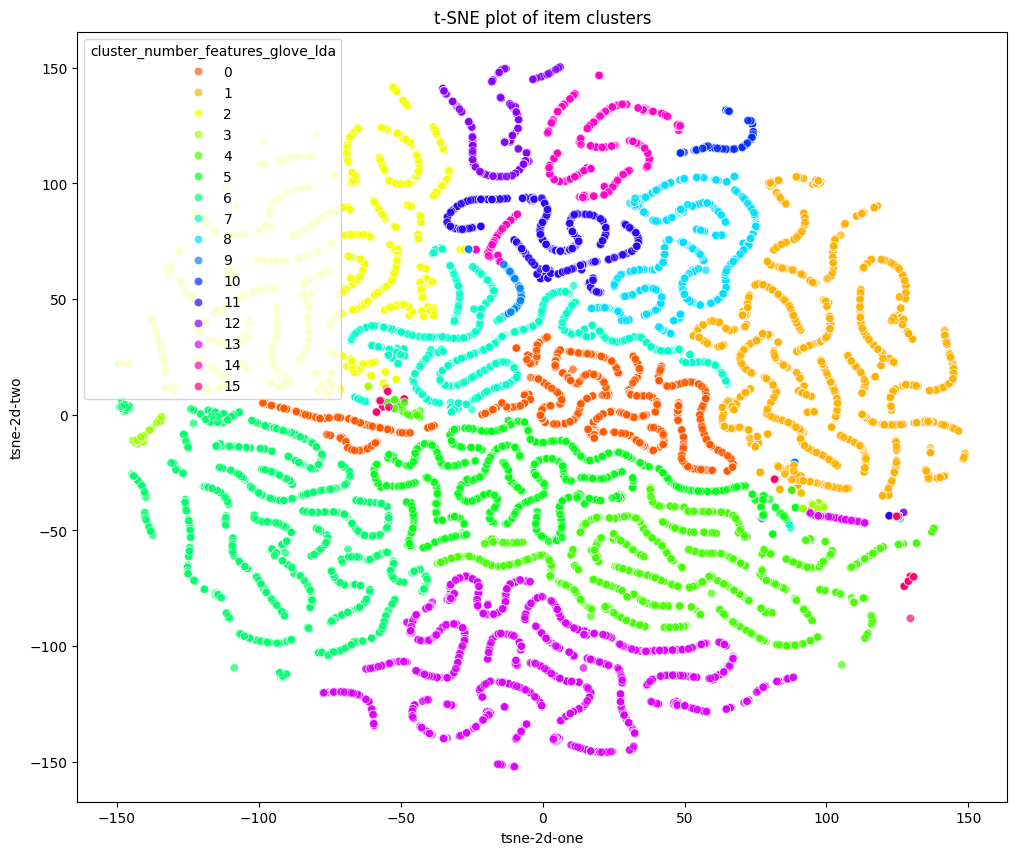

In [ ]:

plt.figure(figsize=(12,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="cluster_number_features_glove_lda",
    palette=sns.color_palette("hsv", clustering_df['cluster_number_features_glove_lda'].nunique()),
    data=clustering_df,
    legend="full",
    alpha=0.7
)
plt.title('t-SNE plot of item clusters')
plt.show()

Customer Segmentation

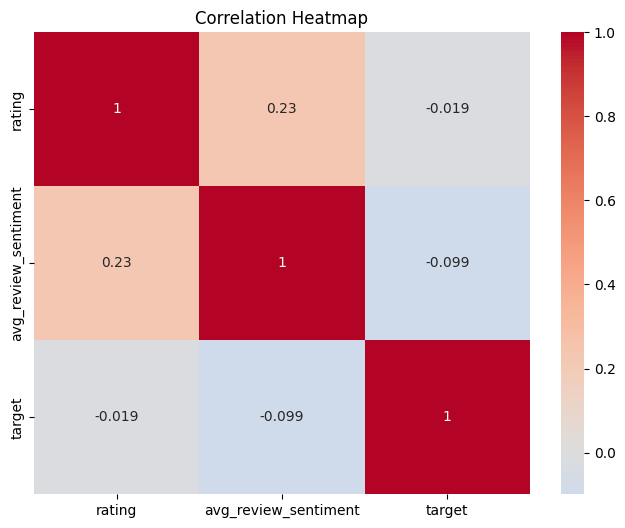

In [ ]:
# correlation check
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr_df = processed_combined_df[['rating', 'avg_review_sentiment',  'total_price', 'avg_frequency']]
corr_df['target'] = corr_df['total_price'] * corr_df['avg_frequency']
corr_df.drop(columns=['total_price', 'avg_frequency'], inplace=True)

corr = corr_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
# from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Concatenate, Input
from keras.models import Model

In [ ]:
# preprocessing
processed_combined_df['transaction_date'] = pd.to_datetime(processed_combined_df['transaction_date'])
processed_combined_df['transaction_year'] = processed_combined_df['transaction_date'].dt.year

df = processed_combined_df[['rating', 'review', 'total_price', 'avg_frequency', 'transaction_year']]

df['rating'] = df['rating'].astype(int)
df['total_price'] = df['total_price'].astype(float)
df['avg_frequency'] = df['avg_frequency'].astype(float)

In [ ]:
# calculate weightage and modify 'rating' feature for better result

av_rating_arr = np.array(df['rating'])
av_rating_arr_1 = np.expand_dims(av_rating_arr, axis=1)
av_rating_arr_1_int = av_rating_arr_1.astype(int)
np.unique(av_rating_arr_1_int)

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

av_rating_arr_1 = ohe.fit_transform(av_rating_arr_1_int.reshape(-1, 1)).toarray()

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(np.argmax(av_rating_arr_1, axis=1)),
    y = np.argmax(av_rating_arr_1, axis=1)
)

class_weights = dict(zip(np.unique(np.argmax(av_rating_arr_1, axis=1)), class_weights))
print(class_weights)

df['rating_new'] = df['rating'].apply(lambda x: x * class_weights[x-1])
df[['rating', 'rating_new']]

{0: 3.519248434237996, 1: 4.91463556851312, 2: 2.7707429322813937, 3: 1.544265298644192, 4: 0.28539599769749097}


rating  rating_new
0           5    1.426980
1           5    1.426980
2           5    1.426980
3           5    1.426980
4           5    1.426980
...       ...         ...
42138       5    1.426980
42139       1    3.519248
42140       5    1.426980
42141       5    1.426980
42142       5    1.426980

[42143 rows x 2 columns]

In [ ]:
train_df = df[df['transaction_year'] < 2021]
test_df = df[df['transaction_year'] >= 2021]

# Features and targets
X_train = train_df[['rating_new', 'review']]
y_train = train_df[['total_price', 'avg_frequency']]

X_test = test_df[['rating_new', 'review']]
y_test = test_df[['total_price', 'avg_frequency']]

# Scaling numerical features
scaler = MinMaxScaler()
X_train['rating_new'] = scaler.fit_transform(X_train[['rating_new']])
y_train = scaler.fit_transform(y_train)

X_test['rating_new'] = scaler.fit_transform(X_test[['rating_new']])
y_test = scaler.fit_transform(y_test)

# Tokenizing and padding text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train['review'])
X_review_train = tokenizer.texts_to_sequences(X_train['review'])
X_review_train = pad_sequences(X_review_train, maxlen=100)

# Combining numerical and text data
X_avg_rating_train = np.array(X_train['rating_new']).reshape(-1, 1)



# Tokenizing and padding text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_test['review'])
X_review_test = tokenizer.texts_to_sequences(X_test['review'])
X_review_test = pad_sequences(X_review_test, maxlen=100)

# Combining numerical and text data
X_avg_rating_test = np.array(X_test['rating_new']).reshape(-1, 1)


In [ ]:
y_train_updated = np.prod(y_train, axis=1)
y_test_updated = np.prod(y_test, axis=1)

Models used:

1. LSTM
2. LSTM with Attention
3. Bi-LSTM with Attention

Input:

1. Review and Rating
2. Only Review

Output: Total Price and Frequency and Duration

In [ ]:
# from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, Callback, ReduceLROnPlateau
# from keras.models import Model
# from keras.layers import Embedding, LSTM, Dense, Concatenate, Input, Flatten, Bidirectional, Attention, Dropout
# import matplotlib.pyplot as plt
# import tensorflow as tf

# # Learning rate calculation
# def lr_schedule(epoch, lr):
#     initial_lr = 0.0001
#     decay_rate = 0.8
#     decay_step = 5
#     if epoch == 0:
#         return initial_lr
#     if epoch % decay_step == 0:
#         lr = lr * decay_rate
#     return lr

# # Early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# # Learning rate scheduler callback
# lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)
# # reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# # Model checkpoint callback
# # model_checkpoint = ModelCheckpoint(
# #     '/content/drive/MyDrive/Dissertation Customer Segmentation/LSTM_Review_Rating_best_model.h5',
# #     monitor='val_loss',
# #     save_best_only=True,
# #     save_weights_only=False,
# #     mode='min',
# #     verbose=1
# # )


# input_review = Input(shape=(100,))

# x = Embedding(input_dim=5000, output_dim=128, input_length=100)(input_review)
# # x = LSTM(128, return_sequences=True)(x)
# x = Bidirectional(LSTM(128, return_sequences=True))(x)
# attention = Attention()([x, x])
# x = Flatten()(attention)
# # x = Flatten()(x)

# # Combine numerical and text inputs
# combined = Concatenate()([input_avg_rating, x])

# # Dense layers
# combined = Dense(64, activation='relu')(x)
# combined = Dropout(0.2)(combined)  # Dropout layer with 20% dropout rate
# combined = Dense(32, activation='relu')(combined)
# combined = Dropout(0.2)(combined)  # Dropout layer with 20% dropout rate
# output = Dense(1)(combined)  # Single unit for the output layer

# # Create the model
# model = Model(inputs=input_review, outputs=output)

# model.save('/content/drive/MyDrive/Dissertation Customer Segmentation/BiLSTM_attention_Review_best_model.h5')


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 100, 128)  │    640,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 100, 128)  │    131,584 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 12800)     │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 12801)     │          0 │ input_layer_2[0]… │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │    819,328 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,080 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         33 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,593,025 (6.08 MB)

 Trainable params: 1,593,025 (6.08 MB)

 Non-trainable params: 0 (0.00 B)


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/100
664/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.3118e-05
Epoch 1: val_loss improved from inf to 0.00002, saving model to /kaggle/working/best_model.keras


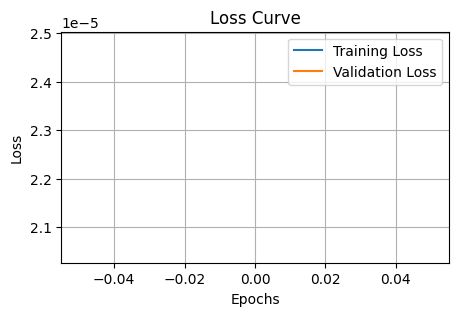

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 4.2981e-05 - val_loss: 2.0482e-05 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8630e-05
Epoch 2: val_loss improved from 0.00002 to 0.00002, saving model to /kaggle/working/best_model.keras


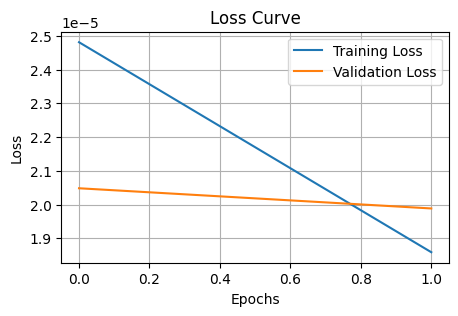

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.8630e-05 - val_loss: 1.9883e-05 - learning_rate: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7778e-05
Epoch 3: val_loss did not improve from 0.00002


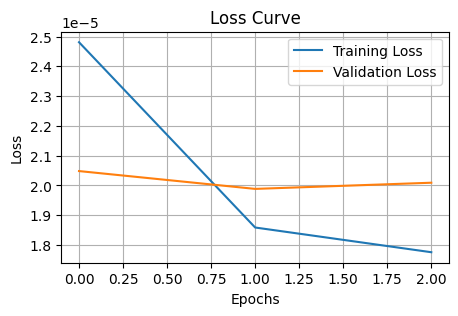

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.7778e-05 - val_loss: 2.0090e-05 - learning_rate: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 4/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7056e-05
Epoch 4: val_loss did not improve from 0.00002


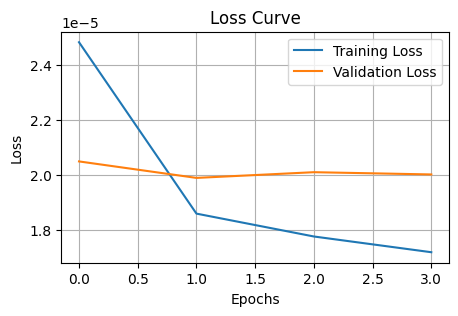

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.7056e-05 - val_loss: 2.0008e-05 - learning_rate: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 5/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6583e-05
Epoch 5: val_loss did not improve from 0.00002


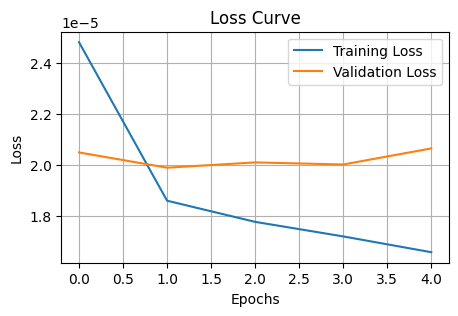

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.6583e-05 - val_loss: 2.0640e-05 - learning_rate: 1.0000e-04

Epoch 6: LearningRateScheduler setting learning rate to 7.999999797903001e-05.
Epoch 6/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5388e-05
Epoch 6: val_loss did not improve from 0.00002


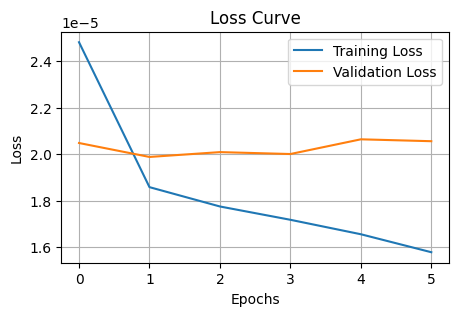

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.5388e-05 - val_loss: 2.0559e-05 - learning_rate: 8.0000e-05

Epoch 7: LearningRateScheduler setting learning rate to 7.999999797903001e-05.
Epoch 7/100
663/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5302e-05
Epoch 7: val_loss did not improve from 0.00002


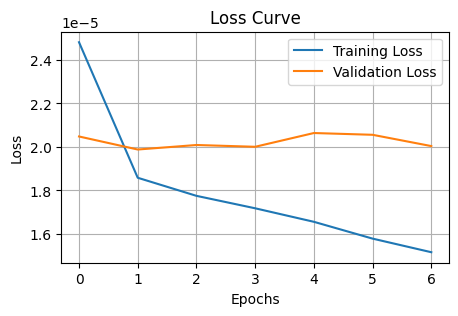

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.5301e-05 - val_loss: 2.0040e-05 - learning_rate: 8.0000e-05

Epoch 8: LearningRateScheduler setting learning rate to 7.999999797903001e-05.
Epoch 8/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4536e-05
Epoch 8: val_loss improved from 0.00002 to 0.00002, saving model to /kaggle/working/best_model.keras


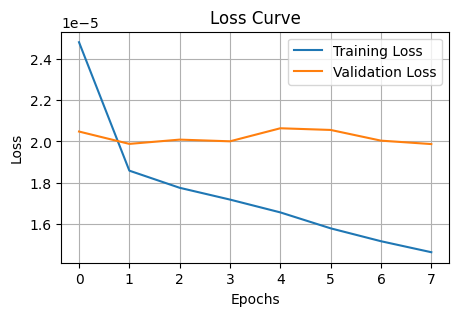

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.4536e-05 - val_loss: 1.9874e-05 - learning_rate: 8.0000e-05

Epoch 9: LearningRateScheduler setting learning rate to 7.999999797903001e-05.
Epoch 9/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4018e-05
Epoch 9: val_loss did not improve from 0.00002


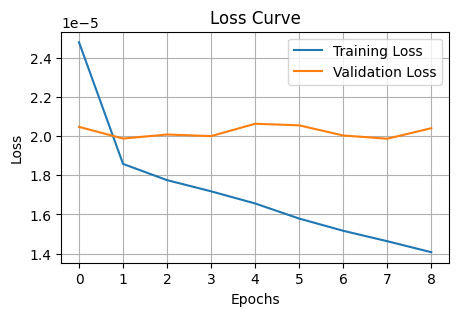

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 1.4018e-05 - val_loss: 2.0412e-05 - learning_rate: 8.0000e-05

Epoch 10: LearningRateScheduler setting learning rate to 7.999999797903001e-05.
Epoch 10/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3145e-05
Epoch 10: val_loss did not improve from 0.00002


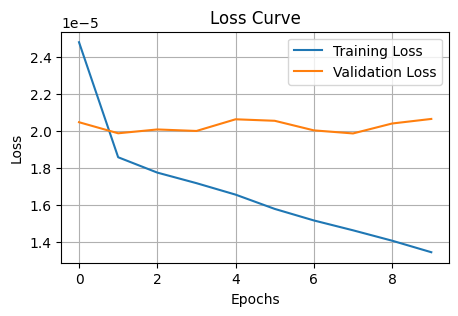

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.3146e-05 - val_loss: 2.0659e-05 - learning_rate: 8.0000e-05

Epoch 11: LearningRateScheduler setting learning rate to 6.399999838322402e-05.
Epoch 11/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2657e-05
Epoch 11: val_loss did not improve from 0.00002


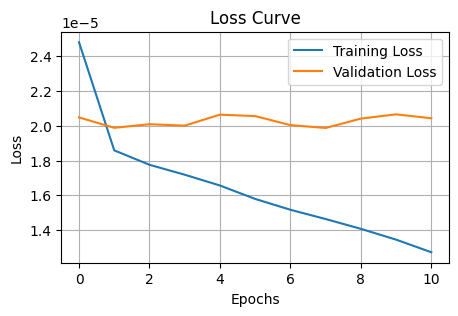

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.2657e-05 - val_loss: 2.0433e-05 - learning_rate: 6.4000e-05

Epoch 12: LearningRateScheduler setting learning rate to 6.399999983841553e-05.
Epoch 12/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2163e-05
Epoch 12: val_loss did not improve from 0.00002


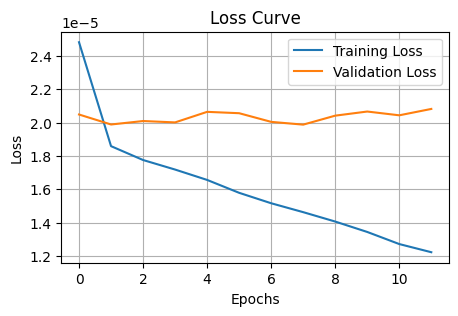

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.2164e-05 - val_loss: 2.0815e-05 - learning_rate: 6.4000e-05

Epoch 13: LearningRateScheduler setting learning rate to 6.399999983841553e-05.
Epoch 13/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1658e-05
Epoch 13: val_loss did not improve from 0.00002


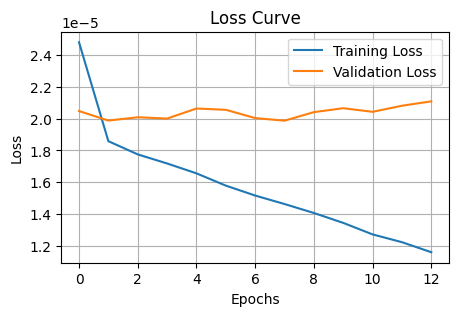

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.1657e-05 - val_loss: 2.1092e-05 - learning_rate: 6.4000e-05

Epoch 14: LearningRateScheduler setting learning rate to 6.399999983841553e-05.
Epoch 14/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0999e-05
Epoch 14: val_loss did not improve from 0.00002


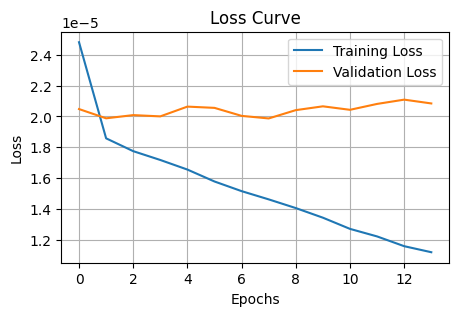

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.1000e-05 - val_loss: 2.0846e-05 - learning_rate: 6.4000e-05

Epoch 15: LearningRateScheduler setting learning rate to 6.399999983841553e-05.
Epoch 15/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0838e-05
Epoch 15: val_loss did not improve from 0.00002


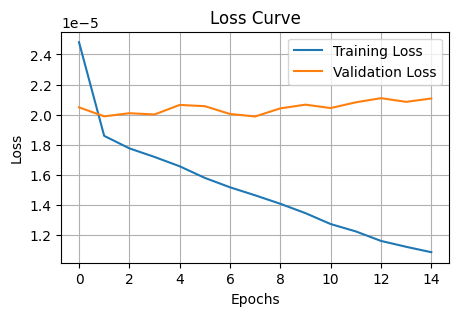

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 1.0838e-05 - val_loss: 2.1070e-05 - learning_rate: 6.4000e-05

Epoch 16: LearningRateScheduler setting learning rate to 5.119999987073243e-05.
Epoch 16/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0383e-05
Epoch 16: val_loss did not improve from 0.00002


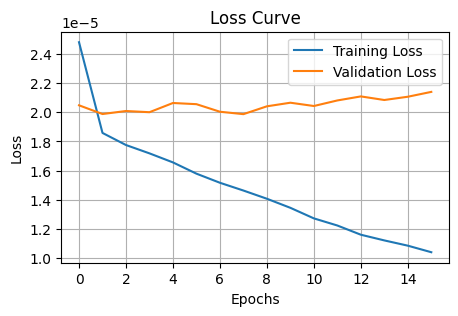

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.0383e-05 - val_loss: 2.1403e-05 - learning_rate: 5.1200e-05

Epoch 17: LearningRateScheduler setting learning rate to 5.120000059832819e-05.
Epoch 17/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.6286e-06
Epoch 17: val_loss did not improve from 0.00002


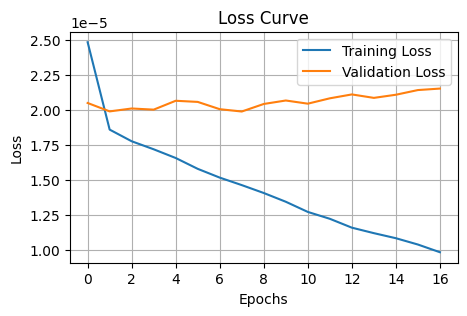

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 9.6299e-06 - val_loss: 2.1509e-05 - learning_rate: 5.1200e-05

Epoch 18: LearningRateScheduler setting learning rate to 5.120000059832819e-05.
Epoch 18/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.3766e-06
Epoch 18: val_loss did not improve from 0.00002


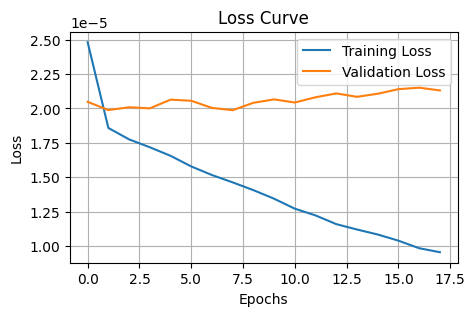

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 9.3774e-06 - val_loss: 2.1311e-05 - learning_rate: 5.1200e-05

Epoch 19: LearningRateScheduler setting learning rate to 5.120000059832819e-05.
Epoch 19/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.5070e-06
Epoch 19: val_loss did not improve from 0.00002


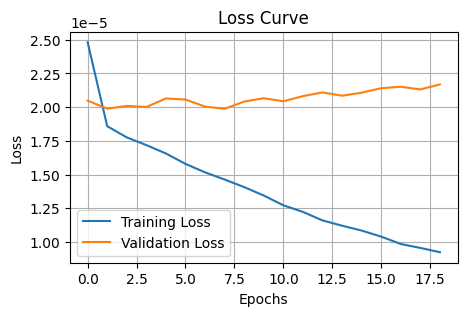

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 9.5062e-06 - val_loss: 2.1684e-05 - learning_rate: 5.1200e-05

Epoch 20: LearningRateScheduler setting learning rate to 5.120000059832819e-05.
Epoch 20/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.9684e-06
Epoch 20: val_loss did not improve from 0.00002


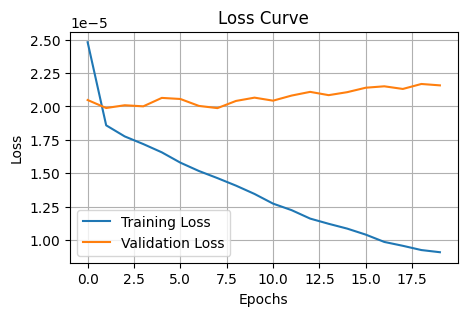

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 8.9689e-06 - val_loss: 2.1579e-05 - learning_rate: 5.1200e-05

Epoch 21: LearningRateScheduler setting learning rate to 4.0960000478662555e-05.
Epoch 21/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.7899e-06
Epoch 21: val_loss did not improve from 0.00002


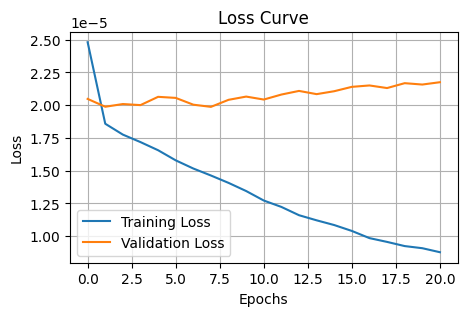

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 8.7898e-06 - val_loss: 2.1757e-05 - learning_rate: 4.0960e-05

Epoch 22: LearningRateScheduler setting learning rate to 4.095999975106679e-05.
Epoch 22/100
664/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.2772e-06
Epoch 22: val_loss did not improve from 0.00002


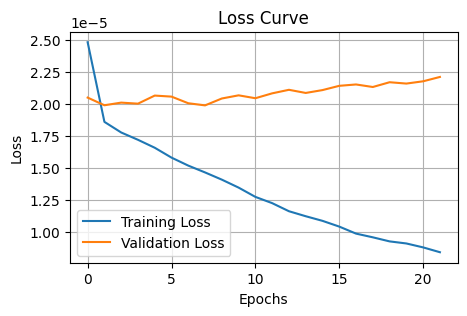

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 8.2781e-06 - val_loss: 2.2097e-05 - learning_rate: 4.0960e-05

Epoch 23: LearningRateScheduler setting learning rate to 4.095999975106679e-05.
Epoch 23/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.1354e-06
Epoch 23: val_loss did not improve from 0.00002


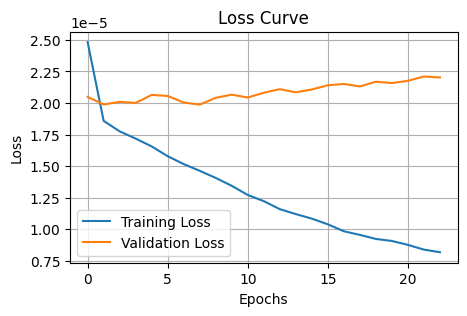

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 8.1358e-06 - val_loss: 2.2022e-05 - learning_rate: 4.0960e-05

Epoch 24: LearningRateScheduler setting learning rate to 4.095999975106679e-05.
Epoch 24/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.9910e-06
Epoch 24: val_loss did not improve from 0.00002


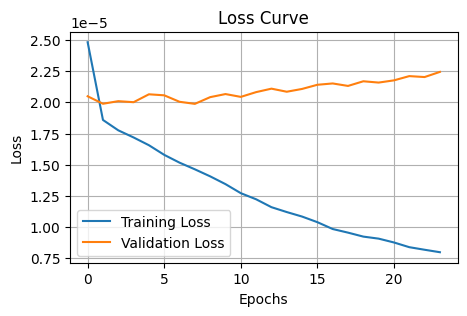

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 7.9910e-06 - val_loss: 2.2435e-05 - learning_rate: 4.0960e-05

Epoch 25: LearningRateScheduler setting learning rate to 4.095999975106679e-05.
Epoch 25/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.8609e-06
Epoch 25: val_loss did not improve from 0.00002


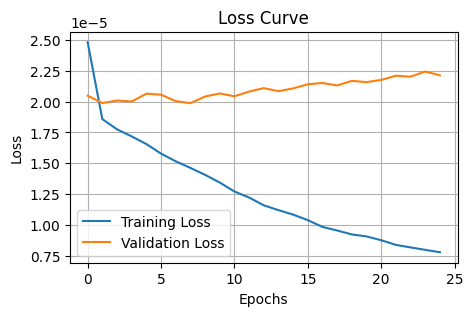

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 7.8607e-06 - val_loss: 2.2134e-05 - learning_rate: 4.0960e-05

Epoch 26: LearningRateScheduler setting learning rate to 3.2767999800853435e-05.
Epoch 26/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.4944e-06
Epoch 26: val_loss did not improve from 0.00002


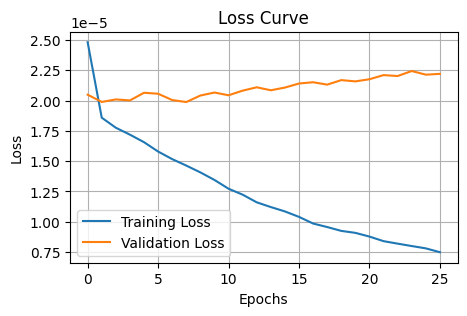

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 7.4943e-06 - val_loss: 2.2201e-05 - learning_rate: 3.2768e-05

Epoch 27: LearningRateScheduler setting learning rate to 3.276799907325767e-05.
Epoch 27/100
663/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.5311e-06
Epoch 27: val_loss did not improve from 0.00002


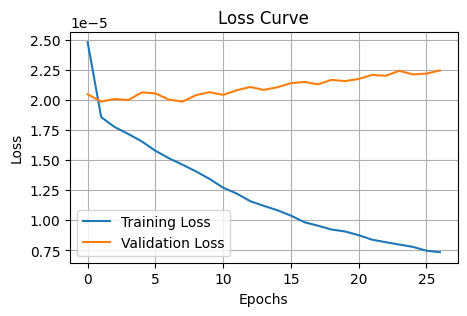

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 7.5295e-06 - val_loss: 2.2464e-05 - learning_rate: 3.2768e-05

Epoch 28: LearningRateScheduler setting learning rate to 3.276799907325767e-05.
Epoch 28/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.3802e-06
Epoch 28: val_loss did not improve from 0.00002


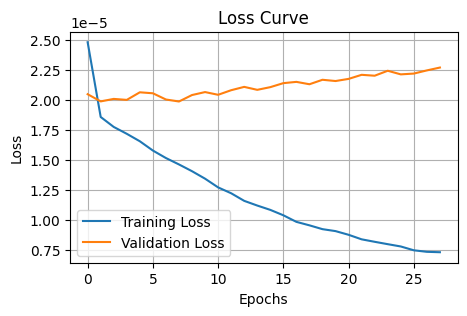

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 7.3801e-06 - val_loss: 2.2702e-05 - learning_rate: 3.2768e-05


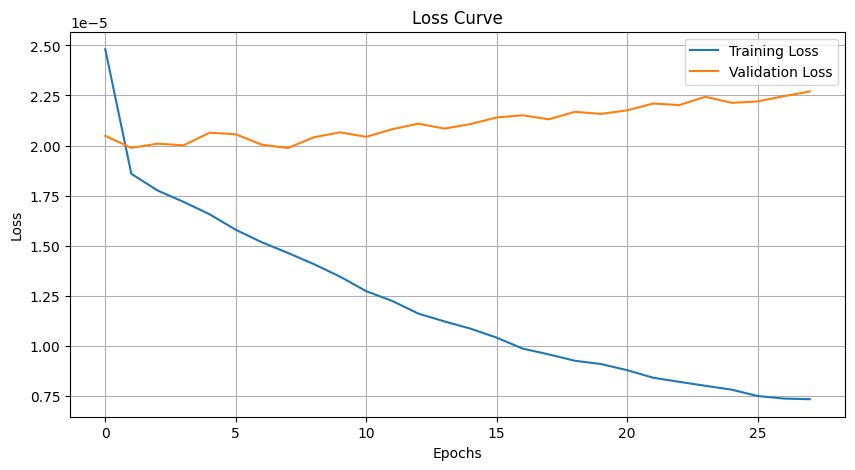

483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.9456e-05
Test Loss: 2.0072084225830622e-05


In [ ]:
# Model: LSTM
# Input: Review and Rating
# Output: Total Price and Frequency

from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, Callback, ReduceLROnPlateau
from keras.models import Model
from keras.layers import Embedding, LSTM, Dense, Concatenate, Input, Flatten, Bidirectional, Attention, Dropout
import matplotlib.pyplot as plt
import tensorflow as tf

# Learning rate calculation
def lr_schedule(epoch, lr):
    initial_lr = 0.0001
    decay_rate = 0.8
    decay_step = 5
    if epoch == 0:
        return initial_lr
    if epoch % decay_step == 0:
        lr = lr * decay_rate
    return lr

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Model checkpoint callback
model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Dissertation Customer Segmentation/LSTM_Review_Rating_best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)
# model_checkpoint = ModelCheckpoint(
#     '/kaggle/working/best_model.keras',
#     monitor='val_loss',
#     save_best_only=True,
#     save_weights_only=False,
#     mode='min',
#     verbose=1
# )

# Custom plotting callback
class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.epochs = []
        self.losses = []
        self.val_losses = []
        plt.ion()

    def on_epoch_end(self, epoch, logs={}):
        self.epochs.append(epoch)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

        plt.figure(figsize=(5, 3))
        plt.plot(self.epochs, self.losses, label='Training Loss')
        plt.plot(self.epochs, self.val_losses, label='Validation Loss')
        plt.title('Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.draw()
        plt.pause(0.001)
        plt.show()

plot_losses = PlotLosses()

input_avg_rating = Input(shape=(1,))
input_review = Input(shape=(100,))

x = Embedding(input_dim=5000, output_dim=128, input_length=100)(input_review)
x = LSTM(128, return_sequences=True)(x)
# attention = Attention()([x, x])
# x = Flatten()(attention)
x = Flatten()(x)

# Combine numerical and text inputs
combined = Concatenate()([input_avg_rating, x])

# Dense layers
combined = Dense(64, activation='relu')(combined)
combined = Dropout(0.2)(combined)  # Dropout layer with 20% dropout rate
combined = Dense(32, activation='relu')(combined)
combined = Dropout(0.2)(combined)  # Dropout layer with 20% dropout rate
output = Dense(1)(combined)  # Single unit for the output layer

# Create the model
model = Model(inputs=[input_avg_rating, input_review], outputs=output)

# Compile the model with the initial learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

model.summary()

history = model.fit(
    [X_avg_rating_train, X_review_train],
    y_train_updated,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint, plot_losses]
)

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
loss = model.evaluate([X_avg_rating_test, X_review_test], y_test_updated)
print(f"Test Loss: {loss}")


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_15        │ (None, 100, 128)  │    640,000 │ input_layer_26[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ (None, 100, 128)  │    131,584 │ embedding_15[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_11        │ (None, 100, 128)  │          0 │ lstm_15[0][0],    │
│ (Attention)         │                   │            │ lstm_15[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_25      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_15          │ (None, 12800)     │          0 │ attention_11[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_15      │ (None, 12801)     │          0 │ input_layer_25[0… │
│ (Concatenate)       │                   │            │ flatten_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_45 (Dense)    │ (None, 64)        │    819,328 │ concatenate_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 64)        │          0 │ dense_45[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_46 (Dense)    │ (None, 32)        │      2,080 │ dropout_30[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 32)        │          0 │ dense_46[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_47 (Dense)    │ (None, 1)         │         33 │ dropout_31[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,593,025 (6.08 MB)

 Trainable params: 1,593,025 (6.08 MB)

 Non-trainable params: 0 (0.00 B)


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.6893e-05
Epoch 1: val_loss improved from inf to 0.00002, saving model to /kaggle/working/best_model.keras


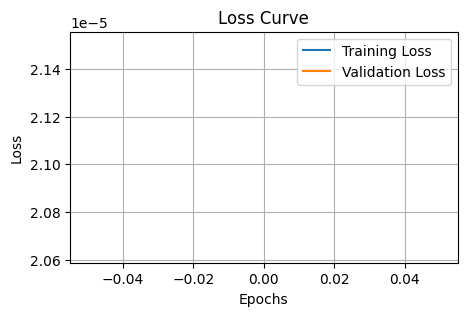

668/668 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 2.6876e-05 - val_loss: 2.0631e-05 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9793e-05
Epoch 2: val_loss did not improve from 0.00002


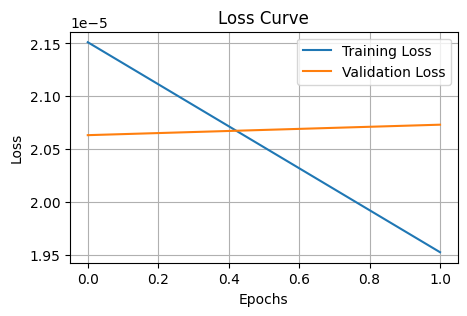

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.9792e-05 - val_loss: 2.0730e-05 - learning_rate: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9160e-05
Epoch 3: val_loss did not improve from 0.00002


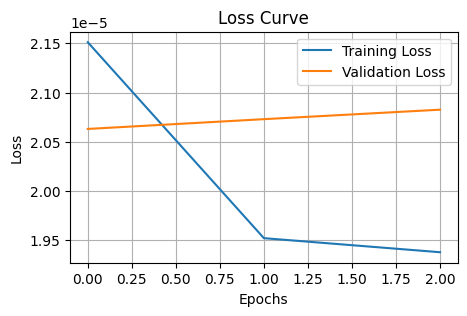

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.9161e-05 - val_loss: 2.0827e-05 - learning_rate: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 4/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9091e-05
Epoch 4: val_loss did not improve from 0.00002


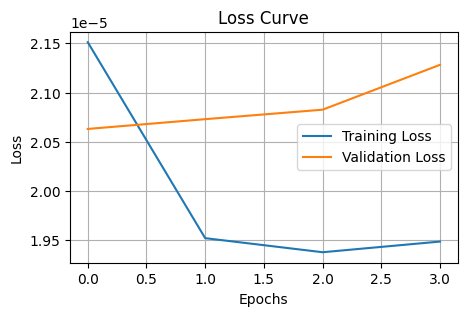

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.9093e-05 - val_loss: 2.1282e-05 - learning_rate: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 5/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9005e-05
Epoch 5: val_loss did not improve from 0.00002


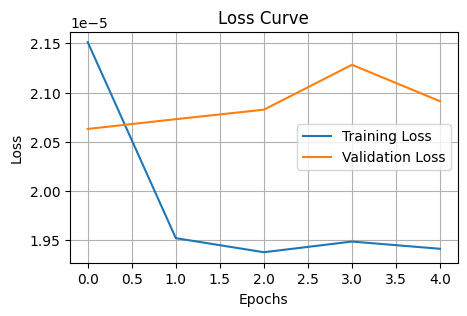

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.9007e-05 - val_loss: 2.0912e-05 - learning_rate: 1.0000e-04

Epoch 6: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
Epoch 6/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9311e-05
Epoch 6: val_loss improved from 0.00002 to 0.00002, saving model to /kaggle/working/best_model.keras


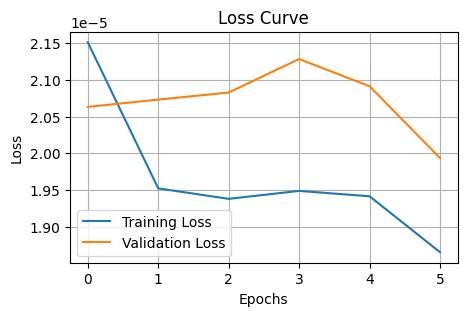

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 1.9307e-05 - val_loss: 1.9935e-05 - learning_rate: 5.0000e-05

Epoch 7: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
Epoch 7/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8583e-05
Epoch 7: val_loss improved from 0.00002 to 0.00002, saving model to /kaggle/working/best_model.keras


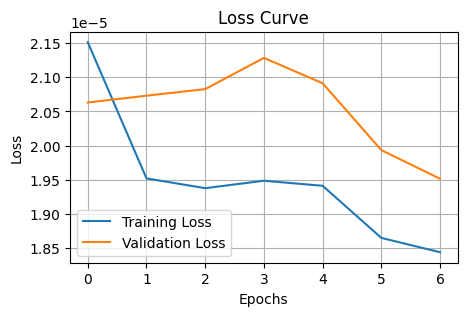

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 1.8582e-05 - val_loss: 1.9517e-05 - learning_rate: 5.0000e-05

Epoch 8: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
Epoch 8/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8222e-05
Epoch 8: val_loss did not improve from 0.00002


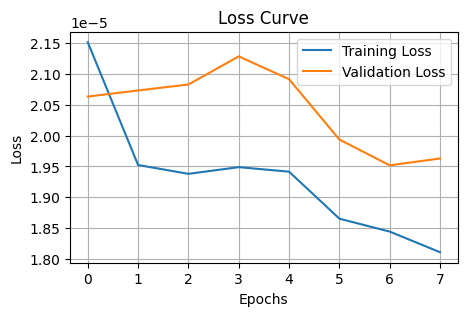

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 1.8222e-05 - val_loss: 1.9628e-05 - learning_rate: 5.0000e-05

Epoch 9: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
Epoch 9/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7935e-05
Epoch 9: val_loss did not improve from 0.00002


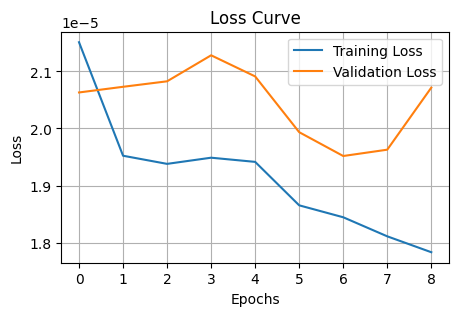

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.7934e-05 - val_loss: 2.0716e-05 - learning_rate: 5.0000e-05

Epoch 10: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
Epoch 10/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7579e-05
Epoch 10: val_loss did not improve from 0.00002


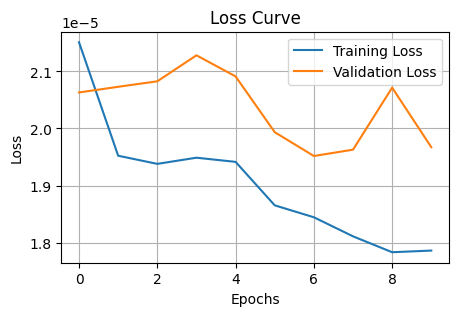

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.7581e-05 - val_loss: 1.9672e-05 - learning_rate: 5.0000e-05

Epoch 11: LearningRateScheduler setting learning rate to 2.499999936844688e-05.
Epoch 11/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7197e-05
Epoch 11: val_loss improved from 0.00002 to 0.00002, saving model to /kaggle/working/best_model.keras


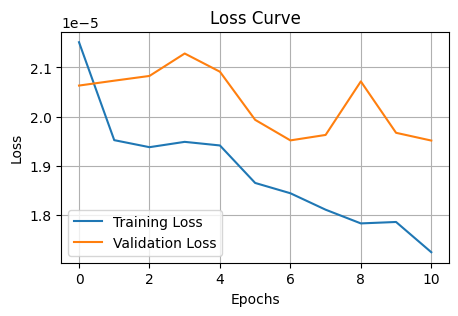

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 1.7197e-05 - val_loss: 1.9514e-05 - learning_rate: 2.5000e-05

Epoch 12: LearningRateScheduler setting learning rate to 2.499999936844688e-05.
Epoch 12/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7228e-05
Epoch 12: val_loss did not improve from 0.00002


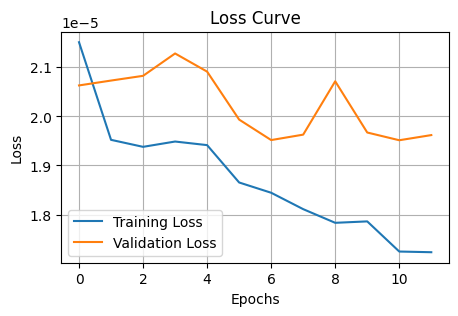

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.7228e-05 - val_loss: 1.9619e-05 - learning_rate: 2.5000e-05

Epoch 13: LearningRateScheduler setting learning rate to 2.499999936844688e-05.
Epoch 13/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6918e-05
Epoch 13: val_loss did not improve from 0.00002


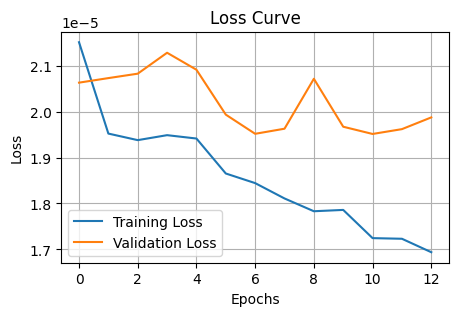

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 1.6919e-05 - val_loss: 1.9875e-05 - learning_rate: 2.5000e-05

Epoch 14: LearningRateScheduler setting learning rate to 2.499999936844688e-05.
Epoch 14/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6939e-05
Epoch 14: val_loss did not improve from 0.00002


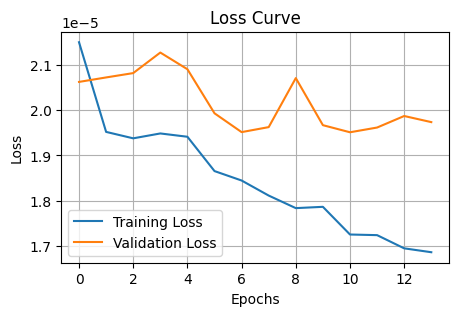

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.6938e-05 - val_loss: 1.9739e-05 - learning_rate: 2.5000e-05

Epoch 15: LearningRateScheduler setting learning rate to 2.499999936844688e-05.
Epoch 15/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6863e-05
Epoch 15: val_loss improved from 0.00002 to 0.00002, saving model to /kaggle/working/best_model.keras


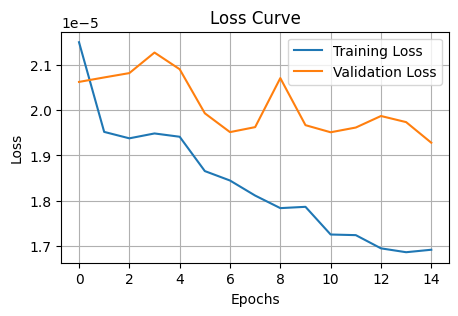

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.6863e-05 - val_loss: 1.9282e-05 - learning_rate: 2.5000e-05

Epoch 16: LearningRateScheduler setting learning rate to 1.249999968422344e-05.
Epoch 16/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6718e-05
Epoch 16: val_loss did not improve from 0.00002


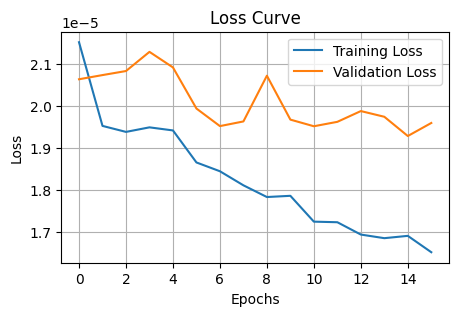

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.6717e-05 - val_loss: 1.9592e-05 - learning_rate: 1.2500e-05

Epoch 17: LearningRateScheduler setting learning rate to 1.249999968422344e-05.
Epoch 17/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6530e-05
Epoch 17: val_loss did not improve from 0.00002


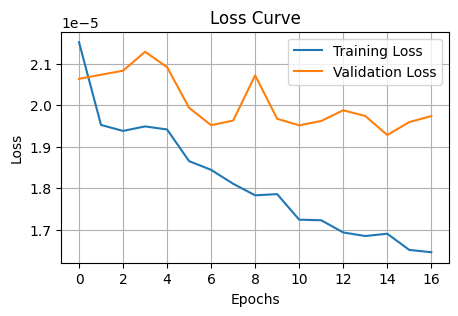

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.6529e-05 - val_loss: 1.9736e-05 - learning_rate: 1.2500e-05

Epoch 18: LearningRateScheduler setting learning rate to 1.249999968422344e-05.
Epoch 18/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6720e-05
Epoch 18: val_loss did not improve from 0.00002


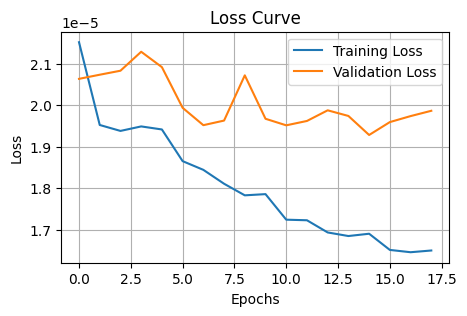

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.6720e-05 - val_loss: 1.9863e-05 - learning_rate: 1.2500e-05

Epoch 19: LearningRateScheduler setting learning rate to 1.249999968422344e-05.
Epoch 19/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6202e-05
Epoch 19: val_loss did not improve from 0.00002


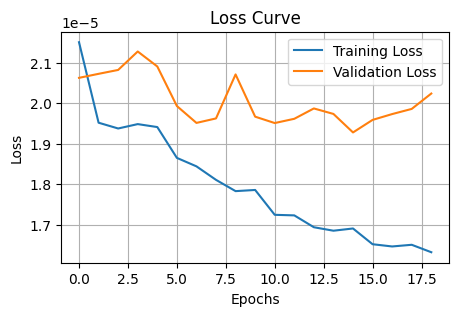

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.6203e-05 - val_loss: 2.0243e-05 - learning_rate: 1.2500e-05

Epoch 20: LearningRateScheduler setting learning rate to 1.249999968422344e-05.
Epoch 20/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6202e-05
Epoch 20: val_loss did not improve from 0.00002


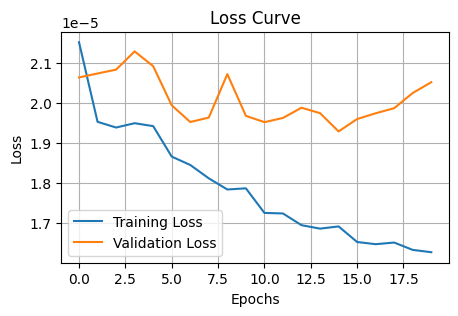

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.6202e-05 - val_loss: 2.0512e-05 - learning_rate: 1.2500e-05

Epoch 21: LearningRateScheduler setting learning rate to 6.24999984211172e-06.
Epoch 21/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6175e-05
Epoch 21: val_loss did not improve from 0.00002


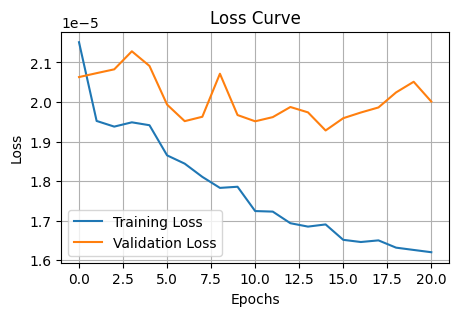

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.6175e-05 - val_loss: 2.0012e-05 - learning_rate: 6.2500e-06

Epoch 22: LearningRateScheduler setting learning rate to 6.24999984211172e-06.
Epoch 22/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6251e-05
Epoch 22: val_loss did not improve from 0.00002


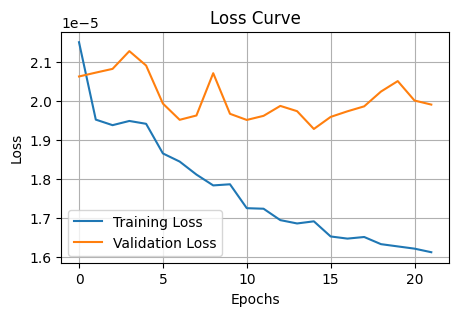

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.6251e-05 - val_loss: 1.9909e-05 - learning_rate: 6.2500e-06

Epoch 23: LearningRateScheduler setting learning rate to 6.24999984211172e-06.
Epoch 23/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5903e-05
Epoch 23: val_loss did not improve from 0.00002


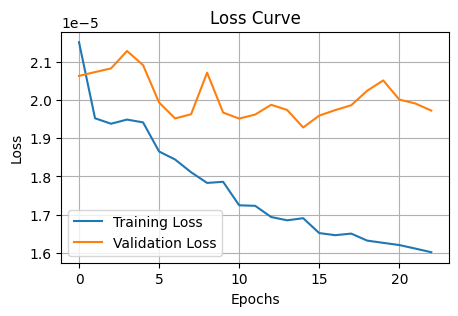

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.5903e-05 - val_loss: 1.9724e-05 - learning_rate: 6.2500e-06

Epoch 24: LearningRateScheduler setting learning rate to 6.24999984211172e-06.
Epoch 24/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6229e-05
Epoch 24: val_loss did not improve from 0.00002


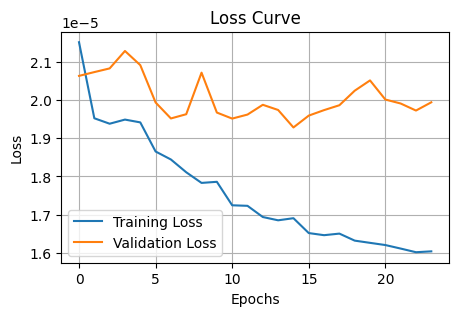

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.6228e-05 - val_loss: 1.9940e-05 - learning_rate: 6.2500e-06

Epoch 25: LearningRateScheduler setting learning rate to 6.24999984211172e-06.
Epoch 25/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6280e-05
Epoch 25: val_loss did not improve from 0.00002


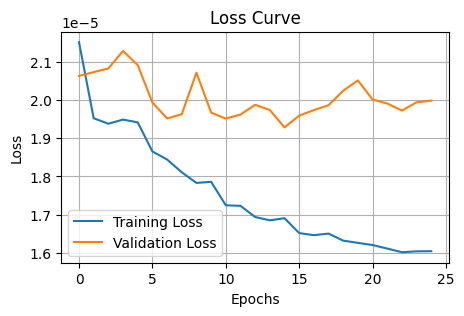

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.6279e-05 - val_loss: 1.9985e-05 - learning_rate: 6.2500e-06

Epoch 26: LearningRateScheduler setting learning rate to 3.12499992105586e-06.
Epoch 26/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6006e-05
Epoch 26: val_loss did not improve from 0.00002


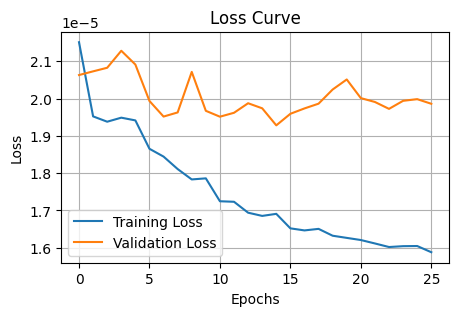

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.6005e-05 - val_loss: 1.9861e-05 - learning_rate: 3.1250e-06

Epoch 27: LearningRateScheduler setting learning rate to 3.12499992105586e-06.
Epoch 27/100
664/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6284e-05
Epoch 27: val_loss did not improve from 0.00002


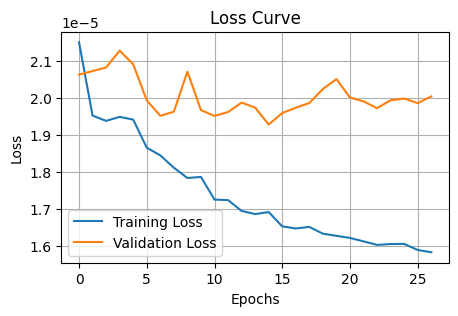

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.6281e-05 - val_loss: 2.0043e-05 - learning_rate: 3.1250e-06

Epoch 28: LearningRateScheduler setting learning rate to 3.12499992105586e-06.
Epoch 28/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5575e-05
Epoch 28: val_loss did not improve from 0.00002


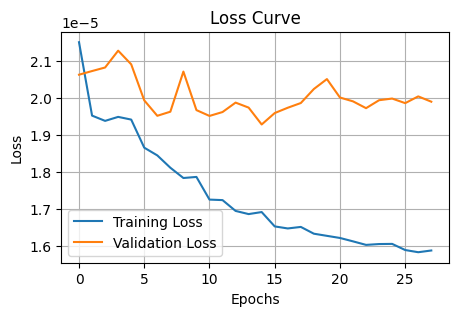

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.5576e-05 - val_loss: 1.9900e-05 - learning_rate: 3.1250e-06

Epoch 29: LearningRateScheduler setting learning rate to 3.12499992105586e-06.
Epoch 29/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5938e-05
Epoch 29: val_loss did not improve from 0.00002


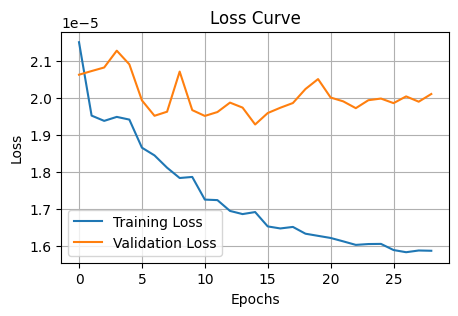

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.5938e-05 - val_loss: 2.0108e-05 - learning_rate: 3.1250e-06

Epoch 30: LearningRateScheduler setting learning rate to 3.12499992105586e-06.
Epoch 30/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5714e-05
Epoch 30: val_loss did not improve from 0.00002


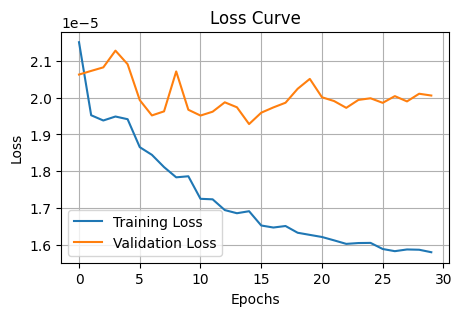

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.5714e-05 - val_loss: 2.0060e-05 - learning_rate: 3.1250e-06

Epoch 31: LearningRateScheduler setting learning rate to 1.56249996052793e-06.
Epoch 31/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5854e-05
Epoch 31: val_loss did not improve from 0.00002


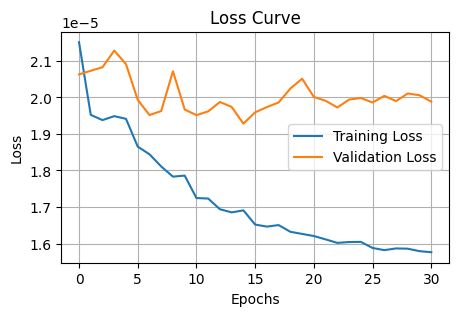

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.5854e-05 - val_loss: 1.9885e-05 - learning_rate: 1.5625e-06

Epoch 32: LearningRateScheduler setting learning rate to 1.56249996052793e-06.
Epoch 32/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6070e-05
Epoch 32: val_loss did not improve from 0.00002


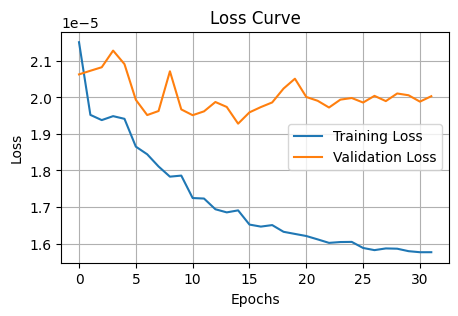

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.6069e-05 - val_loss: 2.0033e-05 - learning_rate: 1.5625e-06

Epoch 33: LearningRateScheduler setting learning rate to 1.56249996052793e-06.
Epoch 33/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5656e-05
Epoch 33: val_loss did not improve from 0.00002


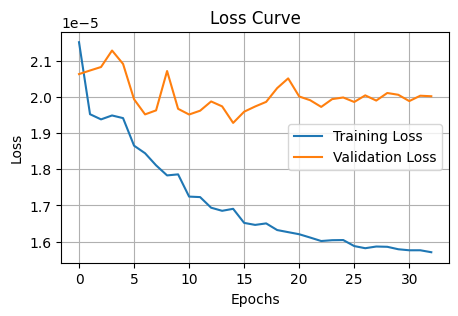

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.5656e-05 - val_loss: 2.0019e-05 - learning_rate: 1.5625e-06

Epoch 34: LearningRateScheduler setting learning rate to 1.56249996052793e-06.
Epoch 34/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5836e-05
Epoch 34: val_loss did not improve from 0.00002


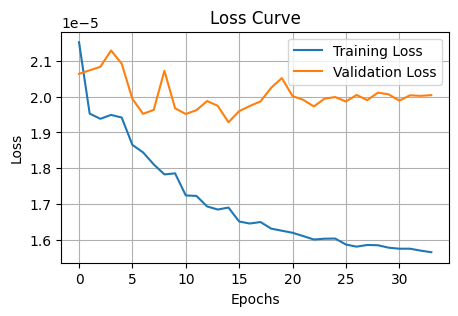

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 1.5836e-05 - val_loss: 2.0038e-05 - learning_rate: 1.5625e-06

Epoch 35: LearningRateScheduler setting learning rate to 1.56249996052793e-06.
Epoch 35/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5884e-05
Epoch 35: val_loss did not improve from 0.00002


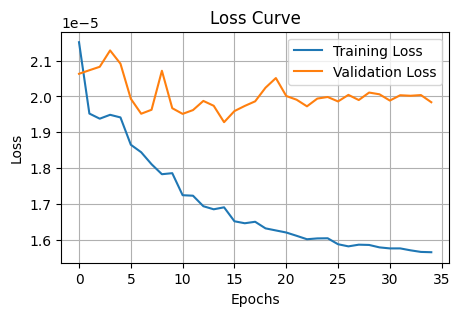

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 1.5884e-05 - val_loss: 1.9838e-05 - learning_rate: 1.5625e-06


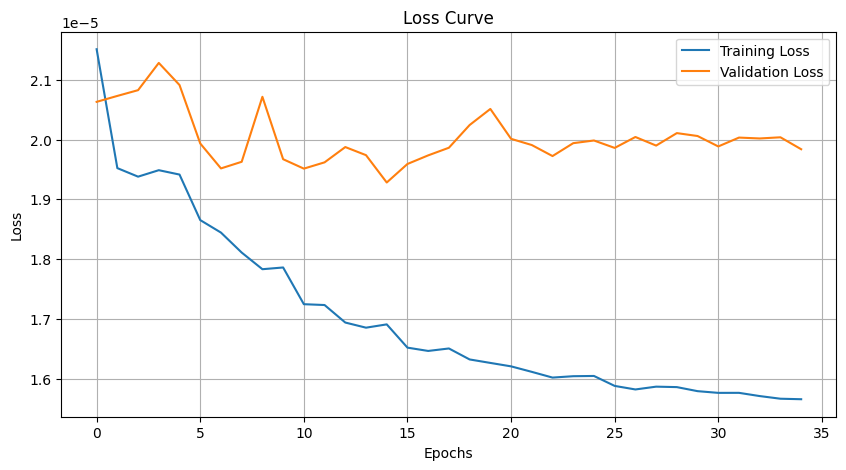

483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.8960e-05
Test Loss: 1.9564065951271914e-05


In [ ]:
# Model: LSTM with Attention
# Input: Review and Rating
# Output: Total Price and Frequency

from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, Callback, ReduceLROnPlateau
from keras.models import Model
from keras.layers import Embedding, LSTM, Dense, Concatenate, Input, Flatten, Bidirectional, Attention, Dropout
import matplotlib.pyplot as plt
import tensorflow as tf

# Learning rate calculation
def lr_schedule(epoch, lr):
    initial_lr = 0.0001  # Set the initial learning rate
    decay_rate = 0.5
    decay_step = 5
    if epoch == 0:
        return initial_lr
    if epoch % decay_step == 0:
        lr = lr * decay_rate
    return lr

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Model checkpoint callback
model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Dissertation Customer Segmentation/LSTM_attention_Review_Rating_best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)
# model_checkpoint = ModelCheckpoint(
#     '/kaggle/working/best_model.keras',
#     monitor='val_loss',
#     save_best_only=True,
#     save_weights_only=False,
#     mode='min',
#     verbose=1
# )

# Custom plotting callback
class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.epochs = []
        self.losses = []
        self.val_losses = []
        plt.ion()

    def on_epoch_end(self, epoch, logs={}):
        self.epochs.append(epoch)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

        plt.figure(figsize=(5, 3))
        plt.plot(self.epochs, self.losses, label='Training Loss')
        plt.plot(self.epochs, self.val_losses, label='Validation Loss')
        plt.title('Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.draw()
        plt.pause(0.001)
        plt.show()

plot_losses = PlotLosses()

input_avg_rating = Input(shape=(1,))
input_review = Input(shape=(100,))

x = Embedding(input_dim=5000, output_dim=128, input_length=100)(input_review)
x = LSTM(128, return_sequences=True)(x)
attention = Attention()([x, x])
x = Flatten()(attention)
# x = Flatten()(x)

# Combine numerical and text inputs
combined = Concatenate()([input_avg_rating, x])

# Dense layers
combined = Dense(64, activation='relu')(combined)
combined = Dropout(0.2)(combined)  # Dropout layer with 20% dropout rate
combined = Dense(32, activation='relu')(combined)
combined = Dropout(0.2)(combined)  # Dropout layer with 20% dropout rate
output = Dense(1)(combined)  # Single unit for the output layer

# Create the model
model = Model(inputs=[input_avg_rating, input_review], outputs=output)

# Compile the model with the initial learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

model.summary()

history = model.fit(
    [X_avg_rating_train, X_review_train],
    y_train_updated,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint, plot_losses]
)

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
loss = model.evaluate([X_avg_rating_test, X_review_test], y_test_updated)
print(f"Test Loss: {loss}")


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_14        │ (None, 100, 128)  │    640,000 │ input_layer_24[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 100, 256)  │    263,168 │ embedding_14[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_10        │ (None, 100, 256)  │          0 │ bidirectional_6[… │
│ (Attention)         │                   │            │ bidirectional_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_23      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_14          │ (None, 25600)     │          0 │ attention_10[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 25601)     │          0 │ input_layer_23[0… │
│ (Concatenate)       │                   │            │ flatten_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 64)        │  1,638,528 │ concatenate_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 64)        │          0 │ dense_42[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 32)        │      2,080 │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 32)        │          0 │ dense_43[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 1)         │         33 │ dropout_29[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,543,809 (9.70 MB)

 Trainable params: 2,543,809 (9.70 MB)

 Non-trainable params: 0 (0.00 B)


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.3434e-05
Epoch 1: val_loss improved from inf to 0.00002, saving model to /kaggle/working/best_model.keras


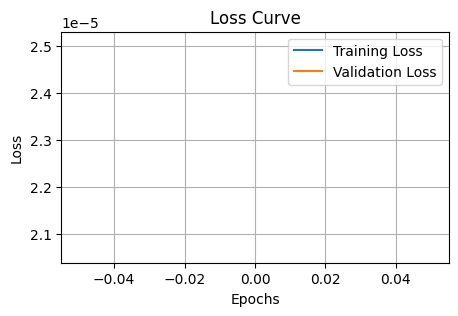

668/668 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 4.3406e-05 - val_loss: 2.0618e-05 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.9385e-05
Epoch 2: val_loss did not improve from 0.00002


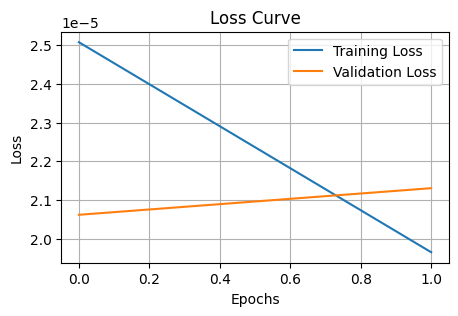

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.9386e-05 - val_loss: 2.1306e-05 - learning_rate: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.9907e-05
Epoch 3: val_loss did not improve from 0.00002


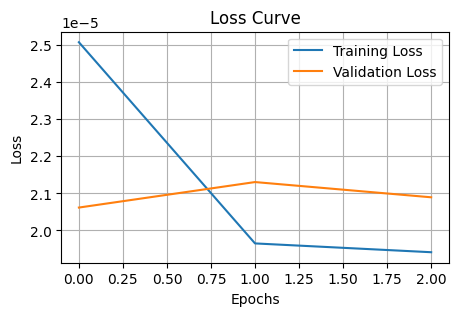

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.9906e-05 - val_loss: 2.0895e-05 - learning_rate: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 4/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.9253e-05
Epoch 4: val_loss improved from 0.00002 to 0.00002, saving model to /kaggle/working/best_model.keras


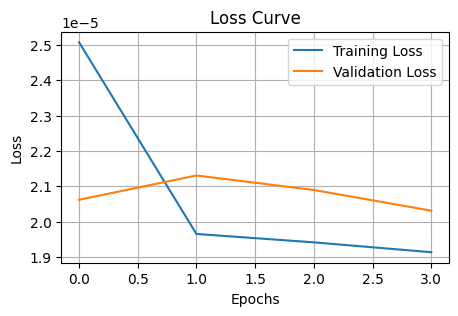

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.9253e-05 - val_loss: 2.0310e-05 - learning_rate: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 5/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.9001e-05
Epoch 5: val_loss improved from 0.00002 to 0.00002, saving model to /kaggle/working/best_model.keras


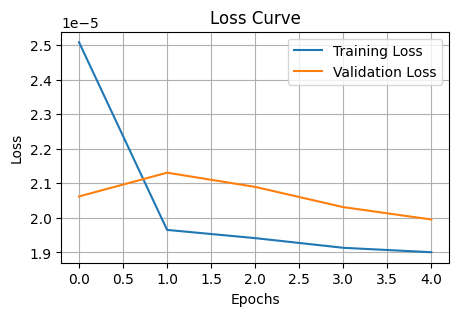

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.9001e-05 - val_loss: 1.9952e-05 - learning_rate: 1.0000e-04

Epoch 6: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
Epoch 6/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8808e-05
Epoch 6: val_loss did not improve from 0.00002


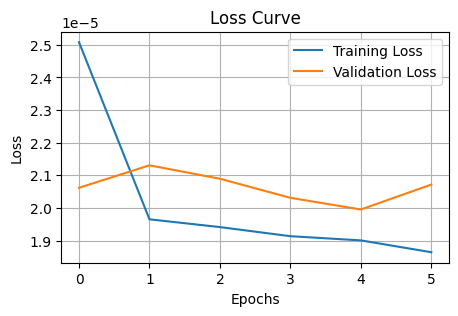

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.8808e-05 - val_loss: 2.0716e-05 - learning_rate: 5.0000e-05

Epoch 7: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
Epoch 7/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8412e-05
Epoch 7: val_loss did not improve from 0.00002


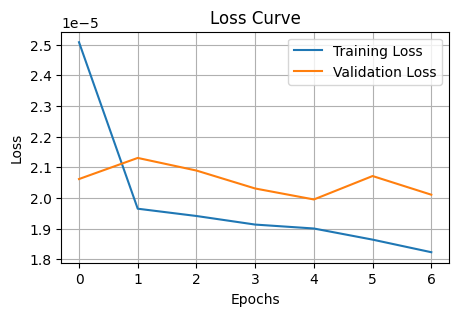

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.8410e-05 - val_loss: 2.0107e-05 - learning_rate: 5.0000e-05

Epoch 8: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
Epoch 8/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7944e-05
Epoch 8: val_loss did not improve from 0.00002


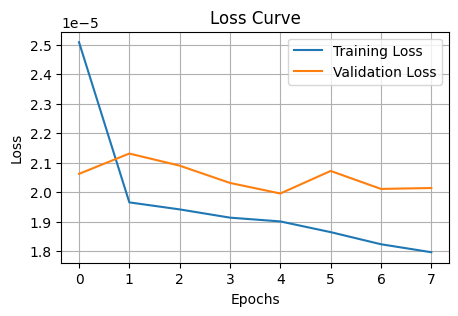

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.7944e-05 - val_loss: 2.0137e-05 - learning_rate: 5.0000e-05

Epoch 9: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
Epoch 9/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7878e-05
Epoch 9: val_loss improved from 0.00002 to 0.00002, saving model to /kaggle/working/best_model.keras


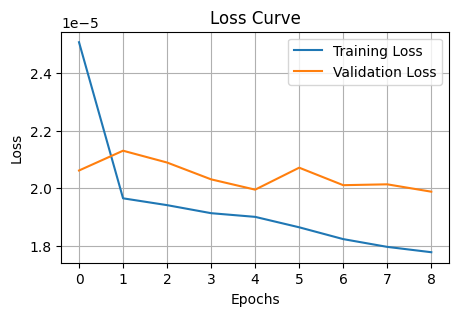

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.7878e-05 - val_loss: 1.9881e-05 - learning_rate: 5.0000e-05

Epoch 10: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
Epoch 10/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7201e-05
Epoch 10: val_loss improved from 0.00002 to 0.00002, saving model to /kaggle/working/best_model.keras


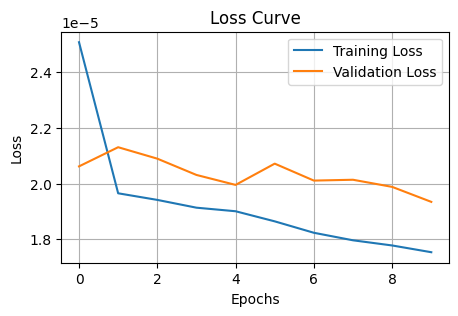

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.7201e-05 - val_loss: 1.9342e-05 - learning_rate: 5.0000e-05

Epoch 11: LearningRateScheduler setting learning rate to 2.499999936844688e-05.
Epoch 11/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7066e-05
Epoch 11: val_loss improved from 0.00002 to 0.00002, saving model to /kaggle/working/best_model.keras


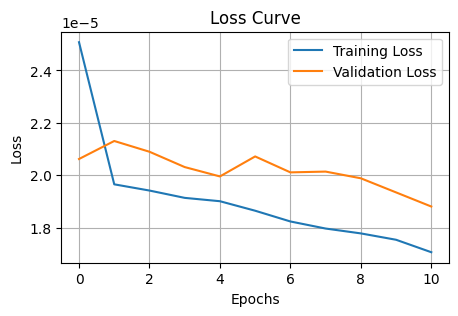

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.7066e-05 - val_loss: 1.8803e-05 - learning_rate: 2.5000e-05

Epoch 12: LearningRateScheduler setting learning rate to 2.499999936844688e-05.
Epoch 12/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6935e-05
Epoch 12: val_loss did not improve from 0.00002


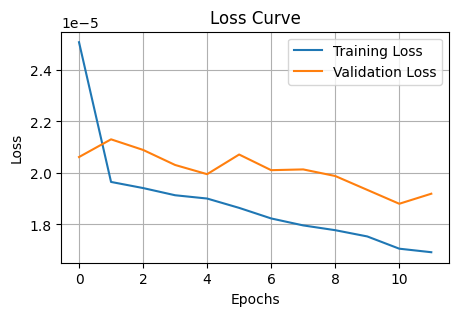

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.6935e-05 - val_loss: 1.9193e-05 - learning_rate: 2.5000e-05

Epoch 13: LearningRateScheduler setting learning rate to 2.499999936844688e-05.
Epoch 13/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6619e-05
Epoch 13: val_loss did not improve from 0.00002


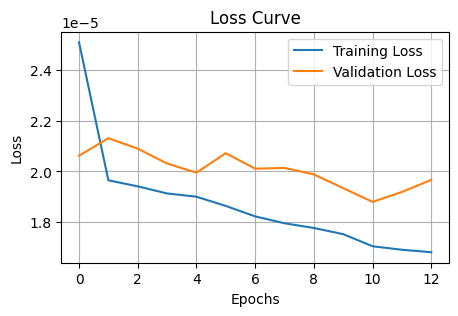

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.6620e-05 - val_loss: 1.9667e-05 - learning_rate: 2.5000e-05

Epoch 14: LearningRateScheduler setting learning rate to 2.499999936844688e-05.
Epoch 14/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6345e-05
Epoch 14: val_loss did not improve from 0.00002


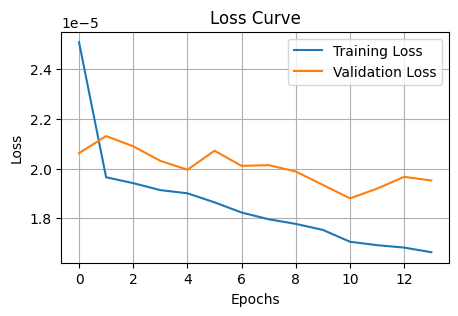

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.6345e-05 - val_loss: 1.9520e-05 - learning_rate: 2.5000e-05

Epoch 15: LearningRateScheduler setting learning rate to 2.499999936844688e-05.
Epoch 15/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6737e-05
Epoch 15: val_loss did not improve from 0.00002


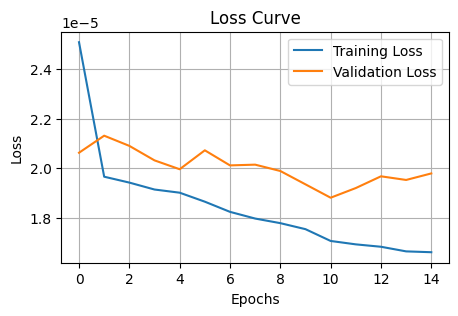

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.6737e-05 - val_loss: 1.9783e-05 - learning_rate: 2.5000e-05

Epoch 16: LearningRateScheduler setting learning rate to 1.249999968422344e-05.
Epoch 16/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6222e-05
Epoch 16: val_loss did not improve from 0.00002


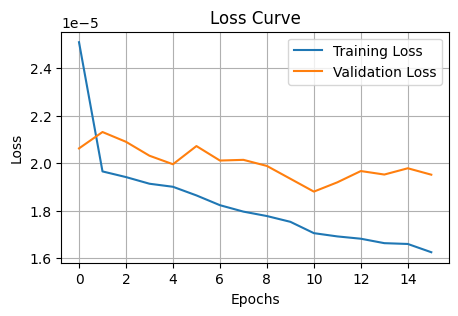

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.6222e-05 - val_loss: 1.9514e-05 - learning_rate: 1.2500e-05

Epoch 17: LearningRateScheduler setting learning rate to 1.249999968422344e-05.
Epoch 17/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6217e-05
Epoch 17: val_loss did not improve from 0.00002


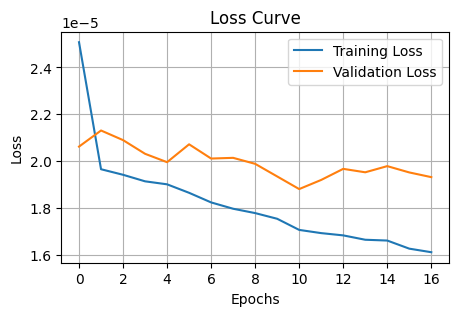

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.6217e-05 - val_loss: 1.9312e-05 - learning_rate: 1.2500e-05

Epoch 18: LearningRateScheduler setting learning rate to 1.249999968422344e-05.
Epoch 18/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5560e-05
Epoch 18: val_loss did not improve from 0.00002


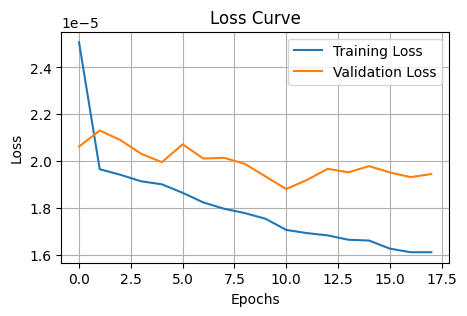

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.5562e-05 - val_loss: 1.9444e-05 - learning_rate: 1.2500e-05

Epoch 19: LearningRateScheduler setting learning rate to 1.249999968422344e-05.
Epoch 19/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6259e-05
Epoch 19: val_loss did not improve from 0.00002


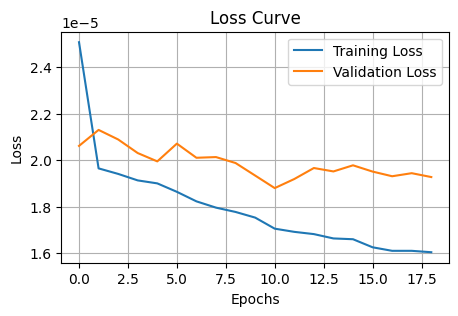

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.6257e-05 - val_loss: 1.9278e-05 - learning_rate: 1.2500e-05

Epoch 20: LearningRateScheduler setting learning rate to 1.249999968422344e-05.
Epoch 20/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5649e-05
Epoch 20: val_loss did not improve from 0.00002


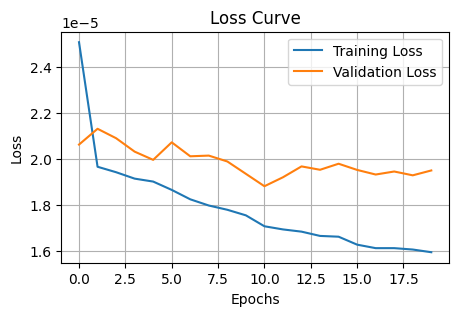

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.5650e-05 - val_loss: 1.9490e-05 - learning_rate: 1.2500e-05

Epoch 21: LearningRateScheduler setting learning rate to 6.24999984211172e-06.
Epoch 21/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5515e-05
Epoch 21: val_loss did not improve from 0.00002


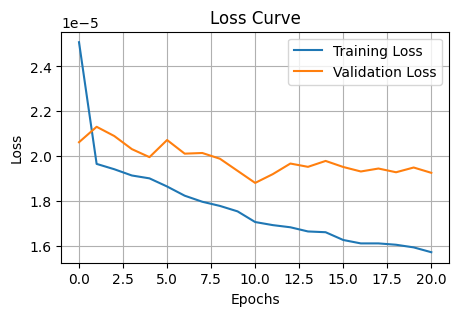

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.5516e-05 - val_loss: 1.9252e-05 - learning_rate: 6.2500e-06

Epoch 22: LearningRateScheduler setting learning rate to 6.24999984211172e-06.
Epoch 22/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5383e-05
Epoch 22: val_loss did not improve from 0.00002


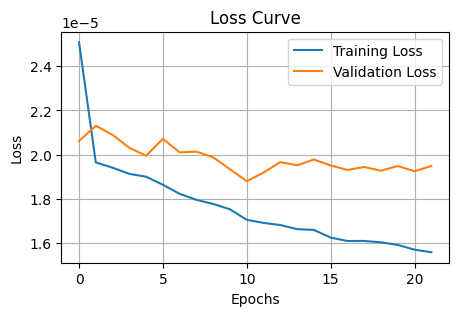

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.5383e-05 - val_loss: 1.9488e-05 - learning_rate: 6.2500e-06

Epoch 23: LearningRateScheduler setting learning rate to 6.24999984211172e-06.
Epoch 23/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5757e-05
Epoch 23: val_loss did not improve from 0.00002


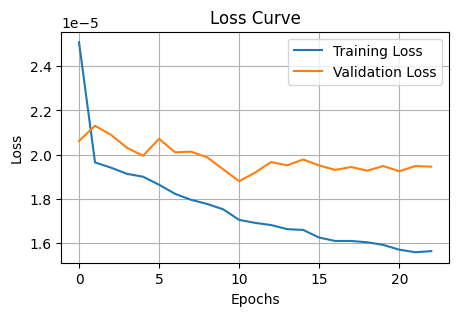

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.5756e-05 - val_loss: 1.9460e-05 - learning_rate: 6.2500e-06

Epoch 24: LearningRateScheduler setting learning rate to 6.24999984211172e-06.
Epoch 24/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5542e-05
Epoch 24: val_loss did not improve from 0.00002


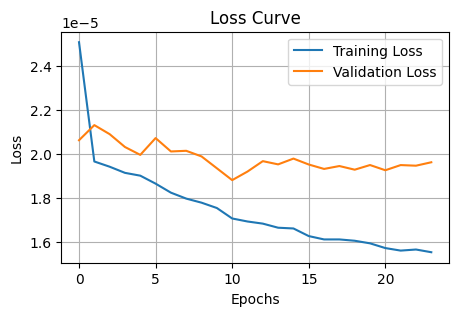

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.5541e-05 - val_loss: 1.9616e-05 - learning_rate: 6.2500e-06

Epoch 25: LearningRateScheduler setting learning rate to 6.24999984211172e-06.
Epoch 25/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5411e-05
Epoch 25: val_loss did not improve from 0.00002


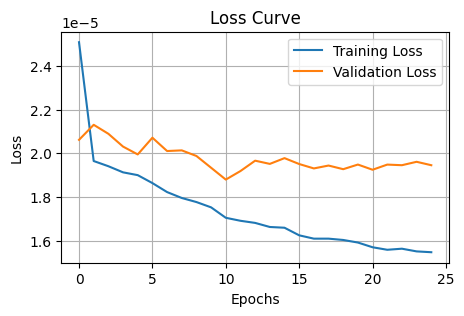

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.5411e-05 - val_loss: 1.9459e-05 - learning_rate: 6.2500e-06

Epoch 26: LearningRateScheduler setting learning rate to 3.12499992105586e-06.
Epoch 26/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5524e-05
Epoch 26: val_loss did not improve from 0.00002


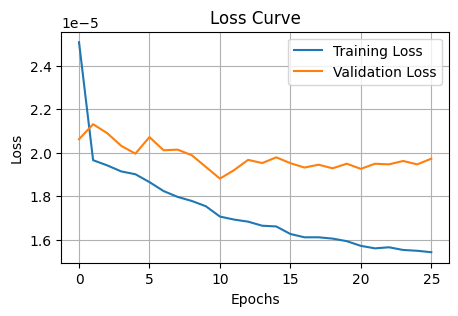

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.5523e-05 - val_loss: 1.9720e-05 - learning_rate: 3.1250e-06

Epoch 27: LearningRateScheduler setting learning rate to 3.12499992105586e-06.
Epoch 27/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5486e-05
Epoch 27: val_loss did not improve from 0.00002


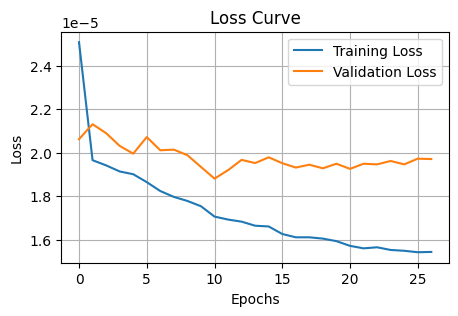

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.5486e-05 - val_loss: 1.9705e-05 - learning_rate: 3.1250e-06

Epoch 28: LearningRateScheduler setting learning rate to 3.12499992105586e-06.
Epoch 28/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5549e-05
Epoch 28: val_loss did not improve from 0.00002


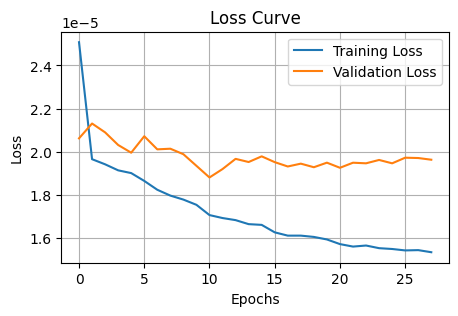

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.5548e-05 - val_loss: 1.9627e-05 - learning_rate: 3.1250e-06

Epoch 29: LearningRateScheduler setting learning rate to 3.12499992105586e-06.
Epoch 29/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5854e-05
Epoch 29: val_loss did not improve from 0.00002


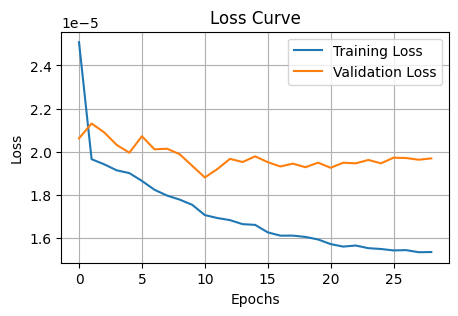

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.5853e-05 - val_loss: 1.9687e-05 - learning_rate: 3.1250e-06

Epoch 30: LearningRateScheduler setting learning rate to 3.12499992105586e-06.
Epoch 30/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5545e-05
Epoch 30: val_loss did not improve from 0.00002


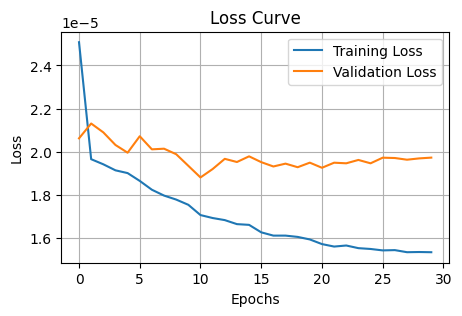

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.5544e-05 - val_loss: 1.9723e-05 - learning_rate: 3.1250e-06

Epoch 31: LearningRateScheduler setting learning rate to 1.56249996052793e-06.
Epoch 31/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5209e-05
Epoch 31: val_loss did not improve from 0.00002


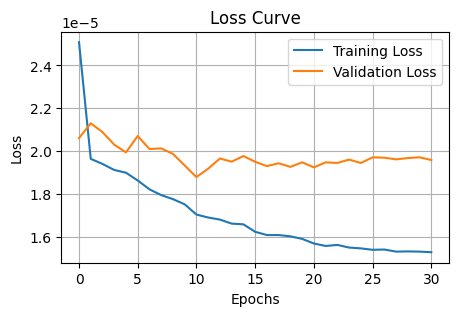

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.5209e-05 - val_loss: 1.9597e-05 - learning_rate: 1.5625e-06


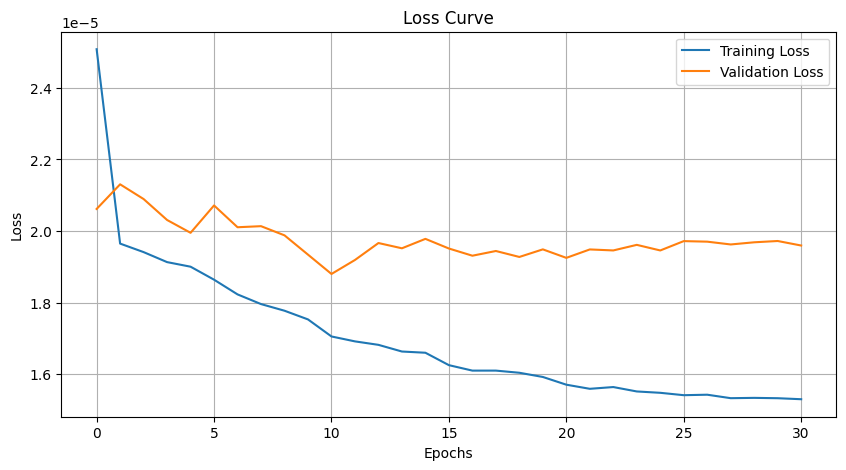

483/483 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.9493e-05
Test Loss: 1.9949156921938993e-05


In [ ]:
# Model: Bi-LSTM with Attention
# Input: Review and Rating
# Output: Total Price and Frequency

from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, Callback, ReduceLROnPlateau
from keras.models import Model
from keras.layers import Embedding, LSTM, Dense, Concatenate, Input, Flatten, Bidirectional, Attention, Dropout
import matplotlib.pyplot as plt
import tensorflow as tf

# Learning rate calculation
def lr_schedule(epoch, lr):
    initial_lr = 0.0001  # Set the initial learning rate
    decay_rate = 0.5
    decay_step = 5
    if epoch == 0:
        return initial_lr
    if epoch % decay_step == 0:
        lr = lr * decay_rate
    return lr

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Model checkpoint callback
model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Dissertation Customer Segmentation/BILSTM_Review_Rating_best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)
# model_checkpoint = ModelCheckpoint(
#     '/kaggle/working/best_model.keras',
#     monitor='val_loss',
#     save_best_only=True,
#     save_weights_only=False,
#     mode='min',
#     verbose=1
# )

# Custom plotting callback
class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.epochs = []
        self.losses = []
        self.val_losses = []
        plt.ion()

    def on_epoch_end(self, epoch, logs={}):
        self.epochs.append(epoch)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

        plt.figure(figsize=(5, 3))
        plt.plot(self.epochs, self.losses, label='Training Loss')
        plt.plot(self.epochs, self.val_losses, label='Validation Loss')
        plt.title('Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.draw()
        plt.pause(0.001)
        plt.show()

plot_losses = PlotLosses()

input_avg_rating = Input(shape=(1,))
input_review = Input(shape=(100,))

x = Embedding(input_dim=5000, output_dim=128, input_length=100)(input_review)
# x = LSTM(128, return_sequences=True)(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
attention = Attention()([x, x])
x = Flatten()(attention)
# x = Flatten()(x)

# Combine numerical and text inputs
combined = Concatenate()([input_avg_rating, x])

# Dense layers
combined = Dense(64, activation='relu')(combined)
combined = Dropout(0.2)(combined)  # Dropout layer with 20% dropout rate
combined = Dense(32, activation='relu')(combined)
combined = Dropout(0.2)(combined)  # Dropout layer with 20% dropout rate
output = Dense(1)(combined)  # Single unit for the output layer

# Create the model
model = Model(inputs=[input_avg_rating, input_review], outputs=output)

# Compile the model with the initial learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

model.summary()

history = model.fit(
    [X_avg_rating_train, X_review_train],
    y_train_updated,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint, plot_losses]
)

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
loss = model.evaluate([X_avg_rating_test, X_review_test], y_test_updated)
print(f"Test Loss: {loss}")


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, 100, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 100, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │       819,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,592,961 (6.08 MB)

 Trainable params: 1,592,961 (6.08 MB)

 Non-trainable params: 0 (0.00 B)


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.4920e-05
Epoch 1: val_loss improved from inf to 0.00002, saving model to /kaggle/working/best_model.keras


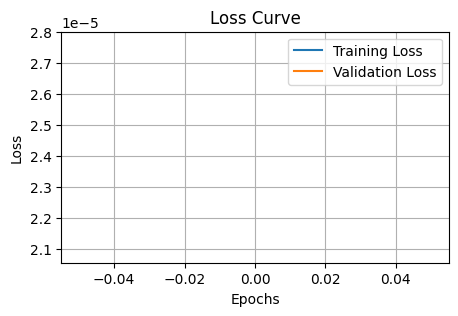

668/668 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 5.4757e-05 - val_loss: 2.0887e-05 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/100
663/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9330e-05
Epoch 2: val_loss improved from 0.00002 to 0.00002, saving model to /kaggle/working/best_model.keras


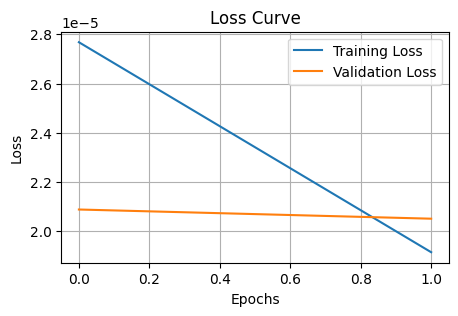

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.9329e-05 - val_loss: 2.0514e-05 - learning_rate: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7869e-05
Epoch 3: val_loss did not improve from 0.00002


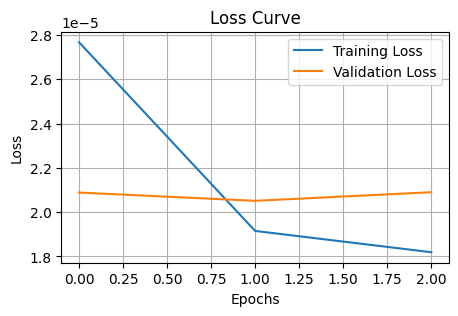

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.7871e-05 - val_loss: 2.0901e-05 - learning_rate: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 4/100
663/668 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8057e-05
Epoch 4: val_loss improved from 0.00002 to 0.00002, saving model to /kaggle/working/best_model.keras


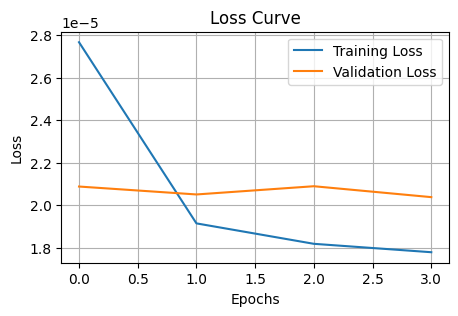

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.8055e-05 - val_loss: 2.0388e-05 - learning_rate: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 5/100
663/668 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6997e-05
Epoch 5: val_loss did not improve from 0.00002


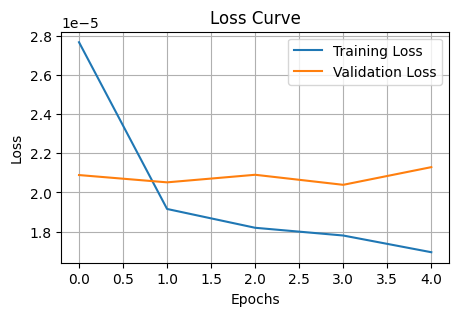

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.6997e-05 - val_loss: 2.1291e-05 - learning_rate: 1.0000e-04

Epoch 6: LearningRateScheduler setting learning rate to 7.999999797903001e-05.
Epoch 6/100
664/668 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6958e-05
Epoch 6: val_loss improved from 0.00002 to 0.00002, saving model to /kaggle/working/best_model.keras


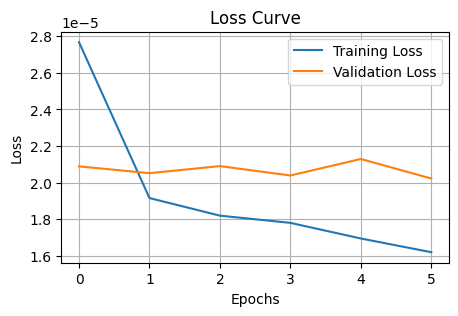

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.6952e-05 - val_loss: 2.0222e-05 - learning_rate: 8.0000e-05

Epoch 7: LearningRateScheduler setting learning rate to 7.999999797903001e-05.
Epoch 7/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5451e-05
Epoch 7: val_loss improved from 0.00002 to 0.00002, saving model to /kaggle/working/best_model.keras


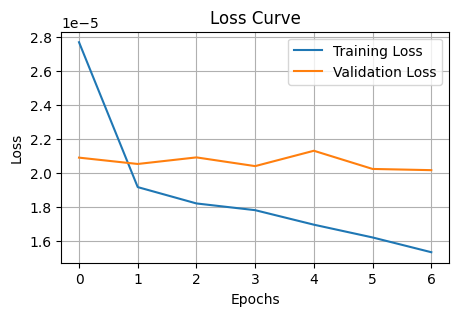

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.5451e-05 - val_loss: 2.0150e-05 - learning_rate: 8.0000e-05

Epoch 8: LearningRateScheduler setting learning rate to 7.999999797903001e-05.
Epoch 8/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4888e-05
Epoch 8: val_loss did not improve from 0.00002


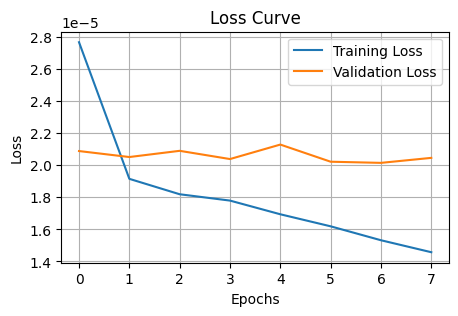

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.4886e-05 - val_loss: 2.0462e-05 - learning_rate: 8.0000e-05

Epoch 9: LearningRateScheduler setting learning rate to 7.999999797903001e-05.
Epoch 9/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4025e-05
Epoch 9: val_loss did not improve from 0.00002


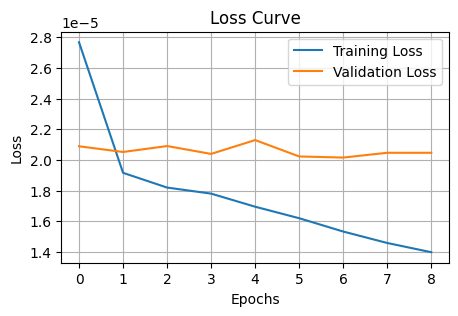

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.4025e-05 - val_loss: 2.0461e-05 - learning_rate: 8.0000e-05

Epoch 10: LearningRateScheduler setting learning rate to 7.999999797903001e-05.
Epoch 10/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3178e-05
Epoch 10: val_loss did not improve from 0.00002


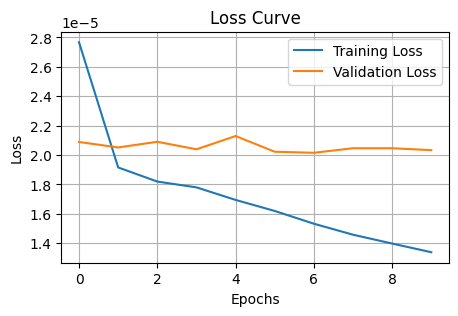

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.3178e-05 - val_loss: 2.0330e-05 - learning_rate: 8.0000e-05

Epoch 11: LearningRateScheduler setting learning rate to 6.399999838322402e-05.
Epoch 11/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2645e-05
Epoch 11: val_loss did not improve from 0.00002


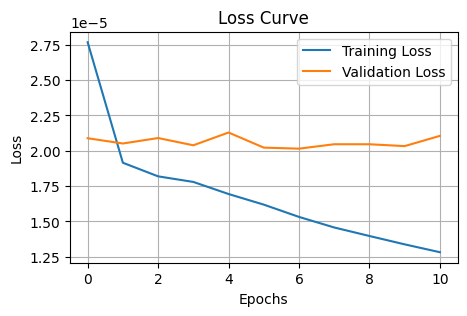

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.2645e-05 - val_loss: 2.1054e-05 - learning_rate: 6.4000e-05

Epoch 12: LearningRateScheduler setting learning rate to 6.399999983841553e-05.
Epoch 12/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1838e-05
Epoch 12: val_loss did not improve from 0.00002


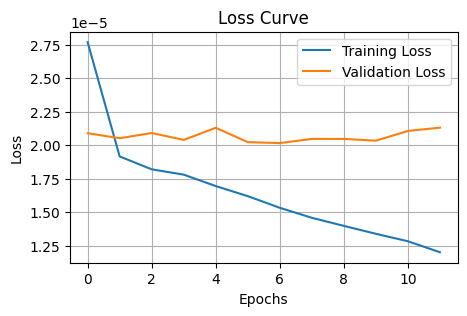

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.1839e-05 - val_loss: 2.1302e-05 - learning_rate: 6.4000e-05

Epoch 13: LearningRateScheduler setting learning rate to 6.399999983841553e-05.
Epoch 13/100
664/668 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1372e-05
Epoch 13: val_loss did not improve from 0.00002


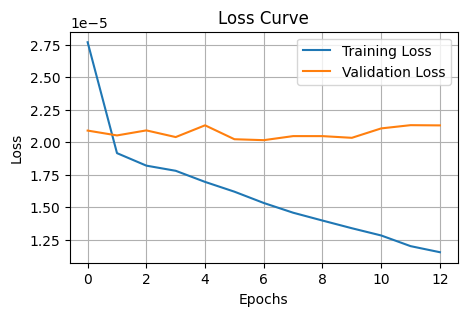

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.1374e-05 - val_loss: 2.1285e-05 - learning_rate: 6.4000e-05

Epoch 14: LearningRateScheduler setting learning rate to 6.399999983841553e-05.
Epoch 14/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1132e-05
Epoch 14: val_loss did not improve from 0.00002


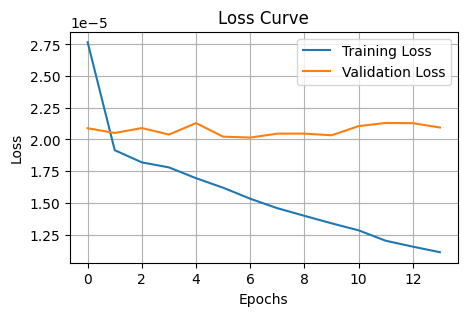

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.1131e-05 - val_loss: 2.0944e-05 - learning_rate: 6.4000e-05

Epoch 15: LearningRateScheduler setting learning rate to 6.399999983841553e-05.
Epoch 15/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0646e-05
Epoch 15: val_loss did not improve from 0.00002


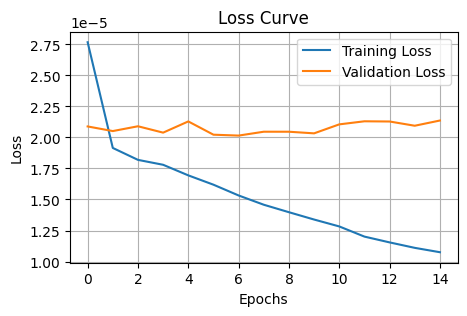

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.0647e-05 - val_loss: 2.1364e-05 - learning_rate: 6.4000e-05

Epoch 16: LearningRateScheduler setting learning rate to 5.119999987073243e-05.
Epoch 16/100
663/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0316e-05
Epoch 16: val_loss did not improve from 0.00002


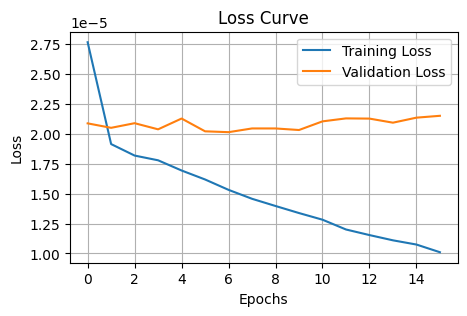

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.0314e-05 - val_loss: 2.1519e-05 - learning_rate: 5.1200e-05

Epoch 17: LearningRateScheduler setting learning rate to 5.120000059832819e-05.
Epoch 17/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.8863e-06
Epoch 17: val_loss did not improve from 0.00002


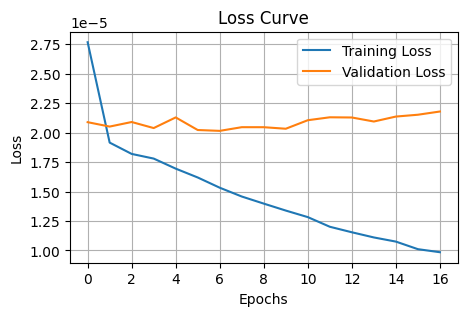

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 9.8861e-06 - val_loss: 2.1793e-05 - learning_rate: 5.1200e-05

Epoch 18: LearningRateScheduler setting learning rate to 5.120000059832819e-05.
Epoch 18/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.5814e-06
Epoch 18: val_loss did not improve from 0.00002


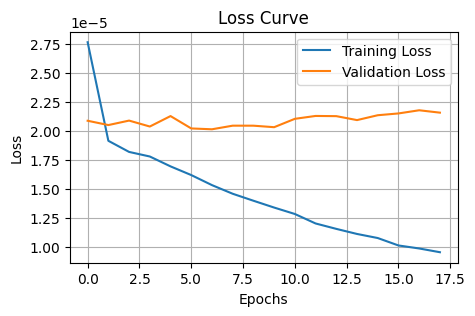

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 9.5810e-06 - val_loss: 2.1587e-05 - learning_rate: 5.1200e-05

Epoch 19: LearningRateScheduler setting learning rate to 5.120000059832819e-05.
Epoch 19/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.5160e-06
Epoch 19: val_loss did not improve from 0.00002


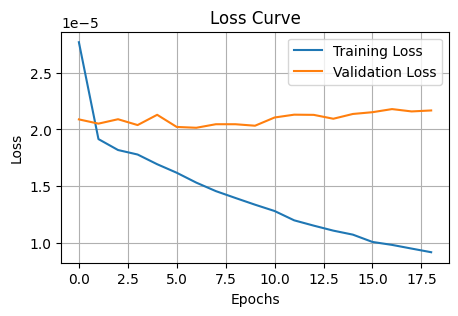

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 9.5146e-06 - val_loss: 2.1673e-05 - learning_rate: 5.1200e-05

Epoch 20: LearningRateScheduler setting learning rate to 5.120000059832819e-05.
Epoch 20/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.0673e-06
Epoch 20: val_loss did not improve from 0.00002


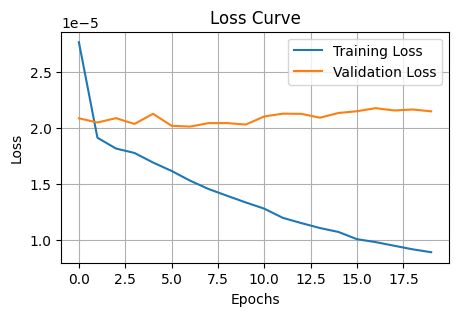

668/668 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 9.0667e-06 - val_loss: 2.1513e-05 - learning_rate: 5.1200e-05

Epoch 21: LearningRateScheduler setting learning rate to 4.0960000478662555e-05.
Epoch 21/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.3886e-06
Epoch 21: val_loss did not improve from 0.00002


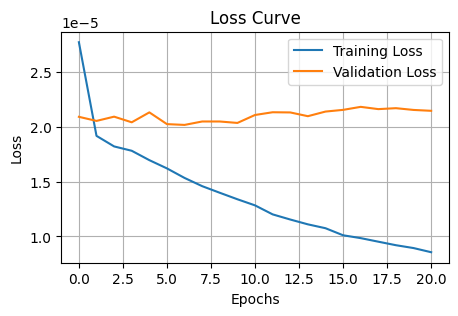

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 8.3894e-06 - val_loss: 2.1433e-05 - learning_rate: 4.0960e-05

Epoch 22: LearningRateScheduler setting learning rate to 4.095999975106679e-05.
Epoch 22/100
662/668 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.5162e-06
Epoch 22: val_loss did not improve from 0.00002


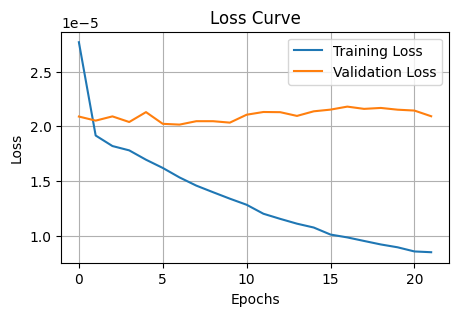

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 8.5159e-06 - val_loss: 2.0914e-05 - learning_rate: 4.0960e-05

Epoch 23: LearningRateScheduler setting learning rate to 4.095999975106679e-05.
Epoch 23/100
663/668 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.2645e-06
Epoch 23: val_loss did not improve from 0.00002


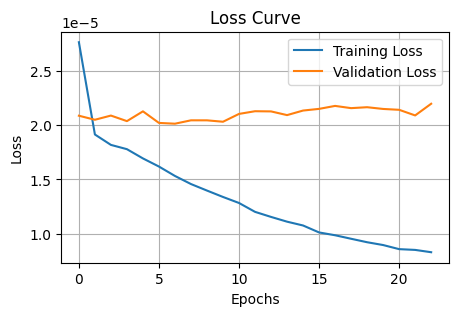

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 8.2647e-06 - val_loss: 2.1993e-05 - learning_rate: 4.0960e-05

Epoch 24: LearningRateScheduler setting learning rate to 4.095999975106679e-05.
Epoch 24/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.8606e-06
Epoch 24: val_loss did not improve from 0.00002


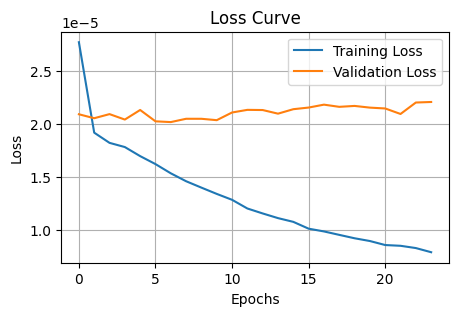

668/668 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 7.8607e-06 - val_loss: 2.2044e-05 - learning_rate: 4.0960e-05

Epoch 25: LearningRateScheduler setting learning rate to 4.095999975106679e-05.
Epoch 25/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.6382e-06
Epoch 25: val_loss did not improve from 0.00002


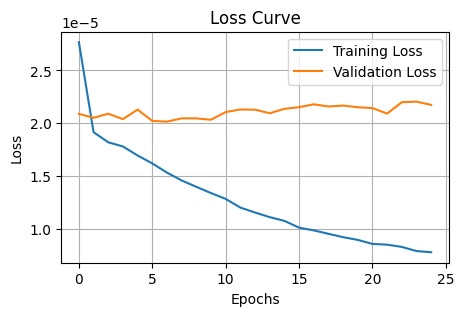

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 7.6390e-06 - val_loss: 2.1741e-05 - learning_rate: 4.0960e-05

Epoch 26: LearningRateScheduler setting learning rate to 3.2767999800853435e-05.
Epoch 26/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.7219e-06
Epoch 26: val_loss did not improve from 0.00002


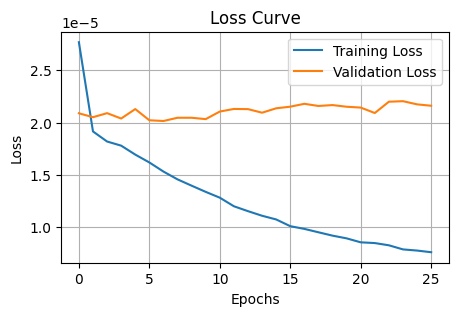

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 7.7213e-06 - val_loss: 2.1608e-05 - learning_rate: 3.2768e-05

Epoch 27: LearningRateScheduler setting learning rate to 3.276799907325767e-05.
Epoch 27/100
662/668 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.2314e-06
Epoch 27: val_loss did not improve from 0.00002


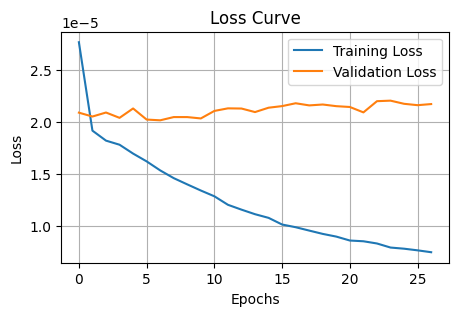

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 7.2335e-06 - val_loss: 2.1715e-05 - learning_rate: 3.2768e-05


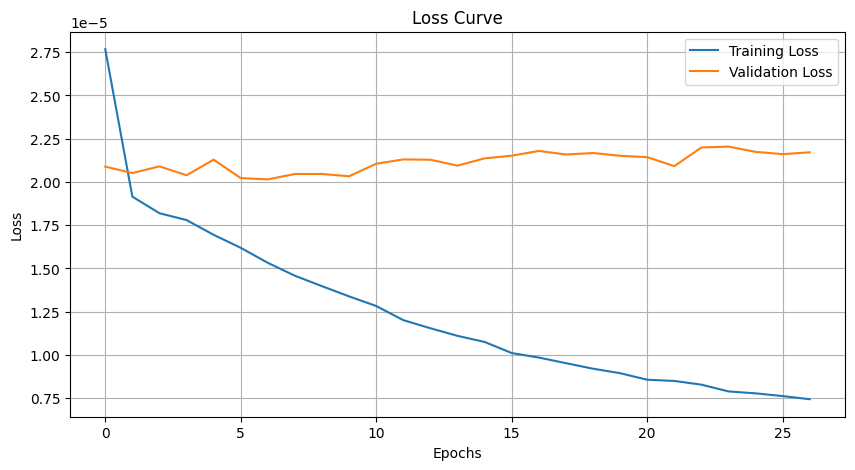

483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.9428e-05
Test Loss: 2.0080371541553177e-05


In [ ]:
# Model: LSTM
# Input: Review
# Output: Total Price and Frequency

from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, Callback, ReduceLROnPlateau
from keras.models import Model
from keras.layers import Embedding, LSTM, Dense, Concatenate, Input, Flatten, Bidirectional, Attention, Dropout
import matplotlib.pyplot as plt
import tensorflow as tf

# Learning rate calculation
def lr_schedule(epoch, lr):
    initial_lr = 0.0001
    decay_rate = 0.8
    decay_step = 5
    if epoch == 0:
        return initial_lr
    if epoch % decay_step == 0:
        lr = lr * decay_rate
    return lr

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Model checkpoint callback
model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Dissertation Customer Segmentation/LSTM_Review_best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)
# model_checkpoint = ModelCheckpoint(
#     '/kaggle/working/best_model.keras',
#     monitor='val_loss',
#     save_best_only=True,
#     save_weights_only=False,
#     mode='min',
#     verbose=1
# )

# Custom plotting callback
class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.epochs = []
        self.losses = []
        self.val_losses = []
        plt.ion()

    def on_epoch_end(self, epoch, logs={}):
        self.epochs.append(epoch)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

        plt.figure(figsize=(5, 3))
        plt.plot(self.epochs, self.losses, label='Training Loss')
        plt.plot(self.epochs, self.val_losses, label='Validation Loss')
        plt.title('Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.draw()
        plt.pause(0.001)
        plt.show()

plot_losses = PlotLosses()

# input_avg_rating = Input(shape=(1,))
input_review = Input(shape=(100,))

x = Embedding(input_dim=5000, output_dim=128, input_length=100)(input_review)
x = LSTM(128, return_sequences=True)(x)
# attention = Attention()([x, x])
# x = Flatten()(attention)
x = Flatten()(x)

# Combine numerical and text inputs
combined = Concatenate()([input_avg_rating, x])

# Dense layers
combined = Dense(64, activation='relu')(x)
combined = Dropout(0.2)(combined)  # Dropout layer with 20% dropout rate
combined = Dense(32, activation='relu')(combined)
combined = Dropout(0.2)(combined)  # Dropout layer with 20% dropout rate
output = Dense(1)(combined)  # Single unit for the output layer

# Create the model
model = Model(inputs=input_review, outputs=output)

# Compile the model with the initial learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

model.summary()

history = model.fit(
    X_review_train,
    y_train_updated,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint, plot_losses]
)

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
loss = model.evaluate(X_review_test, y_test_updated)
print(f"Test Loss: {loss}")


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 100, 128)  │    640,000 │ input_layer_11[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 100, 128)  │    131,584 │ embedding_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_3         │ (None, 100, 128)  │          0 │ lstm_7[0][0],     │
│ (Attention)         │                   │            │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 12800)     │          0 │ attention_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 64)        │    819,264 │ flatten_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64)        │          0 │ dense_21[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 32)        │      2,080 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 32)        │          0 │ dense_22[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 1)         │         33 │ dropout_15[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,592,961 (6.08 MB)

 Trainable params: 1,592,961 (6.08 MB)

 Non-trainable params: 0 (0.00 B)


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9711e-05
Epoch 1: val_loss improved from inf to 0.00002, saving model to /kaggle/working/best_model.keras


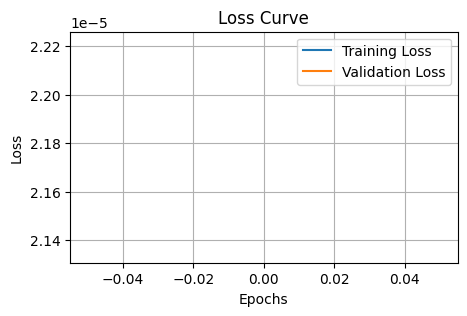

668/668 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 2.9689e-05 - val_loss: 2.1351e-05 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/100
663/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9324e-05
Epoch 2: val_loss did not improve from 0.00002


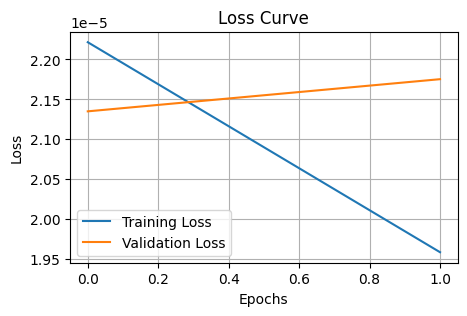

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.9327e-05 - val_loss: 2.1754e-05 - learning_rate: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9432e-05
Epoch 3: val_loss improved from 0.00002 to 0.00002, saving model to /kaggle/working/best_model.keras


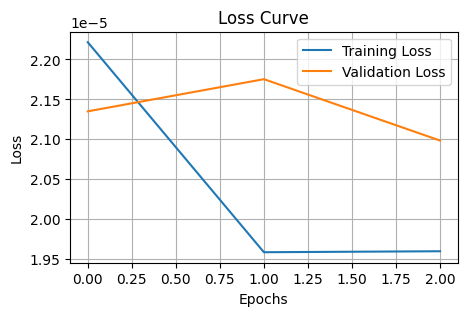

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.9432e-05 - val_loss: 2.0985e-05 - learning_rate: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 4/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9772e-05
Epoch 4: val_loss did not improve from 0.00002


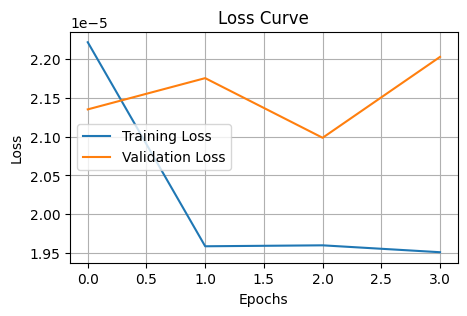

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.9771e-05 - val_loss: 2.2027e-05 - learning_rate: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 5/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0397e-05
Epoch 5: val_loss did not improve from 0.00002


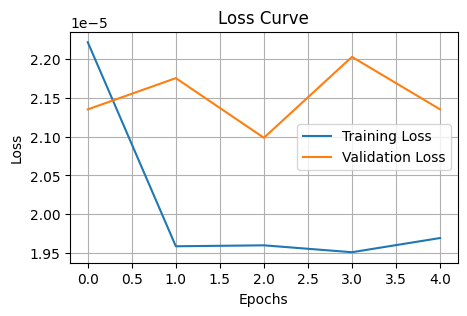

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 2.0393e-05 - val_loss: 2.1352e-05 - learning_rate: 1.0000e-04

Epoch 6: LearningRateScheduler setting learning rate to 7.999999797903001e-05.
Epoch 6/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9016e-05
Epoch 6: val_loss did not improve from 0.00002


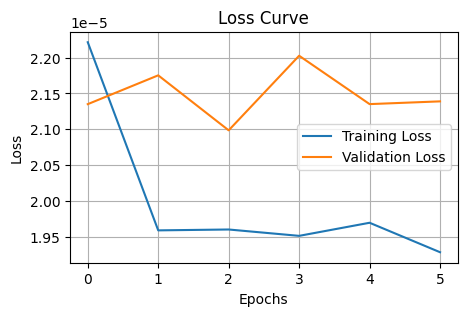

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.9018e-05 - val_loss: 2.1390e-05 - learning_rate: 8.0000e-05

Epoch 7: LearningRateScheduler setting learning rate to 7.999999797903001e-05.
Epoch 7/100
663/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9205e-05
Epoch 7: val_loss did not improve from 0.00002


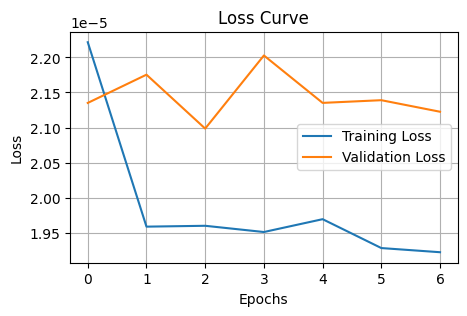

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.9205e-05 - val_loss: 2.1225e-05 - learning_rate: 8.0000e-05

Epoch 8: LearningRateScheduler setting learning rate to 7.999999797903001e-05.
Epoch 8/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9954e-05
Epoch 8: val_loss did not improve from 0.00002


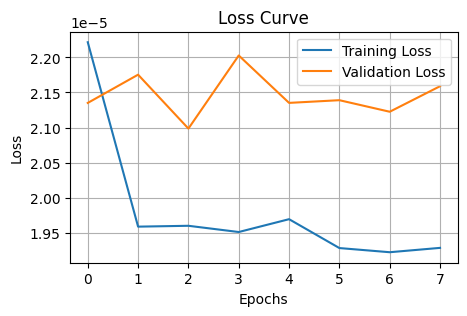

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.9950e-05 - val_loss: 2.1589e-05 - learning_rate: 8.0000e-05

Epoch 9: LearningRateScheduler setting learning rate to 7.999999797903001e-05.
Epoch 9/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8632e-05
Epoch 9: val_loss did not improve from 0.00002


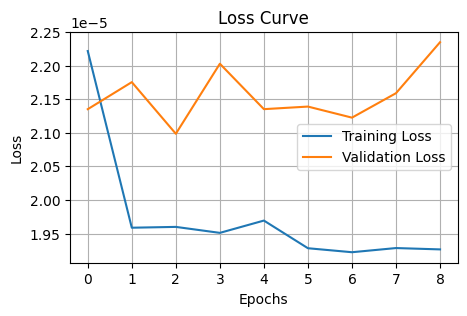

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.8635e-05 - val_loss: 2.2347e-05 - learning_rate: 8.0000e-05

Epoch 10: LearningRateScheduler setting learning rate to 7.999999797903001e-05.
Epoch 10/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9250e-05
Epoch 10: val_loss did not improve from 0.00002


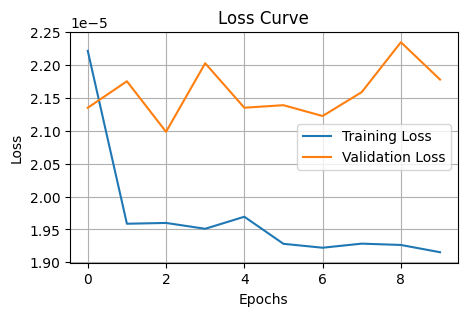

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.9249e-05 - val_loss: 2.1780e-05 - learning_rate: 8.0000e-05

Epoch 11: LearningRateScheduler setting learning rate to 6.399999838322402e-05.
Epoch 11/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8796e-05
Epoch 11: val_loss did not improve from 0.00002


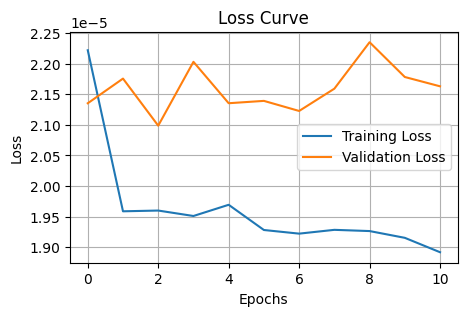

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.8796e-05 - val_loss: 2.1628e-05 - learning_rate: 6.4000e-05

Epoch 12: LearningRateScheduler setting learning rate to 6.399999983841553e-05.
Epoch 12/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8723e-05
Epoch 12: val_loss did not improve from 0.00002


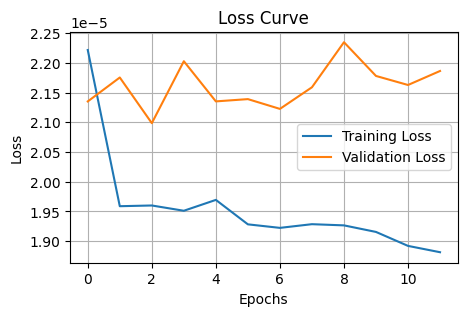

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.8724e-05 - val_loss: 2.1863e-05 - learning_rate: 6.4000e-05

Epoch 13: LearningRateScheduler setting learning rate to 6.399999983841553e-05.
Epoch 13/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8699e-05
Epoch 13: val_loss did not improve from 0.00002


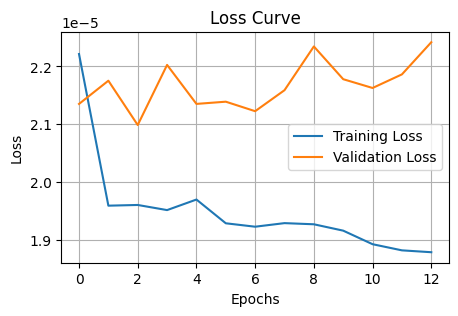

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.8699e-05 - val_loss: 2.2421e-05 - learning_rate: 6.4000e-05

Epoch 14: LearningRateScheduler setting learning rate to 6.399999983841553e-05.
Epoch 14/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8842e-05
Epoch 14: val_loss did not improve from 0.00002


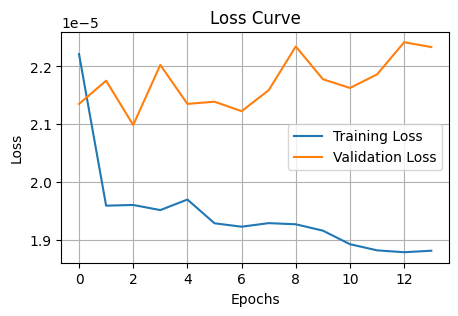

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.8842e-05 - val_loss: 2.2337e-05 - learning_rate: 6.4000e-05

Epoch 15: LearningRateScheduler setting learning rate to 6.399999983841553e-05.
Epoch 15/100
664/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8945e-05
Epoch 15: val_loss did not improve from 0.00002


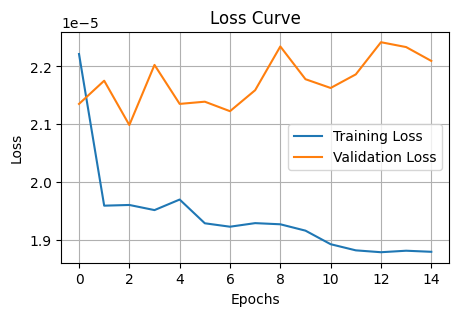

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.8944e-05 - val_loss: 2.2096e-05 - learning_rate: 6.4000e-05

Epoch 16: LearningRateScheduler setting learning rate to 5.119999987073243e-05.
Epoch 16/100
664/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8450e-05
Epoch 16: val_loss did not improve from 0.00002


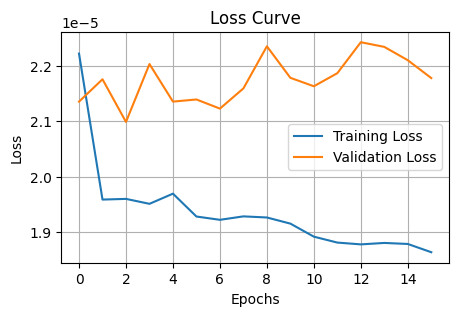

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.8452e-05 - val_loss: 2.1775e-05 - learning_rate: 5.1200e-05

Epoch 17: LearningRateScheduler setting learning rate to 5.120000059832819e-05.
Epoch 17/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8527e-05
Epoch 17: val_loss did not improve from 0.00002


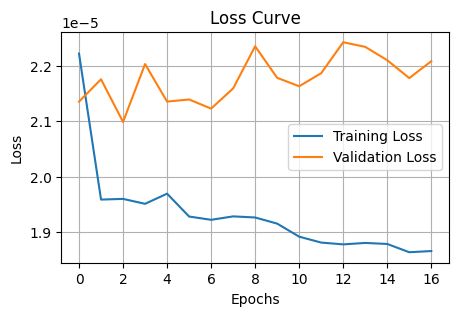

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 1.8528e-05 - val_loss: 2.2079e-05 - learning_rate: 5.1200e-05

Epoch 18: LearningRateScheduler setting learning rate to 5.120000059832819e-05.
Epoch 18/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8331e-05
Epoch 18: val_loss did not improve from 0.00002


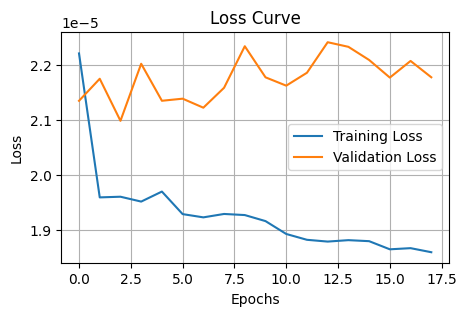

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.8332e-05 - val_loss: 2.1781e-05 - learning_rate: 5.1200e-05

Epoch 19: LearningRateScheduler setting learning rate to 5.120000059832819e-05.
Epoch 19/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8510e-05
Epoch 19: val_loss did not improve from 0.00002


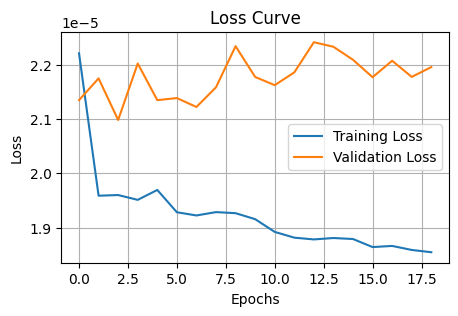

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.8510e-05 - val_loss: 2.1962e-05 - learning_rate: 5.1200e-05

Epoch 20: LearningRateScheduler setting learning rate to 5.120000059832819e-05.
Epoch 20/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8748e-05
Epoch 20: val_loss did not improve from 0.00002


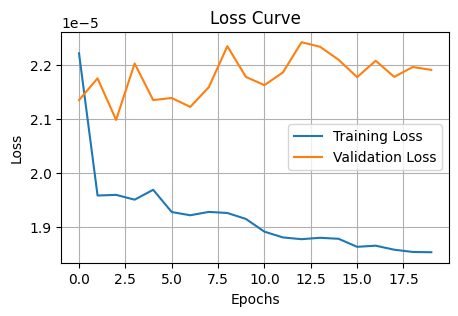

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.8747e-05 - val_loss: 2.1909e-05 - learning_rate: 5.1200e-05

Epoch 21: LearningRateScheduler setting learning rate to 4.0960000478662555e-05.
Epoch 21/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9052e-05
Epoch 21: val_loss did not improve from 0.00002


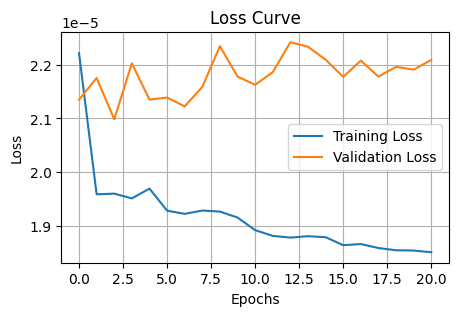

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.9049e-05 - val_loss: 2.2091e-05 - learning_rate: 4.0960e-05

Epoch 22: LearningRateScheduler setting learning rate to 4.095999975106679e-05.
Epoch 22/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8945e-05
Epoch 22: val_loss did not improve from 0.00002


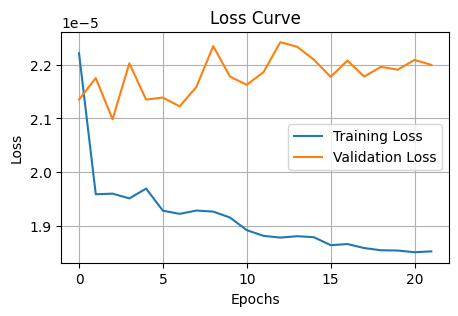

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.8943e-05 - val_loss: 2.1999e-05 - learning_rate: 4.0960e-05

Epoch 23: LearningRateScheduler setting learning rate to 4.095999975106679e-05.
Epoch 23/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8243e-05
Epoch 23: val_loss did not improve from 0.00002


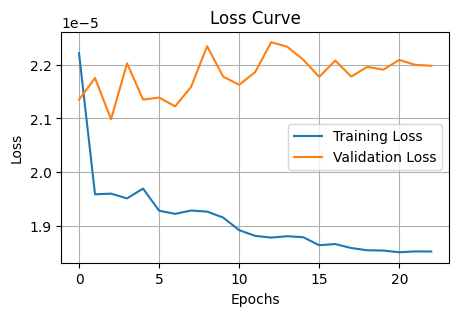

668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.8244e-05 - val_loss: 2.1982e-05 - learning_rate: 4.0960e-05


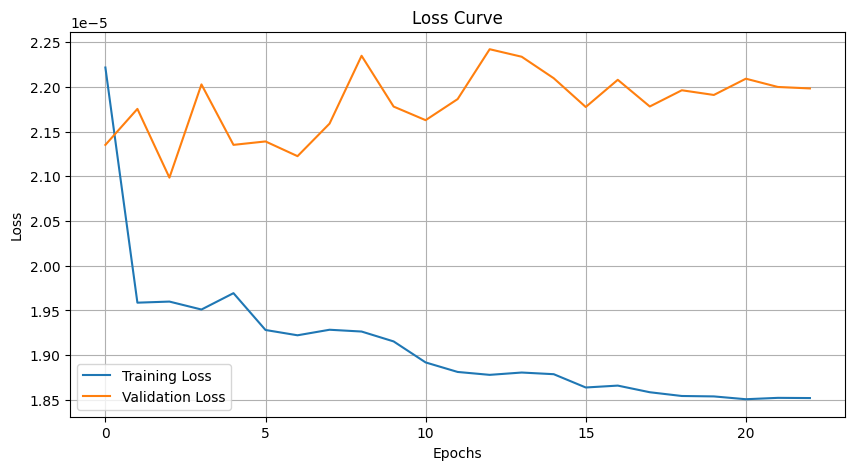

483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.0575e-05
Test Loss: 2.1190598999965005e-05


In [ ]:
# Model: LSTM with Attention
# Input: Review
# Output: Total Price and Frequency

from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, Callback, ReduceLROnPlateau
from keras.models import Model
from keras.layers import Embedding, LSTM, Dense, Concatenate, Input, Flatten, Bidirectional, Attention, Dropout
import matplotlib.pyplot as plt
import tensorflow as tf

# Learning rate calculation
def lr_schedule(epoch, lr):
    initial_lr = 0.0001
    decay_rate = 0.8
    decay_step = 5
    if epoch == 0:
        return initial_lr
    if epoch % decay_step == 0:
        lr = lr * decay_rate
    return lr

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Model checkpoint callback
model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Dissertation Customer Segmentation/LSTM_attention_Review_best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)
# model_checkpoint = ModelCheckpoint(
#     '/kaggle/working/best_model.keras',
#     monitor='val_loss',
#     save_best_only=True,
#     save_weights_only=False,
#     mode='min',
#     verbose=1
# )

# Custom plotting callback
class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.epochs = []
        self.losses = []
        self.val_losses = []
        plt.ion()

    def on_epoch_end(self, epoch, logs={}):
        self.epochs.append(epoch)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

        plt.figure(figsize=(5, 3))
        plt.plot(self.epochs, self.losses, label='Training Loss')
        plt.plot(self.epochs, self.val_losses, label='Validation Loss')
        plt.title('Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.draw()
        plt.pause(0.001)
        plt.show()

plot_losses = PlotLosses()

# input_avg_rating = Input(shape=(1,))
input_review = Input(shape=(100,))

x = Embedding(input_dim=5000, output_dim=128, input_length=100)(input_review)
x = LSTM(128, return_sequences=True)(x)
attention = Attention()([x, x])
x = Flatten()(attention)
# x = Flatten()(x)

# Combine numerical and text inputs
combined = Concatenate()([input_avg_rating, x])

# Dense layers
combined = Dense(64, activation='relu')(x)
combined = Dropout(0.2)(combined)  # Dropout layer with 20% dropout rate
combined = Dense(32, activation='relu')(combined)
combined = Dropout(0.2)(combined)  # Dropout layer with 20% dropout rate
output = Dense(1)(combined)  # Single unit for the output layer

# Create the model
model = Model(inputs=input_review, outputs=output)

# Compile the model with the initial learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

model.summary()

history = model.fit(
    X_review_train,
    y_train_updated,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint, plot_losses]
)

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
loss = model.evaluate(X_review_test, y_test_updated)
print(f"Test Loss: {loss}")


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 100, 128)  │    640,000 │ input_layer_12[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 100, 256)  │    263,168 │ embedding_8[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_4         │ (None, 100, 256)  │          0 │ bidirectional_1[… │
│ (Attention)         │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 25600)     │          0 │ attention_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 64)        │  1,638,464 │ flatten_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 64)        │          0 │ dense_24[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 32)        │      2,080 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 32)        │          0 │ dense_25[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 1)         │         33 │ dropout_17[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,543,745 (9.70 MB)

 Trainable params: 2,543,745 (9.70 MB)

 Non-trainable params: 0 (0.00 B)


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.9270e-05
Epoch 1: val_loss improved from inf to 0.00002, saving model to /kaggle/working/best_model.keras


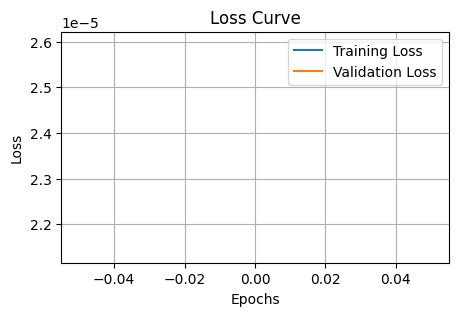

668/668 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 4.9131e-05 - val_loss: 2.1391e-05 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.0081e-05
Epoch 2: val_loss did not improve from 0.00002


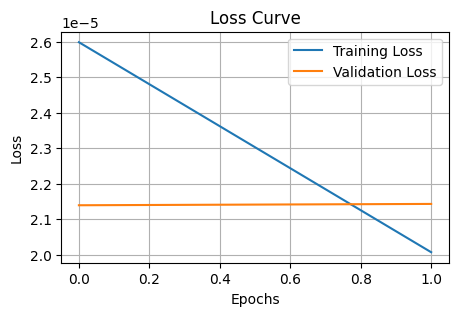

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 2.0081e-05 - val_loss: 2.1428e-05 - learning_rate: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.9834e-05
Epoch 3: val_loss did not improve from 0.00002


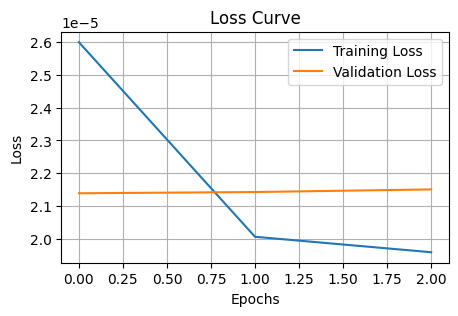

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.9833e-05 - val_loss: 2.1508e-05 - learning_rate: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 4/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.9733e-05
Epoch 4: val_loss improved from 0.00002 to 0.00002, saving model to /kaggle/working/best_model.keras


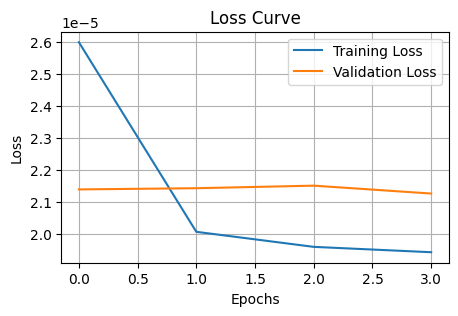

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.9732e-05 - val_loss: 2.1261e-05 - learning_rate: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 5/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.9929e-05
Epoch 5: val_loss did not improve from 0.00002


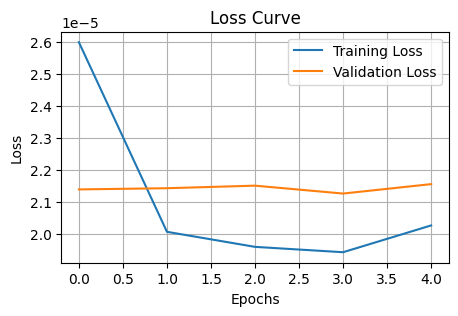

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.9930e-05 - val_loss: 2.1556e-05 - learning_rate: 1.0000e-04

Epoch 6: LearningRateScheduler setting learning rate to 7.999999797903001e-05.
Epoch 6/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.9438e-05
Epoch 6: val_loss did not improve from 0.00002


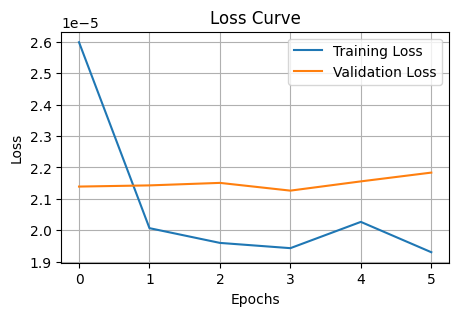

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.9438e-05 - val_loss: 2.1836e-05 - learning_rate: 8.0000e-05

Epoch 7: LearningRateScheduler setting learning rate to 7.999999797903001e-05.
Epoch 7/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8569e-05
Epoch 7: val_loss did not improve from 0.00002


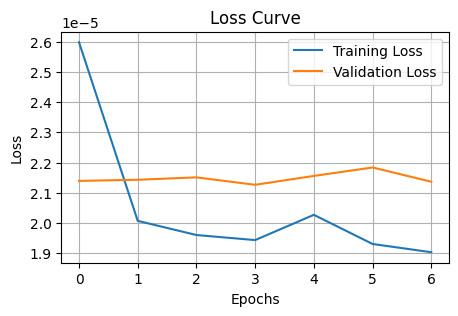

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.8570e-05 - val_loss: 2.1363e-05 - learning_rate: 8.0000e-05

Epoch 8: LearningRateScheduler setting learning rate to 7.999999797903001e-05.
Epoch 8/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8654e-05
Epoch 8: val_loss did not improve from 0.00002


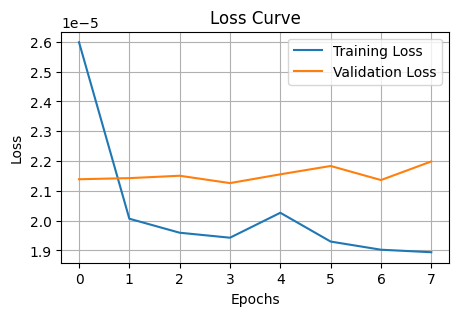

668/668 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 1.8654e-05 - val_loss: 2.1987e-05 - learning_rate: 8.0000e-05

Epoch 9: LearningRateScheduler setting learning rate to 7.999999797903001e-05.
Epoch 9/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8640e-05
Epoch 9: val_loss did not improve from 0.00002


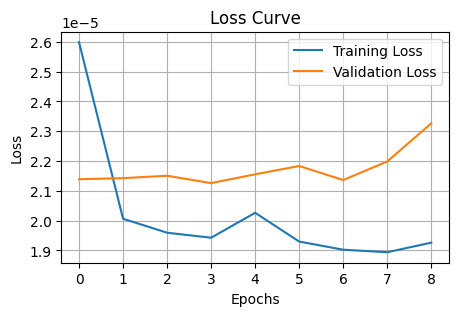

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.8643e-05 - val_loss: 2.3267e-05 - learning_rate: 8.0000e-05

Epoch 10: LearningRateScheduler setting learning rate to 7.999999797903001e-05.
Epoch 10/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.3500e-05
Epoch 10: val_loss did not improve from 0.00002


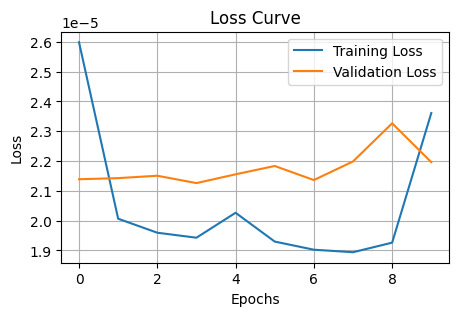

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 2.3501e-05 - val_loss: 2.1964e-05 - learning_rate: 8.0000e-05

Epoch 11: LearningRateScheduler setting learning rate to 6.399999838322402e-05.
Epoch 11/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.9439e-05
Epoch 11: val_loss did not improve from 0.00002


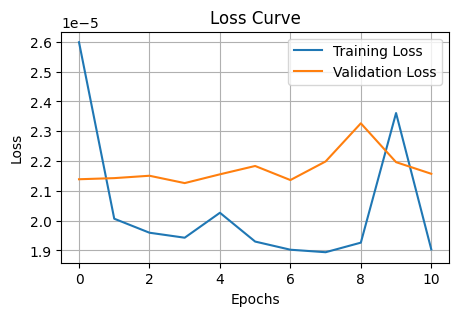

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.9437e-05 - val_loss: 2.1573e-05 - learning_rate: 6.4000e-05

Epoch 12: LearningRateScheduler setting learning rate to 6.399999983841553e-05.
Epoch 12/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.9296e-05
Epoch 12: val_loss did not improve from 0.00002


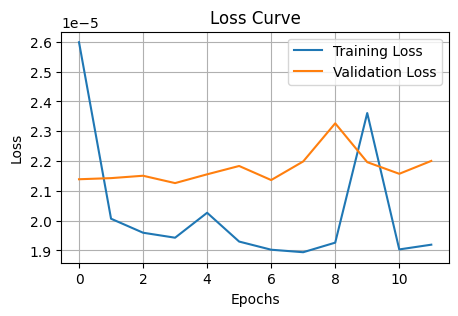

668/668 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 1.9296e-05 - val_loss: 2.2005e-05 - learning_rate: 6.4000e-05

Epoch 13: LearningRateScheduler setting learning rate to 6.399999983841553e-05.
Epoch 13/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8864e-05
Epoch 13: val_loss did not improve from 0.00002


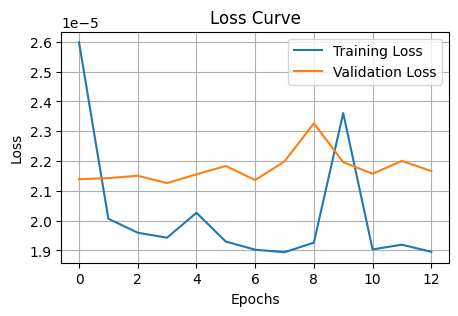

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.8864e-05 - val_loss: 2.1663e-05 - learning_rate: 6.4000e-05

Epoch 14: LearningRateScheduler setting learning rate to 6.399999983841553e-05.
Epoch 14/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8721e-05
Epoch 14: val_loss did not improve from 0.00002


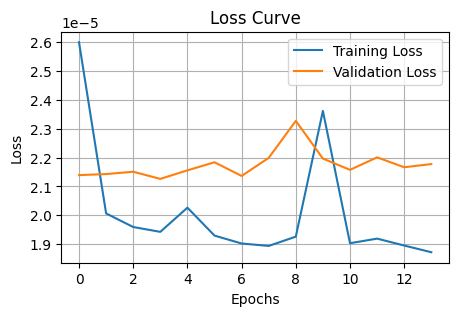

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.8721e-05 - val_loss: 2.1773e-05 - learning_rate: 6.4000e-05

Epoch 15: LearningRateScheduler setting learning rate to 6.399999983841553e-05.
Epoch 15/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8824e-05
Epoch 15: val_loss did not improve from 0.00002


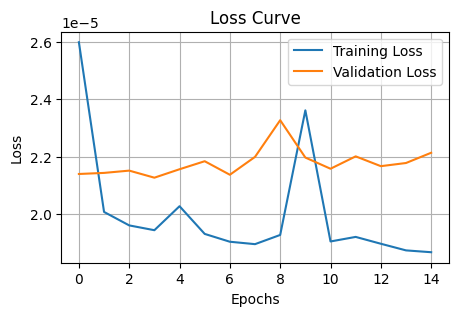

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.8824e-05 - val_loss: 2.2131e-05 - learning_rate: 6.4000e-05

Epoch 16: LearningRateScheduler setting learning rate to 5.119999987073243e-05.
Epoch 16/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8519e-05
Epoch 16: val_loss did not improve from 0.00002


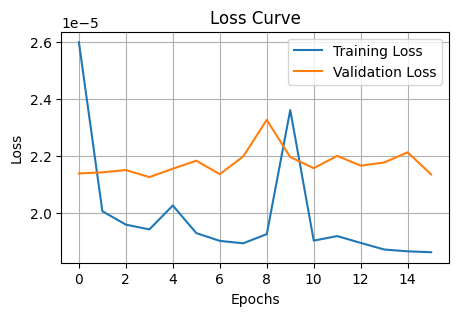

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.8520e-05 - val_loss: 2.1354e-05 - learning_rate: 5.1200e-05

Epoch 17: LearningRateScheduler setting learning rate to 5.120000059832819e-05.
Epoch 17/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8818e-05
Epoch 17: val_loss did not improve from 0.00002


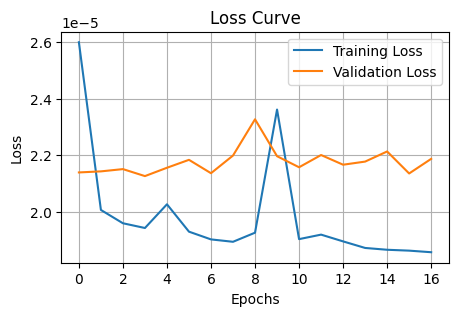

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.8817e-05 - val_loss: 2.1870e-05 - learning_rate: 5.1200e-05

Epoch 18: LearningRateScheduler setting learning rate to 5.120000059832819e-05.
Epoch 18/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8519e-05
Epoch 18: val_loss did not improve from 0.00002


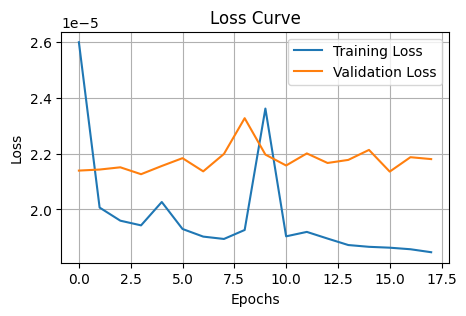

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.8519e-05 - val_loss: 2.1802e-05 - learning_rate: 5.1200e-05

Epoch 19: LearningRateScheduler setting learning rate to 5.120000059832819e-05.
Epoch 19/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8491e-05
Epoch 19: val_loss improved from 0.00002 to 0.00002, saving model to /kaggle/working/best_model.keras


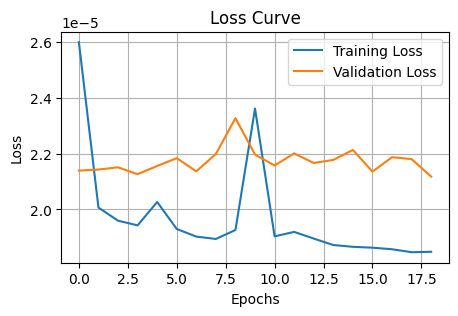

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.8491e-05 - val_loss: 2.1176e-05 - learning_rate: 5.1200e-05

Epoch 20: LearningRateScheduler setting learning rate to 5.120000059832819e-05.
Epoch 20/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8341e-05
Epoch 20: val_loss did not improve from 0.00002


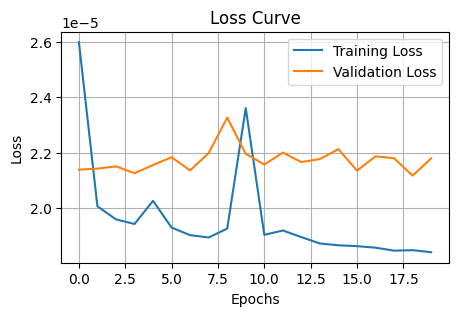

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.8341e-05 - val_loss: 2.1796e-05 - learning_rate: 5.1200e-05

Epoch 21: LearningRateScheduler setting learning rate to 4.0960000478662555e-05.
Epoch 21/100
666/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8532e-05
Epoch 21: val_loss did not improve from 0.00002


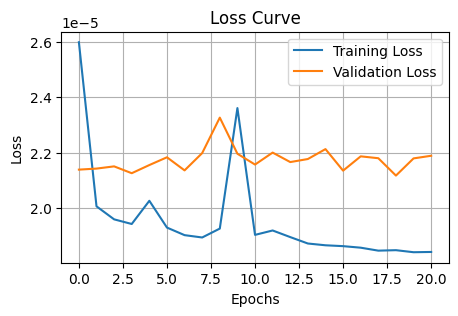

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.8531e-05 - val_loss: 2.1891e-05 - learning_rate: 4.0960e-05

Epoch 22: LearningRateScheduler setting learning rate to 4.095999975106679e-05.
Epoch 22/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8293e-05
Epoch 22: val_loss did not improve from 0.00002


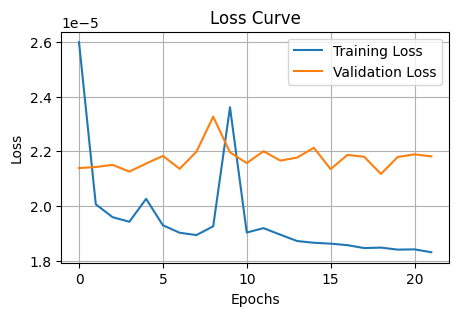

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.8293e-05 - val_loss: 2.1818e-05 - learning_rate: 4.0960e-05

Epoch 23: LearningRateScheduler setting learning rate to 4.095999975106679e-05.
Epoch 23/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8170e-05
Epoch 23: val_loss did not improve from 0.00002


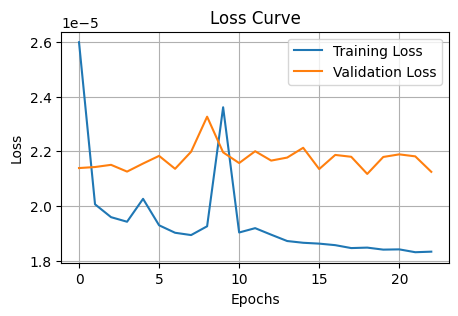

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.8170e-05 - val_loss: 2.1252e-05 - learning_rate: 4.0960e-05

Epoch 24: LearningRateScheduler setting learning rate to 4.095999975106679e-05.
Epoch 24/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8121e-05
Epoch 24: val_loss did not improve from 0.00002


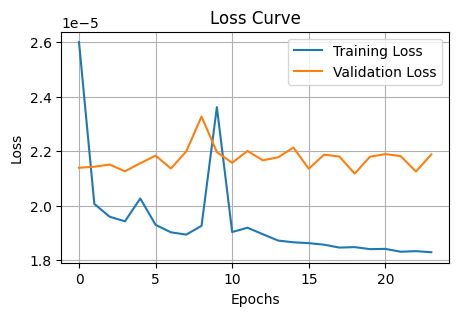

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.8121e-05 - val_loss: 2.1879e-05 - learning_rate: 4.0960e-05

Epoch 25: LearningRateScheduler setting learning rate to 4.095999975106679e-05.
Epoch 25/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8725e-05
Epoch 25: val_loss did not improve from 0.00002


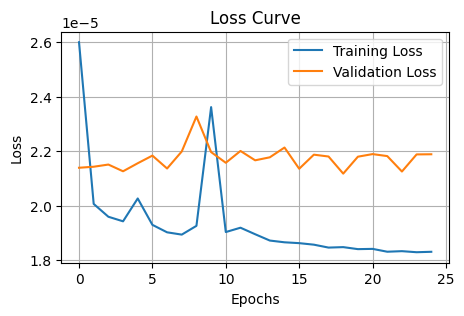

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.8724e-05 - val_loss: 2.1885e-05 - learning_rate: 4.0960e-05

Epoch 26: LearningRateScheduler setting learning rate to 3.2767999800853435e-05.
Epoch 26/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7913e-05
Epoch 26: val_loss did not improve from 0.00002


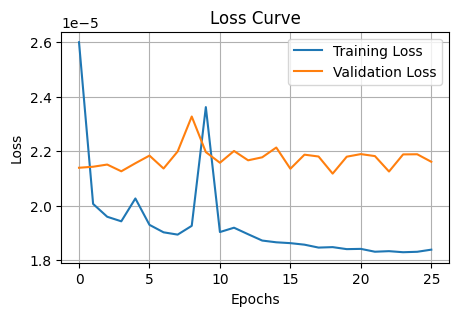

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.7913e-05 - val_loss: 2.1610e-05 - learning_rate: 3.2768e-05

Epoch 27: LearningRateScheduler setting learning rate to 3.276799907325767e-05.
Epoch 27/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8138e-05
Epoch 27: val_loss did not improve from 0.00002


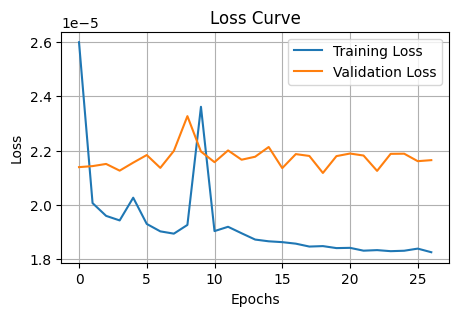

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.8138e-05 - val_loss: 2.1648e-05 - learning_rate: 3.2768e-05

Epoch 28: LearningRateScheduler setting learning rate to 3.276799907325767e-05.
Epoch 28/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8701e-05
Epoch 28: val_loss did not improve from 0.00002


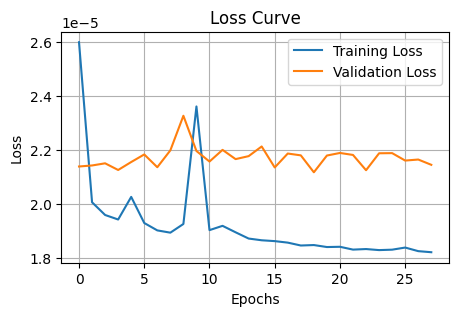

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.8698e-05 - val_loss: 2.1453e-05 - learning_rate: 3.2768e-05

Epoch 29: LearningRateScheduler setting learning rate to 3.276799907325767e-05.
Epoch 29/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8157e-05
Epoch 29: val_loss did not improve from 0.00002


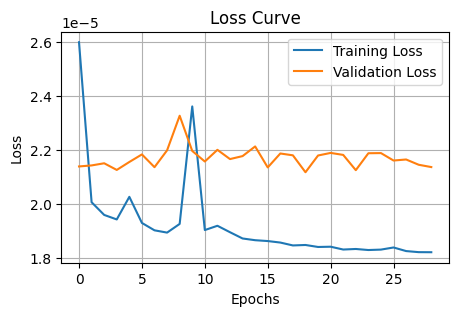

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.8158e-05 - val_loss: 2.1367e-05 - learning_rate: 3.2768e-05

Epoch 30: LearningRateScheduler setting learning rate to 3.276799907325767e-05.
Epoch 30/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8011e-05
Epoch 30: val_loss did not improve from 0.00002


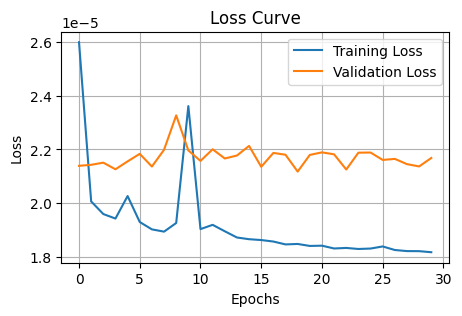

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.8011e-05 - val_loss: 2.1683e-05 - learning_rate: 3.2768e-05

Epoch 31: LearningRateScheduler setting learning rate to 2.6214399258606137e-05.
Epoch 31/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8189e-05
Epoch 31: val_loss did not improve from 0.00002


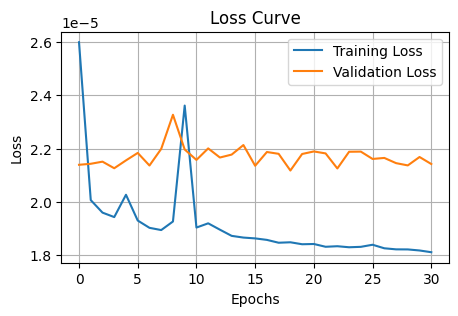

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.8189e-05 - val_loss: 2.1419e-05 - learning_rate: 2.6214e-05

Epoch 32: LearningRateScheduler setting learning rate to 2.6214398531010374e-05.
Epoch 32/100
667/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8148e-05
Epoch 32: val_loss did not improve from 0.00002


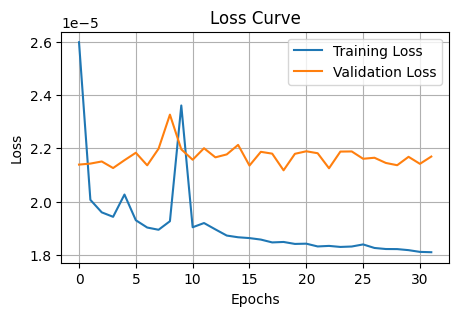

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.8148e-05 - val_loss: 2.1693e-05 - learning_rate: 2.6214e-05

Epoch 33: LearningRateScheduler setting learning rate to 2.6214398531010374e-05.
Epoch 33/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8360e-05
Epoch 33: val_loss did not improve from 0.00002


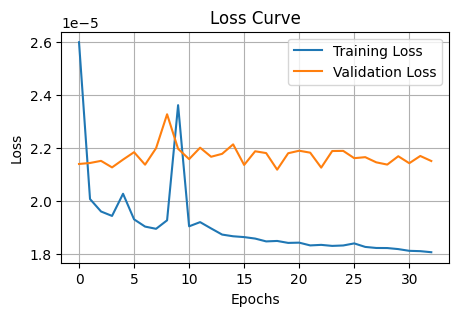

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.8359e-05 - val_loss: 2.1503e-05 - learning_rate: 2.6214e-05

Epoch 34: LearningRateScheduler setting learning rate to 2.6214398531010374e-05.
Epoch 34/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7763e-05
Epoch 34: val_loss did not improve from 0.00002


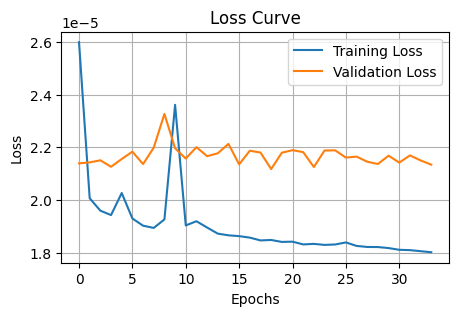

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.7764e-05 - val_loss: 2.1342e-05 - learning_rate: 2.6214e-05

Epoch 35: LearningRateScheduler setting learning rate to 2.6214398531010374e-05.
Epoch 35/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7975e-05
Epoch 35: val_loss did not improve from 0.00002


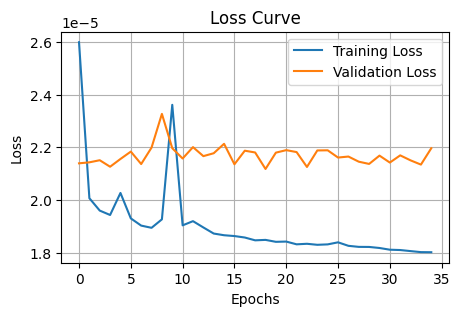

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.7975e-05 - val_loss: 2.1964e-05 - learning_rate: 2.6214e-05

Epoch 36: LearningRateScheduler setting learning rate to 2.09715188248083e-05.
Epoch 36/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7763e-05
Epoch 36: val_loss did not improve from 0.00002


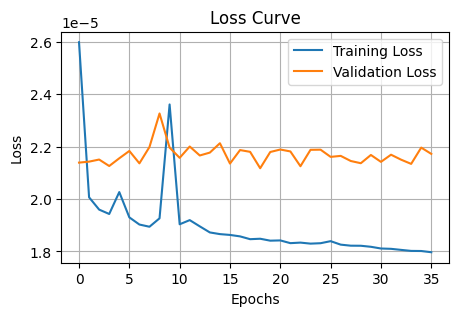

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.7764e-05 - val_loss: 2.1724e-05 - learning_rate: 2.0972e-05

Epoch 37: LearningRateScheduler setting learning rate to 2.0971518097212538e-05.
Epoch 37/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8064e-05
Epoch 37: val_loss did not improve from 0.00002


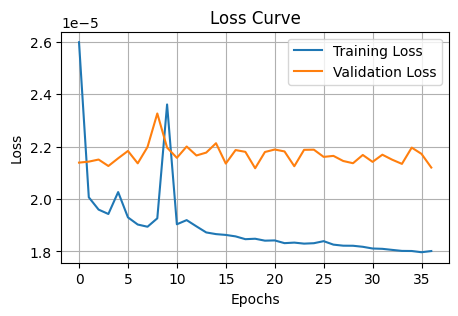

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.8064e-05 - val_loss: 2.1202e-05 - learning_rate: 2.0972e-05

Epoch 38: LearningRateScheduler setting learning rate to 2.0971518097212538e-05.
Epoch 38/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7769e-05
Epoch 38: val_loss did not improve from 0.00002


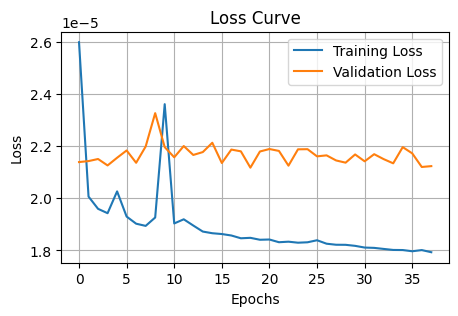

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.7769e-05 - val_loss: 2.1235e-05 - learning_rate: 2.0972e-05

Epoch 39: LearningRateScheduler setting learning rate to 2.0971518097212538e-05.
Epoch 39/100
665/668 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8291e-05
Epoch 39: val_loss did not improve from 0.00002


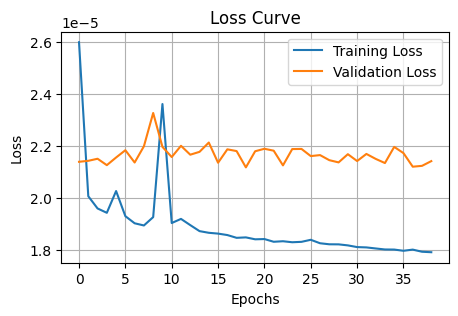

668/668 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.8289e-05 - val_loss: 2.1416e-05 - learning_rate: 2.0972e-05


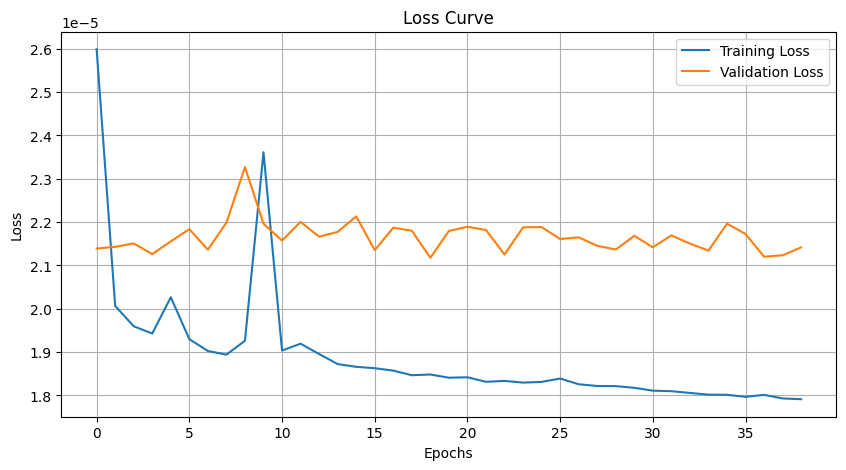

483/483 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 2.0035e-05
Test Loss: 2.0652991224778816e-05


In [ ]:
# Model: Bi-LSTM with Attention
# Input: Review
# Output: Total Price and Frequency

from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, Callback, ReduceLROnPlateau
from keras.models import Model
from keras.layers import Embedding, LSTM, Dense, Concatenate, Input, Flatten, Bidirectional, Attention, Dropout
import matplotlib.pyplot as plt
import tensorflow as tf

# Learning rate calculation
def lr_schedule(epoch, lr):
    initial_lr = 0.0001
    decay_rate = 0.8
    decay_step = 5
    if epoch == 0:
        return initial_lr
    if epoch % decay_step == 0:
        lr = lr * decay_rate
    return lr

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Model checkpoint callback
model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Dissertation Customer Segmentation/BILSTM_atttention_Review_best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)
# model_checkpoint = ModelCheckpoint(
#     '/kaggle/working/best_model.keras',
#     monitor='val_loss',
#     save_best_only=True,
#     save_weights_only=False,
#     mode='min',
#     verbose=1
# )

# Custom plotting callback
class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.epochs = []
        self.losses = []
        self.val_losses = []
        plt.ion()

    def on_epoch_end(self, epoch, logs={}):
        self.epochs.append(epoch)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

        plt.figure(figsize=(5, 3))
        plt.plot(self.epochs, self.losses, label='Training Loss')
        plt.plot(self.epochs, self.val_losses, label='Validation Loss')
        plt.title('Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.draw()
        plt.pause(0.001)
        plt.show()

plot_losses = PlotLosses()

# input_avg_rating = Input(shape=(1,))
input_review = Input(shape=(100,))

x = Embedding(input_dim=5000, output_dim=128, input_length=100)(input_review)
# x = LSTM(128, return_sequences=True)(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
attention = Attention()([x, x])
x = Flatten()(attention)
# x = Flatten()(x)

# Combine numerical and text inputs
combined = Concatenate()([input_avg_rating, x])

# Dense layers
combined = Dense(64, activation='relu')(x)
combined = Dropout(0.2)(combined)  # Dropout layer with 20% dropout rate
combined = Dense(32, activation='relu')(combined)
combined = Dropout(0.2)(combined)  # Dropout layer with 20% dropout rate
output = Dense(1)(combined)  # Single unit for the output layer

# Create the model
model = Model(inputs=input_review, outputs=output)

# Compile the model with the initial learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

model.summary()

history = model.fit(
    X_review_train,
    y_train_updated,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint, plot_losses]
)

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
loss = model.evaluate(X_review_test, y_test_updated)
print(f"Test Loss: {loss}")
